# Monthly Falls Analysis

## Jade Benson

In this notebook, I will analyze the monthly fall rates for each county over the study period (July 2009 - July 2015) to analyze the influence of both weather and sociodemographic variables. 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import geopandas as gpd
import geoplot as gplt
import mapclassify as mc

# Part 1 

## Data Preparation

### Load in Falls Counts

In [614]:
monthly_falls = pd.read_csv("medicare_monthly_falls.csv")

In [244]:
monthly_falls.head()

month_count  fipscounty     date
0          NaN        1001  2010-01
1         14.0        1001  2011-01
2          NaN        1001  2012-01
3          NaN        1001  2013-01
4          NaN        1001  2014-01

In [257]:
monthly_falls.describe()

month_count     fipscounty
count  72081.000000  205544.000000
mean      46.854636   30494.034114
std       71.720914   15060.357268
min       11.000000    1001.000000
25%       15.000000   19017.000000
50%       23.000000   29141.000000
75%       47.000000   45057.000000
max     1319.000000   56045.000000

In [296]:
len(monthly_falls['fipscounty'].unique())

3107

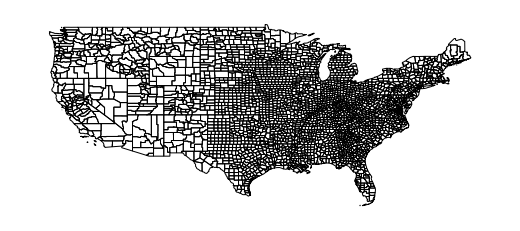

In [298]:
# plotting 
#https://python-graph-gallery.com/choropleth-map-geopandas-python

# Load the json file with county coordinates
geoData = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')

# Make sure the "id" column is an integer
geoData.id = geoData.id.astype(str).astype(int)

# Remove Alaska, Hawaii and Puerto Rico.
stateToRemove = ['02', '15', '72']
geoData = geoData[~geoData.STATE.isin(stateToRemove)]

# Basic plot with just county outlinesb
gplt.polyplot(geoData, figsize=(20, 4));

In [1052]:
covid_test = pd.read_csv('https://raw.githubusercontent.com/lin-lab/COVID-Health-Disparities/main/Data/covariates.csv', encoding='latin-1')
covid_test.head()

fips state          county stateName CountyNamew.StateAbbrev  \
0  1001    AL  Autauga County   Alabama             Autauga, AL   
1  1003    AL  Baldwin County   Alabama             Baldwin, AL   
2  1005    AL  Barbour County   Alabama             Barbour, AL   
3  1007    AL     Bibb County   Alabama                Bibb, AL   
4  1009    AL   Blount County   Alabama              Blount, AL   

  CensusRegionName  CensusDivisionName  tot_deaths  tot_cases   rate_cases  \
0            South  East South Central          44       3780  6765.827203   
1            South  East South Central         147      11952  5354.023133   
2            South  East South Central          32       1336  5411.974398   
3            South  East South Central          42       1628  7269.804412   
4            South  East South Central          54       4234  7321.965898   

   ...  Asthma  Cancer     COPD  Diabetes       HF      HTN       KD  Stroke  \
0  ...  4.5463  8.4762  13.8316   30.4180  15.8544  63.7064  25.5635  4.0647   
1  ...  4.8890  8.5693  11.5988   23.7710  12.8695  60.3339  21.7487  3.8740   
2  ...  5.5134  8.3313  10.6346   33.7907  13.7711  67.2384  28.2774  4.5822   
3  ...  4.9055  7.1557  13.6814   32.8083  17.3717  67.9118  29.5230  5.5356   
4  ...  5.3258  6.7350  14.9524   28.4956  16.2518  63.7811  24.5608  4.4290   

   NursingHomeBeds   ICUBeds  
0         0.000000  1.945910  
1         0.000000  3.951244  
2         0.000000  1.791759  
3         4.882802  0.000000  
4         0.000000  1.945910  

[5 rows x 51 columns]

In [1054]:
covid_test['CountyI']

0          1
1          2
2          3
3          4
4          5
        ... 
3137    3138
3138    3139
3139    3140
3140    3141
3141    3142
Name: CountyI, Length: 3142, dtype: int64

In [1056]:
covid_test['tot_cases'].describe()

count      3142.000000
mean       5582.749841
std       19533.042730
min           0.000000
25%         590.000000
50%        1429.500000
75%        3750.750000
max      634849.000000
Name: tot_cases, dtype: float64

In [291]:
def grouped_county_df(df):
    """
    Groups number of falls by county, multiple index
    """
    #reset index and drop duplicates
    grouped_df = df.set_index(['fipscounty', 'date'], inplace=False)
    unique_month_falls = grouped_df[~grouped_df.index.duplicated(keep='first')]
    return unique_month_falls

In [247]:
grouped_falls = grouped_county_df(monthly_falls)

In [260]:
#monthly fall counts for each county
grouped_falls.head()

month_count
fipscounty date                
1001       2010-01          NaN
           2011-01         14.0
           2012-01          NaN
           2013-01          NaN
           2014-01          NaN

In [261]:
#total records
len(grouped_falls)

205471

In [262]:
#total nonmissing records
len(grouped_falls[~grouped_falls['month_count'].isna()])

72008

In [263]:
#summary statistics of fall counts
grouped_falls.describe()

month_count
count  72008.000000
mean      46.868056
std       71.755419
min       11.000000
25%       15.000000
50%       23.000000
75%       47.000000
max     1319.000000

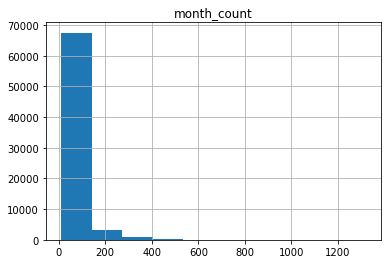

In [264]:
grouped_falls.hist();

In [265]:
grouped_falls[grouped_falls['month_count']==1319]
#the max fall count is in Cook county (Chicago) in Jan 2013

month_count
fipscounty date                
17031      2013-01       1319.0

In [266]:
#high fall counts (over 200)
high_falls = grouped_falls[grouped_falls['month_count']>200]
len(high_falls)

2428

In [290]:
def plot_fall_counts(grouped_df, var_name, US_map, title): 
    """
    Plots the grouped_df on a US_map from GeoData
    """
    total_month_counts = grouped_df.groupby(['fipscounty']).sum()
    plot_data = US_map.merge(total_month_counts, left_on=['id'], right_on=['fipscounty'])
    
    
    #plot 
    # Initialize the figure
    fig, ax = plt.subplots(1, 1, figsize=(16, 12))

    # Set up the color sheme:
    scheme = mc.Quantiles(plot_data[var_name], k=10)

    # Map
    gplt.choropleth(plot_data, 
        hue=var_name, 
        linewidth=.1,
        scheme=scheme, cmap='Greens',
        legend=True,
        edgecolor='black',
        ax=ax
    );

    ax.set_title(title, fontsize=13);

    

/Users/jadebenson/opt/anaconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/Users/jadebenson/opt/anaconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 7
  Warn("Warning: setting k to %d" % k_q, UserWarning)


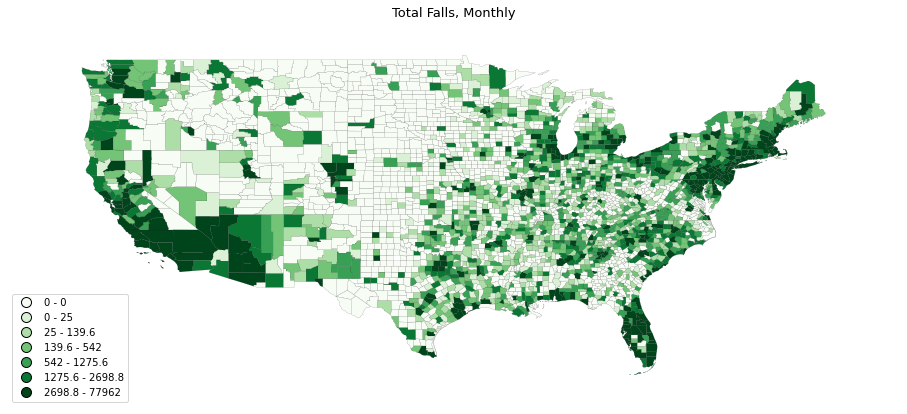

In [8]:
#total fall count by county
plot_fall_counts(grouped_falls, geoData, "Total Falls, Monthly")

### Load in Weather

In [7]:
weather = pd.read_pickle('monthly_weather_summary.pkl')

In [77]:
weather.head()

FIPS month_year  tavg_min  tavg_max  tavg_median  tavg_mean  tavg_std  \
0  1001    2009-07      23.0      28.7         26.4  26.306897  1.427018   
1  1001    2009-08      21.9      28.6         26.2  26.096552  1.591604   
2  1001    2009-09      17.4      26.4         24.6  24.158621  2.024408   
3  1001    2009-10       8.9      26.5         19.3  18.162069  4.860586   
4  1001    2009-11       6.7      18.1         12.2  12.196552  2.732278   

   tmin_min  tmin_max  tmin_median  ...  pres_min  pres_max  pres_median  \
0      16.2      24.5         22.0  ...    1008.7    1022.0      1016.30   
1      15.8      24.1         22.7  ...    1012.2    1021.6      1016.85   
2      11.2      23.1         22.0  ...    1011.9    1018.8      1016.75   
3       3.8      22.1         14.7  ...    1008.3    1025.8      1015.85   
4       0.9      16.0          6.5  ...    1011.7    1026.8      1019.90   

     pres_mean  pres_std  tsun_min  tsun_max  tsun_median  tsun_mean  tsun_std  
0  1016.054167  2.961342       NaN       NaN          NaN        NaN       NaN  
1  1017.096429  2.036788       NaN       NaN          NaN        NaN       NaN  
2  1015.935714  2.193292       NaN       NaN          NaN        NaN       NaN  
3  1016.707143  4.409244       NaN       NaN          NaN        NaN       NaN  
4  1019.275000  3.990881       NaN       NaN          NaN        NaN       NaN  

[5 rows x 52 columns]

In [267]:
#this includes all the monthly variables created from the weather processing daily notebook
weather.columns

Index(['FIPS', 'month_year', 'tavg_min', 'tavg_max', 'tavg_median',
       'tavg_mean', 'tavg_std', 'tmin_min', 'tmin_max', 'tmin_median',
       'tmin_mean', 'tmin_std', 'tmax_min', 'tmax_max', 'tmax_median',
       'tmax_mean', 'tmax_std', 'prcp_min', 'prcp_max', 'prcp_median',
       'prcp_mean', 'prcp_std', 'snow_min', 'snow_max', 'snow_median',
       'snow_mean', 'snow_std', 'wdir_min', 'wdir_max', 'wdir_median',
       'wdir_mean', 'wdir_std', 'wspd_min', 'wspd_max', 'wspd_median',
       'wspd_mean', 'wspd_std', 'wpgt_min', 'wpgt_max', 'wpgt_median',
       'wpgt_mean', 'wpgt_std', 'pres_min', 'pres_max', 'pres_median',
       'pres_mean', 'pres_std', 'tsun_min', 'tsun_max', 'tsun_median',
       'tsun_mean', 'tsun_std'],
      dtype='object')

### Load in ACS - Sociodemographic variables 

In [281]:
#ACS data - still in long format 
acs = pd.read_csv('final_ACS_vars.csv', index_col = 0)


In [282]:
acs.head()

GEOID  total_pop  median_income  gini_index  pop_65_up  prop_65_85_up  \
1   1001       3828        26728.0      0.4100       7321       0.091381   
2   1003      10881        25349.0      0.4517      33782       0.104790   
3   1005       3138        16750.0      0.4608       4180       0.112440   
4   1007       1687        19545.0      0.4365       3209       0.101901   
5   1009       5106        23858.0      0.4134       9172       0.087767   

   prop_female  prop_white_nh  prop_poor  
1     0.577244       0.829531   0.067614  
2     0.536025       0.928453   0.065449  
3     0.569139       0.652392   0.150239  
4     0.550016       0.831100   0.109691  
5     0.554514       0.960423   0.092673

In [283]:
len(acs)

3220

In [286]:
unique_acs = acs.drop_duplicates()
len(unique_acs)

3220

In [287]:
acs.describe()

GEOID      total_pop  median_income   gini_index     pop_65_up  \
count   3220.000000    3220.000000    3142.000000  3220.000000  3.220000e+03   
mean   31393.643478    8117.627019   23957.480586     0.441816  1.359009e+04   
std    16292.019724   22619.093279    5179.583618     0.036075  3.876406e+04   
min     1001.000000      22.000000    8090.000000     0.334600  6.000000e+00   
25%    19032.500000    1427.000000   20603.000000     0.418100  1.962750e+03   
50%    30024.000000    2751.500000   23322.000000     0.438700  4.209000e+03   
75%    46107.500000    6737.250000   26464.250000     0.463500  1.030650e+04   
max    72153.000000  751076.000000   59876.000000     0.651900  1.149893e+06   

       prop_65_85_up  prop_female  prop_white_nh    prop_poor  
count    3220.000000  3220.000000    3220.000000  3220.000000  
mean        0.127555     0.551010       0.851034     0.107975  
std         0.036522     0.030220       0.204148     0.069089  
min         0.000000     0.306931       0.000000     0.000000  
25%         0.104194     0.537529       0.804453     0.069999  
50%         0.125251     0.554277       0.936753     0.090627  
75%         0.148176     0.568248       0.975539     0.123280  
max         0.395833     1.000000       1.000000     0.593927

In [444]:
#merge this with ACS to get the censusarea 
county_area = geoData[['id', 'CENSUSAREA']]
county_area.head()

id  CENSUSAREA
0  1001     594.436
1  1009     644.776
2  1017     596.531
3  1021     692.854
4  1033     592.619

In [446]:
acs_full = acs.merge(county_area, left_on = 'GEOID', right_on = 'id', how = 'inner')

In [447]:
acs_full.head()

GEOID  total_pop  median_income  gini_index  pop_65_up  prop_65_85_up  \
0   1001       3828        26728.0      0.4100       7321       0.091381   
1   1003      10881        25349.0      0.4517      33782       0.104790   
2   1005       3138        16750.0      0.4608       4180       0.112440   
3   1007       1687        19545.0      0.4365       3209       0.101901   
4   1009       5106        23858.0      0.4134       9172       0.087767   

   prop_female  prop_white_nh  prop_poor    id  CENSUSAREA  
0     0.577244       0.829531   0.067614  1001     594.436  
1     0.536025       0.928453   0.065449  1003    1589.784  
2     0.569139       0.652392   0.150239  1005     884.876  
3     0.550016       0.831100   0.109691  1007     622.582  
4     0.554514       0.960423   0.092673  1009     644.776

In [448]:
acs_full['pop_density'] = acs_full['total_pop'] / acs_full['CENSUSAREA']

## Merging

In [449]:
monthly_falls['month_year'] = pd.to_datetime(monthly_falls['date']).dt.to_period('M')

In [450]:
falls_weather = monthly_falls.merge(weather, left_on = ['fipscounty', 'month_year'], right_on = ['FIPS', 'month_year'], how = 'inner')

In [451]:
len(falls_weather['fipscounty'].unique())

3105

In [452]:
falls_weather.head()

month_count  fipscounty     date month_year  FIPS  tavg_min  tavg_max  \
0          NaN        1001  2010-01    2010-01  1001      -3.9      15.6   
1         14.0        1001  2011-01    2011-01  1001      -2.3      16.1   
2          NaN        1001  2012-01    2012-01  1001       0.3      18.9   
3          NaN        1001  2013-01    2013-01  1001       5.0      20.9   
4          NaN        1001  2014-01    2014-01  1001      -7.2      11.6   

   tavg_median  tavg_mean  tavg_std  ...  pres_min  pres_max  pres_median  \
0         6.70   5.393103  6.070769  ...    1002.2    1033.8      1023.00   
1         6.70   5.823333  4.301217  ...    1004.6    1034.2      1018.95   
2        11.75  11.310714  5.214747  ...    1006.0    1031.5      1020.40   
3        12.40  12.092308  5.250137  ...    1008.4    1030.9      1023.80   
4         3.90   3.485185  4.998669  ...    1015.2    1035.5      1021.40   

     pres_mean  pres_std  tsun_min  tsun_max  tsun_median  tsun_mean  tsun_std  
0  1020.110345  8.091192       NaN       NaN          NaN        NaN       NaN  
1  1019.213333  6.671594       NaN       NaN          NaN        NaN       NaN  
2  1020.540741  6.408664       NaN       NaN          NaN        NaN       NaN  
3  1022.432000  5.037751       NaN       NaN          NaN        NaN       NaN  
4  1022.922727  6.570130       NaN       NaN          NaN        NaN       NaN  

[5 rows x 55 columns]

In [453]:
len(falls_weather['month_count'])

195568

In [518]:
full_df = falls_weather.merge(acs_full, left_on = 'FIPS', right_on = 'GEOID', how = 'inner')

In [519]:
full_df.head()

month_count  fipscounty     date month_year  FIPS  tavg_min  tavg_max  \
0          NaN        1001  2010-01    2010-01  1001      -3.9      15.6   
1         14.0        1001  2011-01    2011-01  1001      -2.3      16.1   
2          NaN        1001  2012-01    2012-01  1001       0.3      18.9   
3          NaN        1001  2013-01    2013-01  1001       5.0      20.9   
4          NaN        1001  2014-01    2014-01  1001      -7.2      11.6   

   tavg_median  tavg_mean  tavg_std  ...  median_income  gini_index  \
0         6.70   5.393103  6.070769  ...        26728.0        0.41   
1         6.70   5.823333  4.301217  ...        26728.0        0.41   
2        11.75  11.310714  5.214747  ...        26728.0        0.41   
3        12.40  12.092308  5.250137  ...        26728.0        0.41   
4         3.90   3.485185  4.998669  ...        26728.0        0.41   

   pop_65_up  prop_65_85_up  prop_female  prop_white_nh  prop_poor    id  \
0       7321       0.091381     0.577244       0.829531   0.067614  1001   
1       7321       0.091381     0.577244       0.829531   0.067614  1001   
2       7321       0.091381     0.577244       0.829531   0.067614  1001   
3       7321       0.091381     0.577244       0.829531   0.067614  1001   
4       7321       0.091381     0.577244       0.829531   0.067614  1001   

   CENSUSAREA  pop_density  
0     594.436     6.439718  
1     594.436     6.439718  
2     594.436     6.439718  
3     594.436     6.439718  
4     594.436     6.439718  

[5 rows x 67 columns]

In [505]:
len(full_df['fipscounty'].unique())

3104

In [506]:
len(full_df['date'].unique())

73

In [520]:
full_df['raw_fall_rate'] = full_df['month_count'] / full_df['pop_65_up']

In [521]:
full_df['scaled_fall_rate'] = full_df['raw_fall_rate'] * 100000

In [522]:
full_df.iloc[70:100, :]

month_count  fipscounty     date month_year  FIPS  tavg_min  tavg_max  \
70          NaN        1001  2012-12    2012-12  1001       3.3      18.7   
71          NaN        1001  2013-12    2013-12  1001       2.6      22.3   
72          NaN        1001  2014-12    2014-12  1001       5.8      18.1   
73         36.0        1003  2010-01    2010-01  1003      -0.5      19.1   
74         35.0        1003  2011-01    2011-01  1003       0.8      18.8   
75         37.0        1003  2012-01    2012-01  1003       4.3      21.5   
76         47.0        1003  2013-01    2013-01  1003       7.8      22.9   
77         41.0        1003  2015-01    2015-01  1003      -2.3      20.3   
78         26.0        1003  2010-02    2010-02  1003       3.7      15.4   
79         33.0        1003  2011-02    2011-02  1003       3.7      23.0   
80         32.0        1003  2012-02    2012-02  1003       3.1      20.7   
81         32.0        1003  2013-02    2013-02  1003       8.2      20.4   
82         38.0        1003  2015-02    2015-02  1003       1.9      18.0   
83         45.0        1003  2010-03    2010-03  1003       8.0      21.0   
84         41.0        1003  2011-03    2011-03  1003      15.0      19.3   
85         44.0        1003  2012-03    2012-03  1003      13.7      22.8   
86         34.0        1003  2013-03    2013-03  1003       5.5      21.6   
87         50.0        1003  2015-03    2015-03  1003       3.9      21.2   
88         30.0        1003  2010-04    2010-04  1003      14.6      24.7   
89         37.0        1003  2011-04    2011-04  1003      14.1      27.1   
90         35.0        1003  2012-04    2012-04  1003      15.3      24.3   
91         29.0        1003  2013-04    2013-04  1003      13.1      22.4   
92         39.0        1003  2014-04    2014-04  1003      14.4      22.4   
93         35.0        1003  2015-04    2015-04  1003      16.6      22.8   
94         47.0        1003  2010-05    2010-05  1003      21.0      29.3   
95         38.0        1003  2011-05    2011-05  1003      16.5      27.1   
96         34.0        1003  2012-05    2012-05  1003      24.2      24.2   
97         36.0        1003  2013-05    2013-05  1003      13.9      26.7   
98         49.0        1003  2014-05    2014-05  1003      15.6      24.6   
99         47.0        1003  2015-05    2015-05  1003      17.1      25.1   

    tavg_median  tavg_mean  tavg_std  ...  pop_65_up  prop_65_85_up  \
70        13.70  12.132143  4.720566  ...       7321       0.091381   
71         7.85  10.657692  5.951079  ...       7321       0.091381   
72         9.70  10.792308  3.997792  ...       7321       0.091381   
73         8.70   8.083333  6.103860  ...      33782       0.104790   
74        10.15   9.317857  4.458288  ...      33782       0.104790   
75        15.00  14.634615  5.279465  ...      33782       0.104790   
76        15.00  14.865385  4.786476  ...      33782       0.104790   
77         8.85   8.950000  4.579471  ...      33782       0.104790   
78         8.45   8.391667  3.222194  ...      33782       0.104790   
79        11.50  12.634783  6.625818  ...      33782       0.104790   
80        14.75  14.483333  4.359065  ...      33782       0.104790   
81        14.75  14.325000  3.522876  ...      33782       0.104790   
82         7.65   8.410714  4.448249  ...      33782       0.104790   
83        14.60  14.178571  3.655777  ...      33782       0.104790   
84        16.70  16.925000  1.776467  ...      33782       0.104790   
85        19.90  19.368182  2.720012  ...      33782       0.104790   
86        13.35  13.365385  4.621164  ...      33782       0.104790   
87        18.30  16.918519  4.405943  ...      33782       0.104790   
88        19.50  20.040741  2.358334  ...      33782       0.104790   
89        21.80  21.760000  3.605908  ...      33782       0.104790   
90        20.80  20.393333  2.434416  ...      33782       0.104790   
91        18.80  18.566667  2.715476  ...      33782  

In [523]:
full_df.drop(['FIPS', 'month_year', 'GEOID', 'total_pop', 'id', 'CENSUSAREA', 'raw_fall_rate'], axis = 1, inplace = True)

In [524]:
full_df.to_pickle("full_data.pkl")

# Part 2 


## Data Exploration

In [287]:
full_df = pd.read_pickle("full_data.pkl")

In [288]:
full_df.head()

month_count  fipscounty     date  tavg_min  tavg_max  tavg_median  \
0          NaN        1001  2010-01      -3.9      15.6         6.70   
1         14.0        1001  2011-01      -2.3      16.1         6.70   
2          NaN        1001  2012-01       0.3      18.9        11.75   
3          NaN        1001  2013-01       5.0      20.9        12.40   
4          NaN        1001  2014-01      -7.2      11.6         3.90   

   tavg_mean  tavg_std  tmin_min  tmin_max  ...  tsun_std  median_income  \
0   5.393103  6.070769      -8.9      11.0  ...       NaN        26728.0   
1   5.823333  4.301217      -8.0      12.0  ...       NaN        26728.0   
2  11.310714  5.214747      -5.9      17.2  ...       NaN        26728.0   
3  12.092308  5.250137      -0.6      17.1  ...       NaN        26728.0   
4   3.485185  4.998669     -10.9       7.0  ...       NaN        26728.0   

   gini_index  pop_65_up  prop_65_85_up  prop_female  prop_white_nh  \
0        0.41       7321       0.091381     0.577244       0.829531   
1        0.41       7321       0.091381     0.577244       0.829531   
2        0.41       7321       0.091381     0.577244       0.829531   
3        0.41       7321       0.091381     0.577244       0.829531   
4        0.41       7321       0.091381     0.577244       0.829531   

   prop_poor  pop_density  scaled_fall_rate  
0   0.067614     6.439718               NaN  
1   0.067614     6.439718        191.230706  
2   0.067614     6.439718               NaN  
3   0.067614     6.439718               NaN  
4   0.067614     6.439718               NaN  

[5 rows x 62 columns]

In [293]:
#small version to plot only rates now 
fall_rates = full_df[['fipscounty', 'date', 'scaled_fall_rate']]

In [301]:
fall_rates_grouped = grouped_county_df(fall_rates)

In [302]:
fall_rates_grouped.head()

scaled_fall_rate
fipscounty date                     
1001       2010-01               NaN
           2011-01        191.230706
           2012-01               NaN
           2013-01               NaN
           2014-01               NaN

**Summed all scaled fall rates together, this is not correct**

/Users/jadebenson/opt/anaconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/Users/jadebenson/opt/anaconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 7
  Warn("Warning: setting k to %d" % k_q, UserWarning)


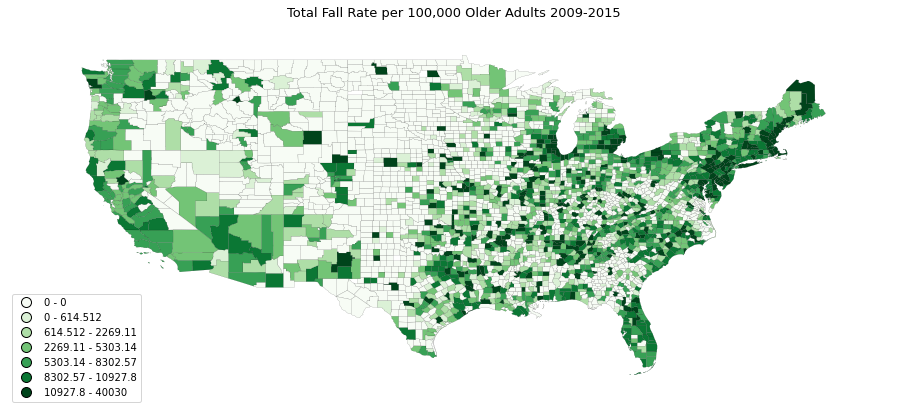

In [303]:
## THIS IS NOT CORRECT 
#Rates don't make sense, just summed across all rates, something weird happened
plot_fall_counts(fall_rates_grouped, 'scaled_fall_rate', geoData, 'Total Fall Rate per 100,000 Older Adults 2009-2015')

**Now want to sum all the counts of falls, then divide by total population** 

In [304]:
monthly_fall_counts = full_df[['fipscounty', 'date', 'month_count']]
grouped_falls = grouped_county_df(monthly_fall_counts)

In [305]:
#I also want to try plotting the cummulative rates for total study period where 
#all fall counts are summed over the period then divided by the total population 
total_county_falls = grouped_falls['month_count'].groupby([ "fipscounty"] ).sum().reset_index()

In [306]:
total_county_falls.head()

fipscounty  month_count
0        1001        299.0
1        1003       2438.0
2        1005          0.0
3        1007          0.0
4        1009         60.0

In [307]:
county_pops = full_df[['fipscounty', 'pop_65_up']]
county_pops = county_pops.drop_duplicates()
county_pops.reset_index(inplace=True, drop=True)
county_pops.head()

fipscounty  pop_65_up
0        1001       7321
1        1003      33782
2        1005       4180
3        1007       3209
4        1009       9172

In [308]:
cum_fall_rates = total_county_falls.merge(county_pops, left_on = 'fipscounty', right_on = 'fipscounty', how = 'inner')

In [309]:
cum_fall_rates['scaled_cum_rate'] = (cum_fall_rates['month_count']/cum_fall_rates['pop_65_up'])* 100000

In [310]:
cum_fall_rates.head(20)

fipscounty  month_count  pop_65_up  scaled_cum_rate
0         1001        299.0       7321      4084.141511
1         1003       2438.0      33782      7216.861050
2         1005          0.0       4180         0.000000
3         1007          0.0       3209         0.000000
4         1009         60.0       9172       654.164850
5         1011          0.0       1529         0.000000
6         1013         46.0       3592      1280.623608
7         1015       2905.0      17820     16301.907969
8         1017        384.0       6041      6356.563483
9         1019         55.0       5004      1099.120703
10        1021         22.0       6391       344.234079
11        1023          0.0       2657         0.000000
12        1025         23.0       4318       532.654006
13        1027         11.0       2487       442.299960
14        1029         13.0       2603       499.423742
15        1031        546.0       7653      7134.457076
16        1033       1167.0       9701     12029.687661
17        1035         60.0       2465      2434.077079
18        1037          0.0       1956         0.000000
19        1039        624.0       7306      8540.925267

In [311]:
len(cum_fall_rates['scaled_cum_rate'])

3104

In [312]:
 1 - len(cum_fall_rates[cum_fall_rates['scaled_cum_rate']==0.0]) / len(cum_fall_rates['scaled_cum_rate'])


0.5718427835051547

In [316]:
cum_fall_rates.describe()

fipscounty   month_count     pop_65_up  scaled_cum_rate
count   3104.000000   3104.000000  3.104000e+03      3104.000000
mean   30655.719072   1051.770941  1.382184e+04      3504.763479
std    14985.567961   3284.584295  3.934436e+04      4693.203685
min     1001.000000      0.000000  6.600000e+01         0.000000
25%    19042.500000      0.000000  1.973750e+03         0.000000
50%    29208.000000     24.000000  4.217000e+03       614.511635
75%    46005.500000    808.000000  1.056450e+04      6912.790503
max    56045.000000  77962.000000  1.149893e+06     40030.041307

In [ ]:
#how does this compare to just summing all the rates? 
summed_rates_df = fall_rates_grouped.groupby(['fipscounty']).sum()
summed_rates_df.head()
#some rounding errors happening :/ use the other dataframe for the national plotting 


In [422]:
#plot the national rates using these rates 

cum_fall_rates.head()

fipscounty  month_count  pop_65_up  scaled_cum_rate  nofalldata
0        1001        299.0       7321      4084.141511           0
1        1003       2438.0      33782      7216.861050           0
2        1005          0.0       4180         0.000000           1
3        1007          0.0       3209         0.000000           1
4        1009         60.0       9172       654.164850           0

In [425]:
#replace 0.0 with NA 
cum_fall_rates.replace(0.0, np.nan, inplace=True)
cum_fall_rates.head()
#gets rid of the nofalldata column, fix this later 

fipscounty  month_count  pop_65_up  scaled_cum_rate  nofalldata
0        1001        299.0       7321      4084.141511         NaN
1        1003       2438.0      33782      7216.861050         NaN
2        1005          NaN       4180              NaN         1.0
3        1007          NaN       3209              NaN         1.0
4        1009         60.0       9172       654.164850         NaN

In [601]:
print(len(cum_fall_rates['fipscounty'].unique()))
print(len(geoData['id'].unique()))

3104
3109


In [596]:
plot_data = geoData.merge(cum_fall_rates, left_on=['id'], right_on=['fipscounty'], how ='outer')
plot_data.head()

id          GEO_ID STATE COUNTY      NAME    LSAD  CENSUSAREA  \
0  1001  0500000US01001    01    001   Autauga  County     594.436   
1  1009  0500000US01009    01    009    Blount  County     644.776   
2  1017  0500000US01017    01    017  Chambers  County     596.531   
3  1021  0500000US01021    01    021   Chilton  County     692.854   
4  1033  0500000US01033    01    033   Colbert  County     592.619   

                                            geometry  fipscounty  month_count  \
0  POLYGON ((-86.49677 32.34444, -86.71790 32.402...      1001.0        299.0   
1  POLYGON ((-86.57780 33.76532, -86.75914 33.840...      1009.0         60.0   
2  POLYGON ((-85.18413 32.87053, -85.12342 32.772...      1017.0        384.0   
3  POLYGON ((-86.51734 33.02057, -86.51596 32.929...      1021.0         22.0   
4  POLYGON ((-88.13999 34.58170, -88.13925 34.587...      1033.0       1167.0   

   pop_65_up  scaled_cum_rate  nofalldata  
0     7321.0      4084.141511         NaN  
1     9172.0       654.164850         NaN  
2     6041.0      6356.563483         NaN  
3     6391.0       344.234079         NaN  
4     9701.0     12029.687661         NaN

In [569]:
type(plot_data['STATE'].loc[0])

str

In [597]:
#https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf
#regions key 
west_codes = ['53', '41', '06', '30', '16', '56', '32', '49', '08', '04', '35']
midwest_codes = ['38', '46', '31', '20', '27', '19', '29', '55', '17', '18', '26', '39']
south_codes = ['48', '40', '05', '22', '28', '01', '13', '12', '45', '37', '21', '47', '54','24', '10', '51', '11']
northeast_codes = ['42', '36', '34', '50', '33', '23', '09', '44', '25']

In [598]:
plot_data['region'] = np.where(plot_data['STATE'].isin(west_codes), 'west',
                               np.where(plot_data['STATE'].isin(midwest_codes), 'midwest',
                                        np.where(plot_data['STATE'].isin(south_codes), 'south',
                                                 np.where(plot_data['STATE'].isin(northeast_codes), 'northeast',0
                              ))))

In [603]:
#looks like weird county might be in ND 
#nd_test = plot_data[plot_data['STATE'] == '38']

In [604]:
#nd_test.drop_duplicates(subset=['fipscounty'])
#there are three missing counties in the fall rate data, by full merging, the weird missing ones were fixed

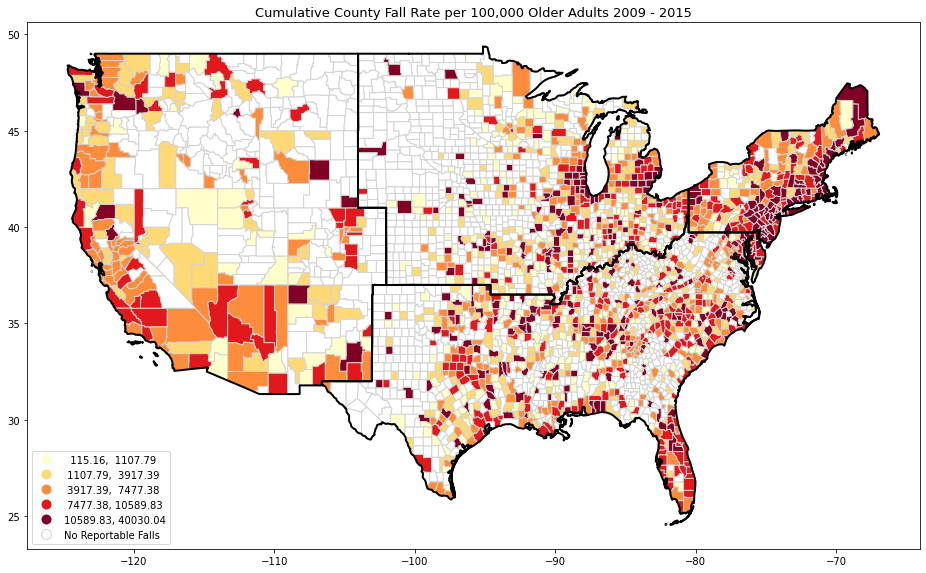

In [605]:
#plot 
# Initialize the figure
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

# Set up the color sheme:

missing_kwds={"color": "white",
"edgecolor": "lightgrey",
"label": "No Reportable Falls"}

plot_data.plot(column='scaled_cum_rate', scheme='Quantiles', k= 5,
         legend=True, edgecolor = 'lightgrey', cmap = 'YlOrRd',
               legend_kwds=dict(loc='lower left'),
         missing_kwds=missing_kwds, ax=ax)

plot_data.loc[plot_data['region'] == 'west'].dissolve('region').plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)
plot_data.loc[plot_data['region'] == 'midwest'].dissolve('region').plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)
plot_data.loc[plot_data['region'] == 'south'].dissolve('region').plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)
plot_data.loc[plot_data['region'] == 'northeast'].dissolve('region').plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)

ax.set_title('Cumulative County Fall Rate per 100,000 Older Adults 2009 - 2015', fontsize=13);


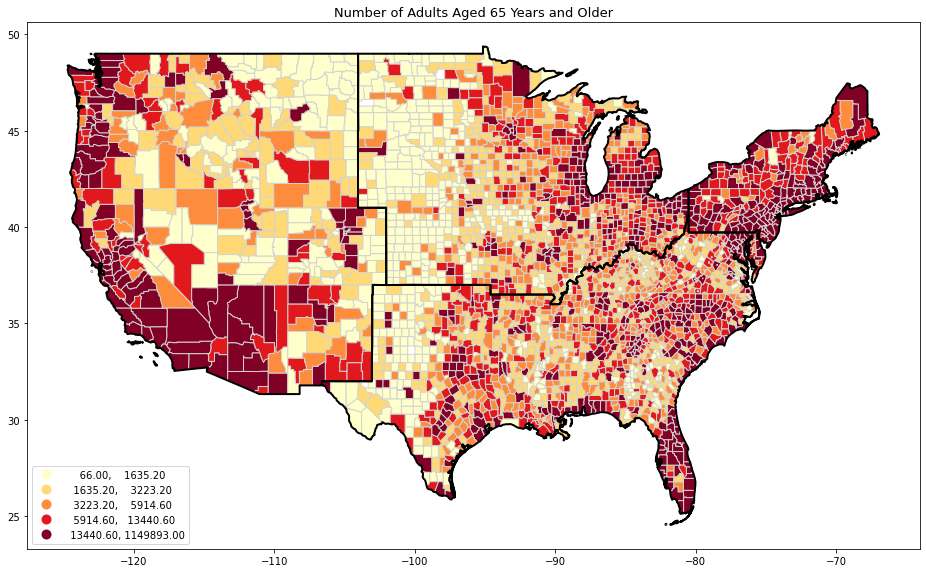

In [606]:
#Population Plot 

# Initialize the figure
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

# Set up the color sheme:

plot_data.plot(column='pop_65_up', scheme='Quantiles', k= 5,
         legend=True, legend_kwds=dict(loc='lower left'),
               edgecolor = 'lightgrey', cmap = 'YlOrRd',ax=ax)

plot_data.loc[plot_data['region'] == 'west'].dissolve('region').plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)
plot_data.loc[plot_data['region'] == 'midwest'].dissolve('region').plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)
plot_data.loc[plot_data['region'] == 'south'].dissolve('region').plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)
plot_data.loc[plot_data['region'] == 'northeast'].dissolve('region').plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)

ax.set_title('Number of Adults Aged 65 Years and Older', fontsize=13);


In [566]:
#want to create cum sums of the rates, first just sum all the scaled rates
date_cum_fall_rates = fall_rates_grouped['scaled_fall_rate'].groupby([ "date"] ).sum().reset_index()

In [568]:
#this is wrong :/ 
date_cum_fall_rates.head()

date  scaled_fall_rate
0  2009-07     153988.602684
1  2009-08     138142.573384
2  2009-09     135535.996862
3  2009-10     147030.634462
4  2009-11     136231.438892

In [582]:
date_cum_fall_rates['date'] = pd.to_datetime(date_cum_fall_rates['date'])

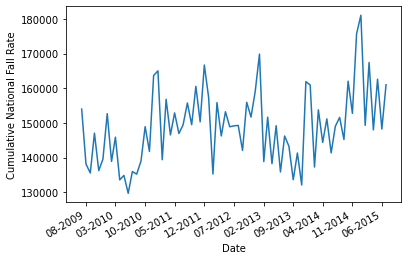

In [593]:
#this sums all the fall rates 
#to create total country-wide fall rates might need to calculate this differently 
plt.figure()
plt.plot(date_cum_fall_rates['date'], date_cum_fall_rates['scaled_fall_rate'])
ax = plt.gca()
ax.set(xlabel = 'Date', ylabel = 'Cumulative National Fall Rate')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.show()

In [391]:
total_month_falls = grouped_falls['month_count'].groupby([ "date"] ).sum().reset_index()

In [392]:
total_month_falls.head()

date  month_count
0  2009-07      44660.0
1  2009-08      42639.0
2  2009-09      42186.0
3  2009-10      43980.0
4  2009-11      42430.0

In [597]:
sum(county_pops['pop_65_up'])

42902999

In [393]:
total_month_falls['national_fall_rate'] = (total_month_falls['month_count'] / sum(county_pops['pop_65_up']))  * 100000

In [394]:
total_month_falls.head()

date  month_count  national_fall_rate
0  2009-07      44660.0          104.095287
1  2009-08      42639.0           99.384661
2  2009-09      42186.0           98.328790
3  2009-10      43980.0          102.510316
4  2009-11      42430.0           98.897515

In [395]:
total_month_falls['date'] = pd.to_datetime(total_month_falls['date'])

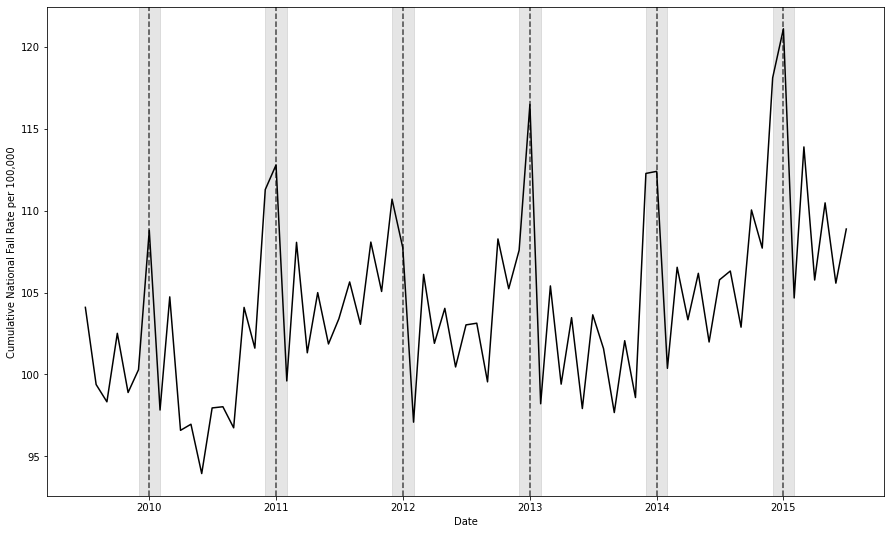

In [421]:
#this sums all the fall rates 
#to create total country-wide fall rates might need to calculate this differently 
import datetime as dt
fig, ax = plt.subplots(figsize = (15, 9))
ax.plot(total_month_falls['date'], total_month_falls['national_fall_rate'], color = 'black')
ax.set(xlabel = 'Date', ylabel = 'Cumulative National Fall Rate per 100,000')

#january lines
ax.axvline(dt.datetime(2010, 1, 1), linestyle = '--', color = 'black', alpha = 0.7)
ax.axvline(dt.datetime(2011, 1, 1), linestyle = '--', color = 'black', alpha = 0.7)
ax.axvline(dt.datetime(2012, 1, 1), linestyle = '--', color = 'black', alpha = 0.7)
ax.axvline(dt.datetime(2013, 1, 1), linestyle = '--', color = 'black', alpha = 0.7)
ax.axvline(dt.datetime(2014, 1, 1), linestyle = '--', color = 'black', alpha = 0.7)
ax.axvline(dt.datetime(2015, 1, 1), linestyle = '--', color = 'black', alpha = 0.7)

#winter shading
ax.axvspan(dt.datetime(2009, 12, 1),dt.datetime(2010, 2, 1),color = 'gray', alpha = .2, zorder = -1)
ax.axvspan(dt.datetime(2010, 12, 1),dt.datetime(2011, 2, 1),color = 'gray', alpha = .2, zorder = -1)
ax.axvspan(dt.datetime(2011, 12, 1),dt.datetime(2012, 2, 1),color = 'gray', alpha = .2, zorder = -1)
ax.axvspan(dt.datetime(2012, 12, 1),dt.datetime(2013, 2, 1),color = 'gray', alpha = .2, zorder = -1)
ax.axvspan(dt.datetime(2013, 12, 1),dt.datetime(2014, 2, 1),color = 'gray', alpha = .2, zorder = -1)
ax.axvspan(dt.datetime(2014, 12, 1),dt.datetime(2015, 2, 1),color = 'gray', alpha = .2, zorder = -1)

plt.show()

In [617]:
#merge raw monthly falls with plot_data
monthly_geodata = monthly_falls.merge(plot_data, left_on = 'fipscounty', right_on = 'id', how = 'outer')
monthly_geodata.head()

month_count_x  fipscounty_x     date    id          GEO_ID STATE COUNTY  \
0            NaN        1001.0  2010-01  1001  0500000US01001    01    001   
1           14.0        1001.0  2011-01  1001  0500000US01001    01    001   
2            NaN        1001.0  2012-01  1001  0500000US01001    01    001   
3            NaN        1001.0  2013-01  1001  0500000US01001    01    001   
4            NaN        1001.0  2014-01  1001  0500000US01001    01    001   

      NAME    LSAD  CENSUSAREA  \
0  Autauga  County     594.436   
1  Autauga  County     594.436   
2  Autauga  County     594.436   
3  Autauga  County     594.436   
4  Autauga  County     594.436   

                                            geometry  fipscounty_y  \
0  POLYGON ((-86.49677 32.34444, -86.71790 32.402...        1001.0   
1  POLYGON ((-86.49677 32.34444, -86.71790 32.402...        1001.0   
2  POLYGON ((-86.49677 32.34444, -86.71790 32.402...        1001.0   
3  POLYGON ((-86.49677 32.34444, -86.71790 32.402...        1001.0   
4  POLYGON ((-86.49677 32.34444, -86.71790 32.402...        1001.0   

   month_count_y  pop_65_up  scaled_cum_rate  nofalldata region  
0          299.0     7321.0      4084.141511         NaN  south  
1          299.0     7321.0      4084.141511         NaN  south  
2          299.0     7321.0      4084.141511         NaN  south  
3          299.0     7321.0      4084.141511         NaN  south  
4          299.0     7321.0      4084.141511         NaN  south

In [619]:
monthly_geodata_prepared = monthly_geodata[['month_count_x', 'fipscounty_x', 'date', 'pop_65_up', 'region']]
monthly_geodata_prepared.head()

month_count_x  fipscounty_x     date  pop_65_up region
0            NaN        1001.0  2010-01     7321.0  south
1           14.0        1001.0  2011-01     7321.0  south
2            NaN        1001.0  2012-01     7321.0  south
3            NaN        1001.0  2013-01     7321.0  south
4            NaN        1001.0  2014-01     7321.0  south

In [628]:
west_region = monthly_geodata_prepared[monthly_geodata_prepared['region'] == 'west']
west_region.head()

month_count_x  fipscounty_x     date  pop_65_up region
4769           11.0        4001.0  2010-01     8984.0   west
4770            NaN        4001.0  2011-01     8984.0   west
4771            NaN        4001.0  2012-01     8984.0   west
4772           11.0        4001.0  2013-01     8984.0   west
4773           11.0        4001.0  2014-01     8984.0   west

In [625]:
west_population_df = west_region.drop_duplicates(subset = ['fipscounty_x'])
west_population = west_population_df['pop_65_up'].sum()
west_population

9073432.0

In [627]:
west_cum_fall_rates = west_region['month_count_x'].groupby(["date"]).sum().reset_index()
west_cum_fall_rates.head()

KeyError: 'date'

In [611]:
plot_data.head()

id          GEO_ID STATE COUNTY      NAME    LSAD  CENSUSAREA  \
0  1001  0500000US01001    01    001   Autauga  County     594.436   
1  1009  0500000US01009    01    009    Blount  County     644.776   
2  1017  0500000US01017    01    017  Chambers  County     596.531   
3  1021  0500000US01021    01    021   Chilton  County     692.854   
4  1033  0500000US01033    01    033   Colbert  County     592.619   

                                            geometry  fipscounty  month_count  \
0  POLYGON ((-86.49677 32.34444, -86.71790 32.402...      1001.0        299.0   
1  POLYGON ((-86.57780 33.76532, -86.75914 33.840...      1009.0         60.0   
2  POLYGON ((-85.18413 32.87053, -85.12342 32.772...      1017.0        384.0   
3  POLYGON ((-86.51734 33.02057, -86.51596 32.929...      1021.0         22.0   
4  POLYGON ((-88.13999 34.58170, -88.13925 34.587...      1033.0       1167.0   

   pop_65_up  scaled_cum_rate  nofalldata region  
0     7321.0      4084.141511         NaN  south  
1     9172.0       654.164850         NaN  south  
2     6041.0      6356.563483         NaN  south  
3     6391.0       344.234079         NaN  south  
4     9701.0     12029.687661         NaN  south

In [ ]:
fig, ax = plt.subplots(2, 2, sharex='all', sharey='all')
ax[0].plot(total_month_falls['date'], total_month_falls.iloc['national_fall_rate'], color = 'black')


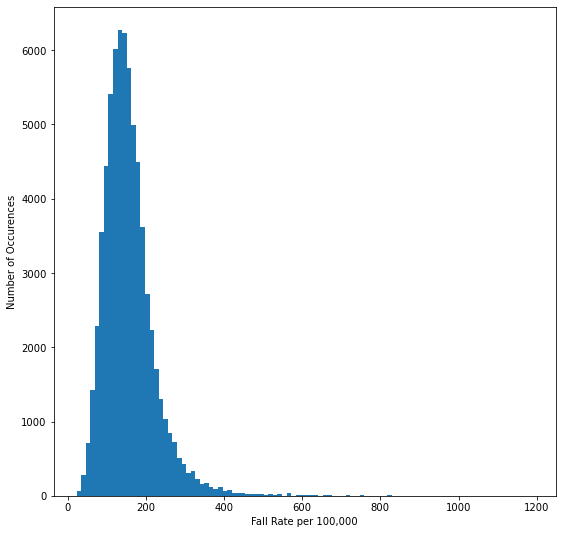

In [653]:
#what does just the distribution of fall rates look like? 
fig, ax = plt.subplots(figsize = (9, 9))
ax.hist(fall_rates_grouped['scaled_fall_rate'], bins = 100)
ax.set(xlabel = 'Fall Rate per 100,000', ylabel = 'Number of Occurences');
#do this again with analytic sample

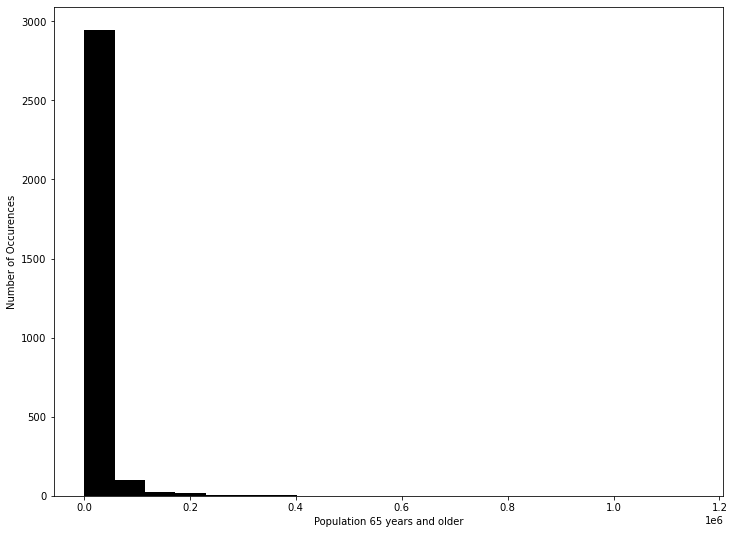

In [906]:
#population

#what does the distribution of population sizes look like? 
fig, ax = plt.subplots(figsize = (12, 9))
ax.hist(cum_fall_rates['pop_65_up'], bins = 20, color = 'black')
ax.set(xlabel = 'Population 65 years and older', ylabel = 'Number of Occurences');


In [318]:
cum_fall_rates[cum_fall_rates['pop_65_up']== max(cum_fall_rates['pop_65_up'])]
#LA county is the largest 

fipscounty  month_count  pop_65_up  scaled_cum_rate
175        6037      68179.0    1149893      5929.160365

In [321]:
#create an indicator of those counties missing fall data for the full period 
cum_fall_rates['nofalldata'] = np.where(cum_fall_rates['month_count']== 0.0, 1, 0)
cum_fall_rates.head()


fipscounty  month_count  pop_65_up  scaled_cum_rate  nofalldata
0        1001        299.0       7321      4084.141511           0
1        1003       2438.0      33782      7216.861050           0
2        1005          0.0       4180         0.000000           1
3        1007          0.0       3209         0.000000           1
4        1009         60.0       9172       654.164850           0

In [325]:
cum_fall_rates['pop_65_up'].groupby(cum_fall_rates['nofalldata']).describe()


count          mean           std    min     25%     50%  \
nofalldata                                                              
0           1775.0  22683.519437  50228.040792  926.0  5276.5  8828.0   
1           1329.0   1986.269375   1308.432601   66.0  1022.0  1743.0   

                75%        max  
nofalldata                      
0           19277.5  1149893.0  
1            2746.0    15222.0

In [762]:
#only want sociodemographics from unique counties (use ACS)
#then merge with cum_fall_rates 
acs = pd.read_csv('final_ACS_vars.csv', index_col = 0)
acs.head()

GEOID  total_pop  median_income  gini_index  pop_65_up  prop_65_85_up  \
1   1001       3828        26728.0      0.4100       7321       0.091381   
2   1003      10881        25349.0      0.4517      33782       0.104790   
3   1005       3138        16750.0      0.4608       4180       0.112440   
4   1007       1687        19545.0      0.4365       3209       0.101901   
5   1009       5106        23858.0      0.4134       9172       0.087767   

   prop_female  prop_white_nh  prop_poor  
1     0.577244       0.829531   0.067614  
2     0.536025       0.928453   0.065449  
3     0.569139       0.652392   0.150239  
4     0.550016       0.831100   0.109691  
5     0.554514       0.960423   0.092673

In [773]:
missing_descriptive = acs.merge(cum_fall_rates, left_on = 'GEOID', right_on = 'fipscounty', how = 'outer') 
missing_descriptive.head()

GEOID  total_pop  median_income  gini_index  pop_65_up_x  prop_65_85_up  \
0   1001       3828        26728.0      0.4100         7321       0.091381   
1   1003      10881        25349.0      0.4517        33782       0.104790   
2   1005       3138        16750.0      0.4608         4180       0.112440   
3   1007       1687        19545.0      0.4365         3209       0.101901   
4   1009       5106        23858.0      0.4134         9172       0.087767   

   prop_female  prop_white_nh  prop_poor  fipscounty  month_count  \
0     0.577244       0.829531   0.067614      1001.0        299.0   
1     0.536025       0.928453   0.065449      1003.0       2438.0   
2     0.569139       0.652392   0.150239      1005.0          NaN   
3     0.550016       0.831100   0.109691      1007.0          NaN   
4     0.554514       0.960423   0.092673      1009.0         60.0   

   pop_65_up_y  scaled_cum_rate  nofalldata  
0       7321.0      4084.141511         NaN  
1      33782.0      7216.861050         NaN  
2       4180.0              NaN         1.0  
3       3209.0              NaN         1.0  
4       9172.0       654.164850         NaN

In [774]:
missing_descriptive["nofalldata"].fillna(0.0, inplace = True) 

In [775]:
missing_descriptive.head()

GEOID  total_pop  median_income  gini_index  pop_65_up_x  prop_65_85_up  \
0   1001       3828        26728.0      0.4100         7321       0.091381   
1   1003      10881        25349.0      0.4517        33782       0.104790   
2   1005       3138        16750.0      0.4608         4180       0.112440   
3   1007       1687        19545.0      0.4365         3209       0.101901   
4   1009       5106        23858.0      0.4134         9172       0.087767   

   prop_female  prop_white_nh  prop_poor  fipscounty  month_count  \
0     0.577244       0.829531   0.067614      1001.0        299.0   
1     0.536025       0.928453   0.065449      1003.0       2438.0   
2     0.569139       0.652392   0.150239      1005.0          NaN   
3     0.550016       0.831100   0.109691      1007.0          NaN   
4     0.554514       0.960423   0.092673      1009.0         60.0   

   pop_65_up_y  scaled_cum_rate  nofalldata  
0       7321.0      4084.141511         0.0  
1      33782.0      7216.861050         0.0  
2       4180.0              NaN         1.0  
3       3209.0              NaN         1.0  
4       9172.0       654.164850         0.0

In [788]:
missing_descriptive['prop_white_nh'].groupby(missing_descriptive['nofalldata']).describe()


count      mean       std       min       25%       50%  \
nofalldata                                                             
0.0         1891.0  0.829927  0.226812  0.000000  0.788135  0.919765   
1.0         1329.0  0.881068  0.162081  0.085876  0.832936  0.960317   

                 75%  max  
nofalldata                 
0.0         0.968773  1.0  
1.0         0.983548  1.0

# Part 3 

## Data Analysis

In [739]:
full_df = pd.read_pickle("full_data.pkl")

First, we will conduct our analysis with only the weather variables and the fall rates. Then with the ACS variables and the fall rates. Finally, with all the variables together. 

In [740]:
full_df.head()

month_count  fipscounty     date  tavg_min  tavg_max  tavg_median  \
0          NaN        1001  2010-01      -3.9      15.6         6.70   
1         14.0        1001  2011-01      -2.3      16.1         6.70   
2          NaN        1001  2012-01       0.3      18.9        11.75   
3          NaN        1001  2013-01       5.0      20.9        12.40   
4          NaN        1001  2014-01      -7.2      11.6         3.90   

   tavg_mean  tavg_std  tmin_min  tmin_max  ...  tsun_std  median_income  \
0   5.393103  6.070769      -8.9      11.0  ...       NaN        26728.0   
1   5.823333  4.301217      -8.0      12.0  ...       NaN        26728.0   
2  11.310714  5.214747      -5.9      17.2  ...       NaN        26728.0   
3  12.092308  5.250137      -0.6      17.1  ...       NaN        26728.0   
4   3.485185  4.998669     -10.9       7.0  ...       NaN        26728.0   

   gini_index  pop_65_up  prop_65_85_up  prop_female  prop_white_nh  \
0        0.41       7321       0.091381     0.577244       0.829531   
1        0.41       7321       0.091381     0.577244       0.829531   
2        0.41       7321       0.091381     0.577244       0.829531   
3        0.41       7321       0.091381     0.577244       0.829531   
4        0.41       7321       0.091381     0.577244       0.829531   

   prop_poor  pop_density  scaled_fall_rate  
0   0.067614     6.439718               NaN  
1   0.067614     6.439718        191.230706  
2   0.067614     6.439718               NaN  
3   0.067614     6.439718               NaN  
4   0.067614     6.439718               NaN  

[5 rows x 62 columns]

In [5]:
len(full_df)

195495

In [664]:
full_df.isnull().sum()

month_count         126267
fipscounty               0
date                     0
tavg_min              6333
tavg_max              6333
                     ...  
prop_female              0
prop_white_nh            0
prop_poor                0
pop_density              0
scaled_fall_rate    126267
Length: 62, dtype: int64

In [741]:
#remove the wdir, wdgt, pressure tsun variables since so much missingness
full_df.drop(["month_count", "wdir_min", "wdir_max", "wdir_median", "wdir_mean", "wdir_std",
                                                    "wpgt_min", "wpgt_max", "wpgt_median", "wpgt_mean", "wpgt_std",
                                                    "pres_min", "pres_max", "pres_median", "pres_mean", "pres_std",
                                                   "tsun_min", "tsun_max", "tsun_median", "tsun_mean", "tsun_std"], axis = 1, inplace = True)

In [742]:
full_df.isnull().sum()

fipscounty               0
date                     0
tavg_min              6333
tavg_max              6333
tavg_median           6333
tavg_mean             6333
tavg_std              7153
tmin_min               134
tmin_max               134
tmin_median            134
tmin_mean              134
tmin_std               946
tmax_min               135
tmax_max               135
tmax_median            135
tmax_mean              135
tmax_std               947
prcp_min             79247
prcp_max             79247
prcp_median          79247
prcp_mean            79247
prcp_std             79707
snow_min            161804
snow_max            161804
snow_median         161804
snow_mean           161804
snow_std            161909
wspd_min              4905
wspd_max              4905
wspd_median           4905
wspd_mean             4905
wspd_std              5792
median_income            0
gini_index               0
pop_65_up                0
prop_65_85_up            0
prop_female              0
p

In [743]:
#easy way to deal with the precipitation and snow 
full_df['prcp_min'] = full_df['prcp_min'].replace(np.nan, 0)
full_df['prcp_max'] = full_df['prcp_max'].replace(np.nan, 0)
full_df['prcp_median'] = full_df['prcp_median'].replace(np.nan, 0)
full_df['prcp_mean'] = full_df['prcp_mean'].replace(np.nan, 0)
full_df['prcp_std'] = full_df['prcp_std'].replace(np.nan, 0)

full_df['snow_min'] = full_df['snow_min'].replace(np.nan, 0)
full_df['snow_max'] = full_df['snow_max'].replace(np.nan, 0)
full_df['snow_median'] = full_df['snow_median'].replace(np.nan, 0)
full_df['snow_mean'] = full_df['snow_mean'].replace(np.nan, 0)
full_df['snow_std'] = full_df['snow_std'].replace(np.nan, 0)


In [744]:
full_df.isnull().sum()

fipscounty               0
date                     0
tavg_min              6333
tavg_max              6333
tavg_median           6333
tavg_mean             6333
tavg_std              7153
tmin_min               134
tmin_max               134
tmin_median            134
tmin_mean              134
tmin_std               946
tmax_min               135
tmax_max               135
tmax_median            135
tmax_mean              135
tmax_std               947
prcp_min                 0
prcp_max                 0
prcp_median              0
prcp_mean                0
prcp_std                 0
snow_min                 0
snow_max                 0
snow_median              0
snow_mean                0
snow_std                 0
wspd_min              4905
wspd_max              4905
wspd_median           4905
wspd_mean             4905
wspd_std              5792
median_income            0
gini_index               0
pop_65_up                0
prop_65_85_up            0
prop_female              0
p

In [745]:
#small datasets with more interpretable variables 
small_set = full_df.drop([ 'tavg_min', 'tavg_max', 'tavg_median',  'tavg_std',
        'tmin_max', 'tmin_median', 'tmin_mean', 'tmin_std',
       'tmax_min',  'tmax_median', 'tmax_mean', 'tmax_std',
       'prcp_min', 'prcp_mean', 'prcp_median',  'prcp_std',
       'snow_min',  'snow_median', 'snow_mean', 'snow_std',
       'wspd_min',  'wspd_median', 'wspd_mean', 'wspd_std'], axis = 1, inplace = False)


In [746]:
small_set.isnull().sum()

fipscounty               0
date                     0
tavg_mean             6333
tmin_min               134
tmax_max               135
prcp_max                 0
snow_max                 0
wspd_max              4905
median_income            0
gini_index               0
pop_65_up                0
prop_65_85_up            0
prop_female              0
prop_white_nh            0
prop_poor                0
pop_density              0
scaled_fall_rate    126267
dtype: int64

In [50]:
#maybe first remove missing fall rates then address the missing weather variables 
no_missing_falls = small_set.dropna(subset = ['scaled_fall_rate'])

In [51]:
no_missing_falls.isnull().sum()

date                   0
tavg_mean           1731
tmin_min              15
tmax_max              16
prcp_mean              0
snow_max               0
wspd_max            1276
median_income          0
gini_index             0
pop_65_up              0
prop_65_85_up          0
prop_female            0
prop_white_nh          0
prop_poor              0
pop_density            0
scaled_fall_rate       0
dtype: int64

In [14]:
no_missing_falls[no_missing_falls['tavg_mean'].isnull()]

fipscounty     date  tavg_mean  tmin_min  tmax_max  prcp_mean  \
739           1021  2010-12        NaN      -8.9      22.8   1.164516   
1604          1047  2010-01        NaN     -12.2      20.6   4.525806   
1605          1047  2011-01        NaN     -10.6      23.9   3.770968   
1606          1047  2012-01        NaN      -8.9      24.4   5.426667   
1607          1047  2013-01        NaN      -4.4      23.3   5.790323   
...            ...      ...        ...       ...       ...        ...   
187481       54059  2012-04        NaN       0.4      29.6   2.656667   
187494       54059  2013-06        NaN      12.3      32.7   3.690000   
187506       54059  2011-08        NaN      15.8      35.3   0.632258   
187526       54059  2013-11        NaN      -9.3      22.0   2.866667   
187531       54059  2012-12        NaN      -7.0      23.3   4.780645   

        snow_max  wspd_max  median_income  gini_index  pop_65_up  \
739          0.0      21.2        23499.0      0.4517       6391   
1604         0.0       NaN        16162.0      0.5281       6319   
1605         0.0       NaN        16162.0      0.5281       6319   
1606         0.0       NaN        16162.0      0.5281       6319   
1607         0.0       NaN        16162.0      0.5281       6319   
...          ...       ...            ...         ...        ...   
187481       0.0       NaN        20283.0      0.4646       3839   
187494       0.0       NaN        20283.0      0.4646       3839   
187506       0.0       NaN        20283.0      0.4646       3839   
187526       0.0       NaN        20283.0      0.4646       3839   
187531       0.0       NaN        20283.0      0.4646       3839   

        prop_65_85_up  prop_female  prop_white_nh  prop_poor  pop_density  \
739          0.093882     0.555625       0.900485   0.109685     4.604145   
1604         0.109669     0.586327       0.463048   0.162051     3.264551   
1605         0.109669     0.586327       0.463048   0.162051     3.264551   
1606         0.109669     0.586327       0.463048   0.162051     3.264551   
1607         0.109669     0.586327       0.463048   0.162051     3.264551   
...               ...          ...            ...        ...          ...   
187481       0.091170     0.544934       0.953634   0.120344     5.535217   
187494       0.091170     0.544934       0.953634   0.120344     5.535217   
187506       0.091170     0.544934       0.953634   0.120344     5.535217   
187526       0.091170     0.544934       0.953634   0.120344     5.535217   
187531       0.091170     0.544934       0.953634   0.120344     5.535217   

        scaled_fall_rate  
739           172.117040  
1604          221.554043  
1605          284.855199  
1606          205.728755  
1607          189.903466  
...                  ...  
187481        312.581401  
187494        286.532951  
187506        286.532951  
187526        286.532951  
187531        338.629852  

[1731 rows x 17 columns]

In [662]:
no_missing_falls.describe()

fipscounty     tavg_mean      tmin_min      tmax_max     prcp_mean  \
count  69228.000000  67497.000000  69213.000000  69212.000000  69228.000000   
mean   30332.691137     13.718331      0.661666     27.184074      1.242195   
std    15533.872466      9.614650     11.259671      8.301040     18.496866   
min     1001.000000    -19.066667    -43.800000    -13.000000      0.000000   
25%    18003.000000      6.574074     -6.600000     22.000000      0.000000   
50%    32510.000000     14.920000      0.600000     28.900000      0.068750   
75%    42121.000000     21.674074      9.200000     33.300000      1.631332   
max    56033.000000     36.110345     26.700000     49.400000   4790.350000   

           snow_max      wspd_max  median_income    gini_index     pop_65_up  \
count  69228.000000  67952.000000   69228.000000  69228.000000  6.922800e+04   
mean       8.005561     21.538576   25918.125339      0.446219  3.759000e+04   
std       45.534180      7.348967    5572.817164      0.030765  7.428052e+04   
min        0.000000      0.000000   12861.000000      0.352500  9.260000e+02   
25%        0.000000     16.200000   22084.000000      0.425300  1.023300e+04   
50%        0.000000     21.000000   25041.000000      0.445300  1.652300e+04   
75%        0.000000     26.100000   28341.000000      0.465400  3.637200e+04   
max      914.000000     70.200000   59876.000000      0.597500  1.149893e+06   

       prop_65_85_up   prop_female  prop_white_nh     prop_poor   pop_density  \
count   69228.000000  69228.000000   69228.000000  69228.000000  69228.000000   
mean        0.129613      0.561860       0.858712      0.084842     48.551532   
std         0.023990      0.018220       0.140165      0.030447    149.843725   
min         0.046436      0.469969       0.026929      0.023863      0.036584   
25%         0.112768      0.551255       0.805243      0.064863      8.205730   
50%         0.129233      0.563376       0.909124      0.079035     17.013867   
75%         0.146205      0.573502       0.958583      0.097731     36.285198   
max         0.238095      0.621529       1.000000      0.339693   3579.175610   

       scaled_fall_rate  
count      69228.000000  
mean         157.147386  
std           67.253734  
min            1.217505  
25%          114.198627  
50%          147.091212  
75%          185.844820  
max         1190.476190

In [747]:
#find a better way to deal with the missingness?
#I don't think this changes distribution much, just drop 
no_missing_data = small_set.dropna()

In [672]:
no_missing_data.describe()

fipscounty     tavg_mean      tmin_min      tmax_max     prcp_mean  \
count  66945.000000  66945.000000  66945.000000  66945.000000  66945.000000   
mean   30428.904369     13.727632      0.697405     27.207233      1.192500   
std    15495.299891      9.611165     11.253450      8.295228     18.802968   
min     1001.000000    -19.066667    -37.800000    -13.000000      0.000000   
25%    18005.000000      6.590000     -6.600000     22.000000      0.000000   
50%    33003.000000     14.927586      0.600000     28.900000      0.047368   
75%    42121.000000     21.686667      9.400000     33.300000      1.493333   
max    56033.000000     36.110345     26.700000     49.400000   4790.350000   

           snow_max      wspd_max  median_income    gini_index     pop_65_up  \
count  66945.000000  66945.000000   66945.000000  66945.000000  6.694500e+04   
mean       7.761297     21.547019   25936.348480      0.445919  3.726828e+04   
std       44.711290      7.351409    5581.851296      0.030795  7.429048e+04   
min        0.000000      0.000000   12861.000000      0.352500  1.008000e+03   
25%        0.000000     16.200000   22123.000000      0.425100  1.022800e+04   
50%        0.000000     21.000000   25057.000000      0.444600  1.644500e+04   
75%        0.000000     26.200000   28169.000000      0.464900  3.633400e+04   
max      914.000000     70.200000   59876.000000      0.597500  1.149893e+06   

       prop_65_85_up   prop_female  prop_white_nh     prop_poor   pop_density  \
count   66945.000000  66945.000000   66945.000000  66945.000000  66945.000000   
mean        0.129568      0.561835       0.859050      0.084612     48.366273   
std         0.023939      0.018228       0.139238      0.030226    151.017829   
min         0.049210      0.469969       0.047547      0.023863      0.133814   
25%         0.112735      0.551216       0.807577      0.064569      8.296301   
50%         0.129507      0.563373       0.909124      0.078996     17.013867   
75%         0.146109      0.573519       0.958305      0.097693     36.169832   
max         0.238095      0.621529       1.000000      0.339693   3579.175610   

       scaled_fall_rate  
count      66945.000000  
mean         157.010741  
std           67.252725  
min            1.217505  
25%          114.081643  
50%          146.949136  
75%          185.597624  
max         1190.476190

In [664]:
len(no_missing_data)

66945

In [643]:
len(no_missing_data['fipscounty'].unique())

1733

In [630]:
len(no_missing_data['date'].unique())

73

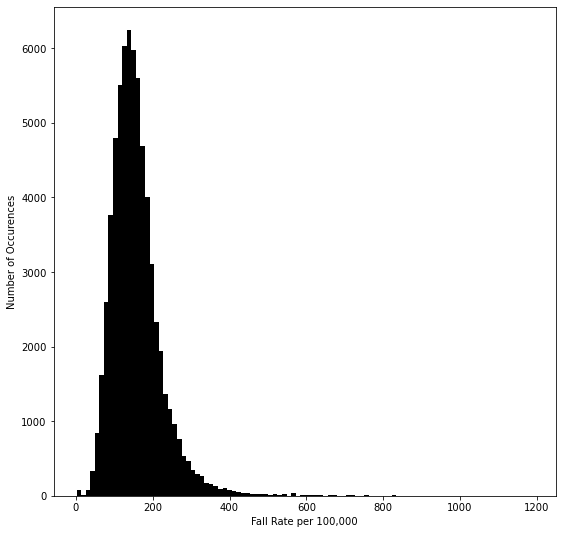

In [905]:
fig, ax = plt.subplots(figsize = (9, 9))
ax.hist(no_missing_data['scaled_fall_rate'], bins = 100, color = 'black')
ax.set(xlabel = 'Fall Rate per 100,000', ylabel = 'Number of Occurences');

In [673]:
len(no_missing_data[no_missing_data['scaled_fall_rate']<=200])/ len(no_missing_data)

0.8130704309507805

In [656]:
no_missing_data[no_missing_data['scaled_fall_rate']== max(no_missing_data['scaled_fall_rate'])]

fipscounty     date  tavg_mean  tmin_min  tmax_max  prcp_mean  \
60537       20183  2014-01  -2.593103     -22.5      18.8        0.0   

       snow_max  wspd_max  median_income  gini_index  pop_65_up  \
60537       0.0      34.2        24357.0      0.4842       1008   

       prop_65_85_up  prop_female  prop_white_nh  prop_poor  pop_density  \
60537       0.207341     0.553571       0.985119   0.109127     1.017349   

       scaled_fall_rate  
60537        1190.47619

In [748]:
no_missing_data['month'] = pd.DatetimeIndex(no_missing_data['date']).month

/var/folders/gy/w5ghr6zn5jn84fzh3qwwsnbm0000gn/T/ipykernel_51792/437512913.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_missing_data['month'] = pd.DatetimeIndex(no_missing_data['date']).month


In [749]:
no_missing_data.to_pickle("no_missing_data.pkl")

In [217]:
full_month_count = no_missing_data.groupby(['month']).count().reset_index()

In [218]:
full_month_count

month  date  tavg_mean  tmin_min  tmax_max  prcp_mean  snow_max  wspd_max  \
0       1  5680       5680      5680      5680       5680      5680      5680   
1       2  5329       5329      5329      5329       5329      5329      5329   
2       3  5583       5583      5583      5583       5583      5583      5583   
3       4  5425       5425      5425      5425       5425      5425      5425   
4       5  5558       5558      5558      5558       5558      5558      5558   
5       6  5430       5430      5430      5430       5430      5430      5430   
6       7  6491       6491      6491      6491       6491      6491      6491   
7       8  5467       5467      5467      5467       5467      5467      5467   
8       9  5369       5369      5369      5369       5369      5369      5369   
9      10  5563       5563      5563      5563       5563      5563      5563   
10     11  5390       5390      5390      5390       5390      5390      5390   
11     12  5660       5660      5660      5660       5660      5660      5660   

    median_income  gini_index  pop_65_up  prop_65_85_up  prop_female  \
0            5680        5680       5680           5680         5680   
1            5329        5329       5329           5329         5329   
2            5583        5583       5583           5583         5583   
3            5425        5425       5425           5425         5425   
4            5558        5558       5558           5558         5558   
5            5430        5430       5430           5430         5430   
6            6491        6491       6491           6491         6491   
7            5467        5467       5467           5467         5467   
8            5369        5369       5369           5369         5369   
9            5563        5563       5563           5563         5563   
10           5390        5390       5390           5390         5390   
11           5660        5660       5660           5660         5660   

    prop_white_nh  prop_poor  pop_density  scaled_fall_rate  
0            5680       5680         5680              5680  
1            5329       5329         5329              5329  
2            5583       5583         5583              5583  
3            5425       5425         5425              5425  
4            5558       5558         5558              5558  
5            5430       5430         5430              5430  
6            6491       6491         6491              6491  
7            5467       5467         5467              5467  
8            5369       5369         5369              5369  
9            5563       5563         5563              5563  
10           5390       5390         5390              5390  
11           5660       5660         5660              5660

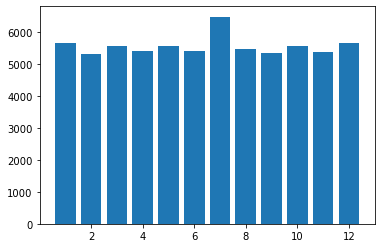

In [219]:
plt.bar(full_month_count['month'], full_month_count['date']);

In [229]:
import sklearn 
from sklearn import tree, metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from dtreeviz.trees import *


In [790]:
#want to take out a year's worth of observations to predict that instead, set index to datetime
#this allows us to perform cross validation while perserving the timeseries structure 
no_missing_data = pd.read_pickle('no_missing_data.pkl')
no_missing_data['date'] = pd.to_datetime(no_missing_data['date'])
time_df = no_missing_data.set_index('date')

In [793]:
no_missing_data.describe()

fipscounty     tavg_mean      tmin_min      tmax_max      prcp_max  \
count  66945.000000  66945.000000  66945.000000  66945.000000  66945.000000   
mean   30428.904369     13.727632      0.697405     27.207233     11.671616   
std    15495.299891      9.611165     11.253450      8.295228     27.130052   
min     1001.000000    -19.066667    -37.800000    -13.000000      0.000000   
25%    18005.000000      6.590000     -6.600000     22.000000      0.000000   
50%    33003.000000     14.927586      0.600000     28.900000      0.500000   
75%    42121.000000     21.686667      9.400000     33.300000     17.300000   
max    56033.000000     36.110345     26.700000     49.400000   4790.400000   

           snow_max      wspd_max  median_income    gini_index     pop_65_up  \
count  66945.000000  66945.000000   66945.000000  66945.000000  6.694500e+04   
mean       7.761297     21.547019   25936.348480      0.445919  3.726828e+04   
std       44.711290      7.351409    5581.851296      0.030795  7.429048e+04   
min        0.000000      0.000000   12861.000000      0.352500  1.008000e+03   
25%        0.000000     16.200000   22123.000000      0.425100  1.022800e+04   
50%        0.000000     21.000000   25057.000000      0.444600  1.644500e+04   
75%        0.000000     26.200000   28169.000000      0.464900  3.633400e+04   
max      914.000000     70.200000   59876.000000      0.597500  1.149893e+06   

       prop_65_85_up   prop_female  prop_white_nh     prop_poor   pop_density  \
count   66945.000000  66945.000000   66945.000000  66945.000000  66945.000000   
mean        0.129568      0.561835       0.859050      0.084612     48.366273   
std         0.023939      0.018228       0.139238      0.030226    151.017829   
min         0.049210      0.469969       0.047547      0.023863      0.133814   
25%         0.112735      0.551216       0.807577      0.064569      8.296301   
50%         0.129507      0.563373       0.909124      0.078996     17.013867   
75%         0.146109      0.573519       0.958305      0.097693     36.169832   
max         0.238095      0.621529       1.000000      0.339693   3579.175610   

       scaled_fall_rate         month  
count      66945.000000  66945.000000  
mean         157.010741      6.505206  
std           67.252725      3.439331  
min            1.217505      1.000000  
25%          114.081643      4.000000  
50%          146.949136      7.000000  
75%          185.597624      9.000000  
max         1190.476190     12.000000

In [791]:
time_df.head()

fipscounty  tavg_mean  tmin_min  tmax_max  prcp_max  snow_max  \
date                                                                        
2011-01-01        1001   5.823333      -8.0      23.0       0.0       0.0   
2010-02-01        1001   6.296154      -4.4      21.6       0.0       0.0   
2012-02-01        1001  12.468966      -4.5      25.6       0.0       0.0   
2013-02-01        1001  10.213333      -2.3      22.4       0.0       0.0   
2015-02-01        1001   6.696000      -6.1      20.2       0.0       0.0   

            wspd_max  median_income  gini_index  pop_65_up  prop_65_85_up  \
date                                                                        
2011-01-01      16.8        26728.0        0.41       7321       0.091381   
2010-02-01      16.0        26728.0        0.41       7321       0.091381   
2012-02-01      22.2        26728.0        0.41       7321       0.091381   
2013-02-01      12.9        26728.0        0.41       7321       0.091381   
2015-02-01      19.2        26728.0        0.41       7321       0.091381   

            prop_female  prop_white_nh  prop_poor  pop_density  \
date                                                             
2011-01-01     0.577244       0.829531   0.067614     6.439718   
2010-02-01     0.577244       0.829531   0.067614     6.439718   
2012-02-01     0.577244       0.829531   0.067614     6.439718   
2013-02-01     0.577244       0.829531   0.067614     6.439718   
2015-02-01     0.577244       0.829531   0.067614     6.439718   

            scaled_fall_rate  month  
date                                 
2011-01-01        191.230706      1  
2010-02-01        163.912034      2  
2012-02-01        163.912034      2  
2013-02-01        163.912034      2  
2015-02-01        163.912034      2

In [269]:
time_df.isnull().sum()

tavg_mean           0
tmin_min            0
tmax_max            0
prcp_mean           0
snow_max            0
wspd_max            0
median_income       0
gini_index          0
pop_65_up           0
prop_65_85_up       0
prop_female         0
prop_white_nh       0
prop_poor           0
pop_density         0
scaled_fall_rate    0
dtype: int64

## Weather Decision Tree

https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9


https://towardsdatascience.com/time-series-modeling-using-scikit-pandas-and-numpy-682e3b8db8d1 


In [921]:
def analysis_pipeline(model_type, hyperparam_grid, scoring_metric, train_x, train_y, test_x, test_y):
    """
    Pipeline for the decision tree/random forest pipeline (could be expanded)
    model_type is either "DT" or "RF" 
    Prints accuracy metrics for train/test sets and DT or features importance 
    Returns the best model 
    """
    
    if model_type == 'DT': 
        model = DecisionTreeRegressor(random_state =42)
    
    if model_type == 'RF': 
        model = RandomForestRegressor(random_state =42)
    
    
    tscv = TimeSeriesSplit(n_splits=4)
    
    grid_metric = 'neg_' + scoring_metric

    grid_search = GridSearchCV(estimator=model, cv=tscv, param_grid=hyperparam_grid, scoring = grid_metric)

    grid_search.fit(train_x, train_y)
    
    print("Best Parameters for Model: ", grid_search.best_params_)
    best_model = grid_search.best_estimator_
    #print('Best : ', best_model)   
    
    #train error
    best_score = grid_search.best_score_
    print('Train Error is: ', best_score)
    
    #test error
    y_pred = best_model.predict(test_x)
    
    #can adjust this for different error metrics 
    if scoring_metric == 'mean_absolute_percentage_error':
        print("Test Error is: %.4f" % metrics.mean_absolute_percentage_error(test_y, y_pred))
    
    if scoring_metric == 'mean_absolute_error':
        print("Test Error is: %.4f" % metrics.mean_absolute_error(test_y, y_pred))
        
    if scoring_metric == 'mean_squared_error':
        print("Test Error is: %.4f" % metrics.mean_squared_error(test_y, y_pred,squared = True))
    
    if scoring_metric == 'root_mean_squared_error':
        print("Test Error is: %.4f" % metrics.mean_squared_error(test_y, y_pred, squared = False))
        
        
        
    
    if model_type == 'DT':
        DT_figure = plt.figure(figsize=(25,20))
        _ = tree.plot_tree(best_model, feature_names=train_x.columns, filled=True)
    
    if model_type == 'RF': 
        
        #print one tree
        one_tree = best_model.estimators_[2]
        
        DT_figure = plt.figure(figsize=(25,20))
        _ = tree.plot_tree(one_tree, feature_names=train_x.columns, filled=True)
        
        imp = best_model.feature_importances_

        features = train_x.columns
        
        for i in range(len(imp)): 
            print("Feature: ", features[i], "Importantance: ", imp[i])


        indices = np.argsort(imp)

        plt.figure(figsize=(7,7))
        plt.title('Feature Importances')
        plt.barh(range(len(indices)), imp[indices], color='black', align='center')
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()
        
        
    
    return best_model

In [758]:
weather_vars = ['tavg_mean', 'tmin_min', 'tmax_max', 'prcp_max', 'snow_max', 'wspd_max']    
demo_vars = ['prop_65_85_up', 'prop_female', 'prop_white_nh', 'pop_density']
econ_vars = ['median_income', 'gini_index', 'prop_poor']

In [694]:
def train_test_split(time_df, var_list, extras):
    """
    Takes a time_df and list of columns to remove, creates list of dataframes with train/test split (x & y sets)
    """
    
    full_var_list = var_list + extras
    x_set_vars = time_df[full_var_list]
    print(len(x_set_vars))

    X_train = x_set_vars.loc[:'2013']
    print("Length Training Set: ", len(X_train))
    print("Training Set Ratio: ", len(X_train)/len(x_set_vars))

    y_train = time_df.loc[:'2013', 'scaled_fall_rate']

    X_test = x_set_vars.loc['2014':, : ]
    print("Length Testing Set: ", len(X_test))
    print("Testing Set Ratio: ", len(X_test)/len(x_set_vars))

    y_test = time_df.loc['2014':, 'scaled_fall_rate']
    
    return([X_train, y_train, X_test, y_test])

## Random Forest with one-hot encoded regions, then latitude/longitude

In [989]:
no_missing_data = pd.read_pickle("no_missing_data.pkl")
no_missing_data.head()

fipscounty     date  tavg_mean  tmin_min  tmax_max  prcp_max  snow_max  \
1         1001  2011-01   5.823333      -8.0      23.0       0.0       0.0   
6         1001  2010-02   6.296154      -4.4      21.6       0.0       0.0   
8         1001  2012-02  12.468966      -4.5      25.6       0.0       0.0   
9         1001  2013-02  10.213333      -2.3      22.4       0.0       0.0   
11        1001  2015-02   6.696000      -6.1      20.2       0.0       0.0   

    wspd_max  median_income  gini_index  pop_65_up  prop_65_85_up  \
1       16.8        26728.0        0.41       7321       0.091381   
6       16.0        26728.0        0.41       7321       0.091381   
8       22.2        26728.0        0.41       7321       0.091381   
9       12.9        26728.0        0.41       7321       0.091381   
11      19.2        26728.0        0.41       7321       0.091381   

    prop_female  prop_white_nh  prop_poor  pop_density  scaled_fall_rate  \
1      0.577244       0.829531   0.067614     6.439718        191.230706   
6      0.577244       0.829531   0.067614     6.439718        163.912034   
8      0.577244       0.829531   0.067614     6.439718        163.912034   
9      0.577244       0.829531   0.067614     6.439718        163.912034   
11     0.577244       0.829531   0.067614     6.439718        163.912034   

    month  
1       1  
6       2  
8       2  
9       2  
11      2

In [1067]:
len(no_missing_data)

66945

In [990]:
#add regions + county latitude/longitude centroids 
#from saved US counties pickle 
US_counties = pd.read_pickle("US_counties.pkl")
US_counties.head()

id          GEO_ID STATE COUNTY      NAME    LSAD  CENSUSAREA  \
0  1001  0500000US01001    01    001   Autauga  County     594.436   
1  1009  0500000US01009    01    009    Blount  County     644.776   
2  1017  0500000US01017    01    017  Chambers  County     596.531   
3  1021  0500000US01021    01    021   Chilton  County     692.854   
4  1033  0500000US01033    01    033   Colbert  County     592.619   

                                            geometry        lon        lat  
0  POLYGON ((-86.49677 32.34444, -86.71790 32.402... -86.641196  32.536153  
1  POLYGON ((-86.57780 33.76532, -86.75914 33.840... -86.569756  33.985248  
2  POLYGON ((-85.18413 32.87053, -85.12342 32.772... -85.389924  32.911594  
3  POLYGON ((-86.51734 33.02057, -86.51596 32.929... -86.719793  32.850253  
4  POLYGON ((-88.13999 34.58170, -88.13925 34.587... -87.805890  34.701644

In [991]:
#https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf

#regions key 
west_codes = ['53', '41', '06', '30', '16', '56', '32', '49', '08', '04', '35']
midwest_codes = ['38', '46', '31', '20', '27', '19', '29', '55', '17', '18', '26', '39']
south_codes = ['48', '40', '05', '22', '28', '01', '13', '12', '45', '37', '21', '47', '54','24', '10', '51', '11']
northeast_codes = ['42', '36', '34', '50', '33', '23', '09', '44', '25']

US_counties['region'] = np.where(US_counties['STATE'].isin(west_codes), 'west',
                               np.where(US_counties['STATE'].isin(midwest_codes), 'midwest',
                                        np.where(US_counties['STATE'].isin(south_codes), 'south',
                                                 np.where(US_counties['STATE'].isin(northeast_codes), 'northeast',0
                              ))))


In [992]:
US_counties.drop(['GEO_ID', 'STATE', 'COUNTY', 'NAME', 'LSAD', 'CENSUSAREA', 'geometry'], axis =1 , inplace=True)
US_counties.head()

id        lon        lat region
0  1001 -86.641196  32.536153  south
1  1009 -86.569756  33.985248  south
2  1017 -85.389924  32.911594  south
3  1021 -86.719793  32.850253  south
4  1033 -87.805890  34.701644  south

In [998]:
geographic_falls = no_missing_data.merge(US_counties, left_on=['fipscounty'], right_on=['id'], how ='inner')
geographic_falls.head()

fipscounty     date  tavg_mean  tmin_min  tmax_max  prcp_max  snow_max  \
0        1001  2011-01   5.823333      -8.0      23.0       0.0       0.0   
1        1001  2010-02   6.296154      -4.4      21.6       0.0       0.0   
2        1001  2012-02  12.468966      -4.5      25.6       0.0       0.0   
3        1001  2013-02  10.213333      -2.3      22.4       0.0       0.0   
4        1001  2015-02   6.696000      -6.1      20.2       0.0       0.0   

   wspd_max  median_income  gini_index  ...  prop_female  prop_white_nh  \
0      16.8        26728.0        0.41  ...     0.577244       0.829531   
1      16.0        26728.0        0.41  ...     0.577244       0.829531   
2      22.2        26728.0        0.41  ...     0.577244       0.829531   
3      12.9        26728.0        0.41  ...     0.577244       0.829531   
4      19.2        26728.0        0.41  ...     0.577244       0.829531   

   prop_poor  pop_density  scaled_fall_rate  month    id        lon  \
0   0.067614     6.439718        191.230706      1  1001 -86.641196   
1   0.067614     6.439718        163.912034      2  1001 -86.641196   
2   0.067614     6.439718        163.912034      2  1001 -86.641196   
3   0.067614     6.439718        163.912034      2  1001 -86.641196   
4   0.067614     6.439718        163.912034      2  1001 -86.641196   

         lat  region  
0  32.536153   south  
1  32.536153   south  
2  32.536153   south  
3  32.536153   south  
4  32.536153   south  

[5 rows x 22 columns]

In [997]:
len(geographic_falls)

66945

In [995]:
geographic_falls.drop(['id'], axis=1, inplace = True)

In [756]:
#get descriptive statistics of all the variables by region 
#then run ANOVA to see if these are the same 
#could try kmeans (4) weather, demographics, SES to see if similar groupings 
grouped_regions = geographic_falls.groupby(['region'])

In [ ]:
grouped_regions

In [757]:
grouped_regions.describe()

fipscounty                                                         \
               count          mean           std      min      25%      50%   
region                                                                        
midwest      17203.0  29361.141138  11980.983567  17001.0  18145.0  26151.0   
northeast    10330.0  35101.732236   8778.279936   9001.0  34001.0  36059.0   
south        30936.0  31141.278866  17073.536712   1001.0  13121.0  37067.0   
west          8476.0  24301.061232  19466.298666   4001.0   6071.0  16019.0   

                            tavg_mean             ...         lon              \
               75%      max     count       mean  ...         75%         max   
region                                            ...                           
midwest    39045.0  55141.0   17203.0  10.436019  ...  -84.601356  -80.748551   
northeast  42047.0  50027.0   10330.0  10.217088  ...  -72.641143  -67.627101   
south      48032.5  54109.0   30936.0  16.912792  ...  -80.575715  -75.331133   
west       41047.0  56033.0    8476.0  13.061452  ... -111.790448 -103.346924   

               lat                                                        \
             count       mean       std        min        25%        50%   
region                                                                     
midwest    17203.0  41.242005  2.242786  36.207545  39.456910  41.245429   
northeast  10330.0  41.724974  1.412209  39.146976  40.682192  41.459774   
south      30936.0  34.110954  3.170342  25.372053  32.105379  34.687041   
west        8476.0  40.312237  4.766715  31.879364  36.607845  39.329117   

                                 
                 75%        max  
region                           
midwest    42.668420  48.222350  
northeast  42.635650  46.660446  
south      36.291237  40.522090  
west       44.904087  48.549008  

[4 rows x 152 columns]

In [861]:
len(geographic_falls[geographic_falls['region'] == 'northeast'])

10330

In [862]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

#perform two-way ANOVA
anova_falls = ols('scaled_fall_rate ~ C(region)', data=geographic_falls).fit()
print(sm.stats.anova_lm(anova_falls, typ=2).round(4))


                 sum_sq       df          F  PR(>F)
C(region)  2.295178e+07      3.0  1830.1688     0.0
Residual   2.798312e+08  66941.0        NaN     NaN


In [ ]:
geographic_falls

In [999]:
#by region
ohe_counties = pd.get_dummies(data=geographic_falls, columns=['region'])
ohe_counties['date'] = pd.to_datetime(ohe_counties['date'])
ohe_counties = ohe_counties.set_index('date')
ohe_counties.head()

fipscounty  tavg_mean  tmin_min  tmax_max  prcp_max  snow_max  \
date                                                                        
2011-01-01        1001   5.823333      -8.0      23.0       0.0       0.0   
2010-02-01        1001   6.296154      -4.4      21.6       0.0       0.0   
2012-02-01        1001  12.468966      -4.5      25.6       0.0       0.0   
2013-02-01        1001  10.213333      -2.3      22.4       0.0       0.0   
2015-02-01        1001   6.696000      -6.1      20.2       0.0       0.0   

            wspd_max  median_income  gini_index  pop_65_up  ...  pop_density  \
date                                                        ...                
2011-01-01      16.8        26728.0        0.41       7321  ...     6.439718   
2010-02-01      16.0        26728.0        0.41       7321  ...     6.439718   
2012-02-01      22.2        26728.0        0.41       7321  ...     6.439718   
2013-02-01      12.9        26728.0        0.41       7321  ...     6.439718   
2015-02-01      19.2        26728.0        0.41       7321  ...     6.439718   

            scaled_fall_rate  month    id        lon        lat  \
date                                                              
2011-01-01        191.230706      1  1001 -86.641196  32.536153   
2010-02-01        163.912034      2  1001 -86.641196  32.536153   
2012-02-01        163.912034      2  1001 -86.641196  32.536153   
2013-02-01        163.912034      2  1001 -86.641196  32.536153   
2015-02-01        163.912034      2  1001 -86.641196  32.536153   

            region_midwest  region_northeast  region_south  region_west  
date                                                                     
2011-01-01               0                 0             1            0  
2010-02-01               0                 0             1            0  
2012-02-01               0                 0             1            0  
2013-02-01               0                 0             1            0  
2015-02-01               0                 0             1            0  

[5 rows x 24 columns]

In [1001]:
regions_results = train_test_split(ohe_counties, [], ['region_midwest', 'region_northeast', 'region_south', 'region_west'])
regions_X_train = regions_results[0]
regions_y_train = regions_results[1]
regions_X_test = regions_results[2]
regions_y_test = regions_results[3]
#30% testing set

66945
Length Training Set:  48938
Training Set Ratio:  0.7310179998506237
Length Testing Set:  18007
Testing Set Ratio:  0.26898200014937634


Best Parameters for Model:  {'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 50}
Train Error is:  -0.33520852967574677
Test Error is: 0.3676
Feature:  region_midwest Importantance:  0.024597370081564884
Feature:  region_northeast Importantance:  0.16653123234829517
Feature:  region_south Importantance:  0.005500741717187726
Feature:  region_west Importantance:  0.8033706558529523


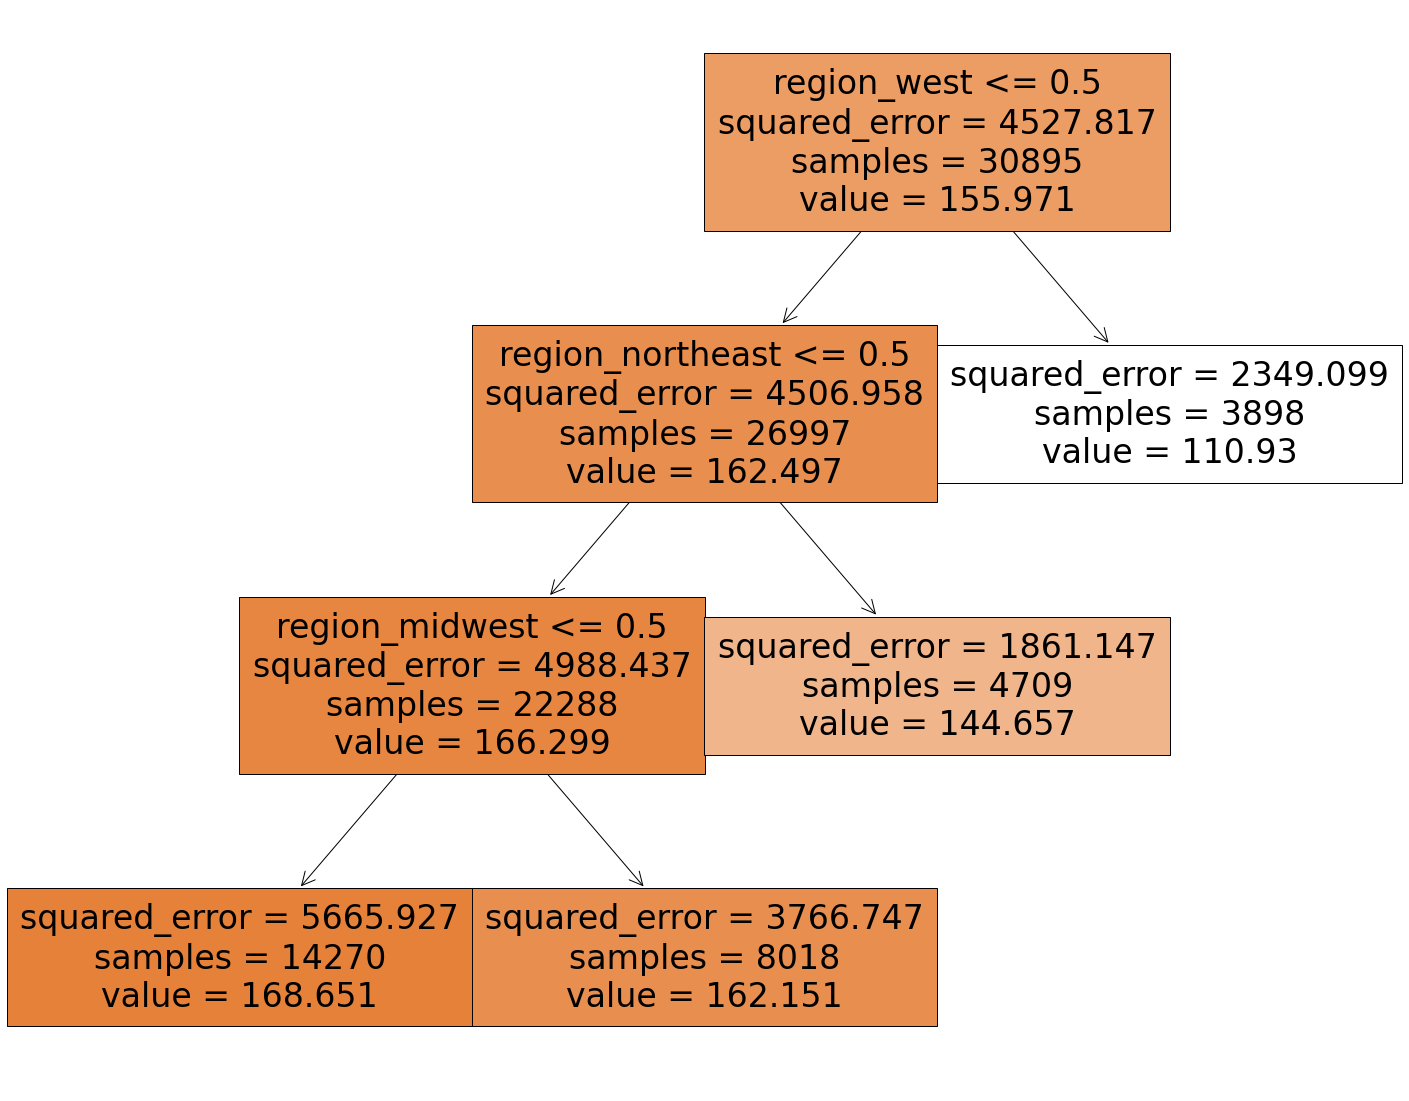

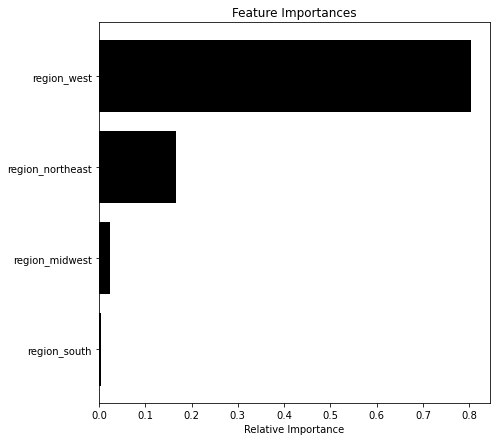

In [1002]:
region_rt = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', regions_X_train, regions_y_train, regions_X_test, regions_y_test )

In [1003]:
regions_weather_results = train_test_split(ohe_counties, weather_vars, ['region_midwest', 'region_northeast', 'region_south', 'region_west'])
regions_weather_X_train = regions_weather_results[0]
regions_weather_y_train = regions_weather_results[1]
regions_weather_X_test = regions_weather_results[2]
regions_weather_y_test = regions_weather_results[3]
#30% testing set

66945
Length Training Set:  48938
Training Set Ratio:  0.7310179998506237
Length Testing Set:  18007
Testing Set Ratio:  0.26898200014937634


In [697]:
rf_param_search = { 
    "max_depth": [2, 3, 4, 5],
    "min_samples_leaf": [1, 5, 10],  
    'n_estimators': [50, 100, 200]
}

Best Parameters for Model:  {'max_depth': 2, 'min_samples_leaf': 10, 'n_estimators': 50}
Train Error is:  -0.335886996637433
Test Error is: 0.3633
Feature:  tavg_mean Importantance:  0.0
Feature:  tmin_min Importantance:  0.0482825123213728
Feature:  tmax_max Importantance:  0.0
Feature:  prcp_max Importantance:  0.0
Feature:  snow_max Importantance:  0.0
Feature:  wspd_max Importantance:  0.0
Feature:  region_midwest Importantance:  0.0
Feature:  region_northeast Importantance:  0.16340890802217906
Feature:  region_south Importantance:  0.0
Feature:  region_west Importantance:  0.7883085796564482


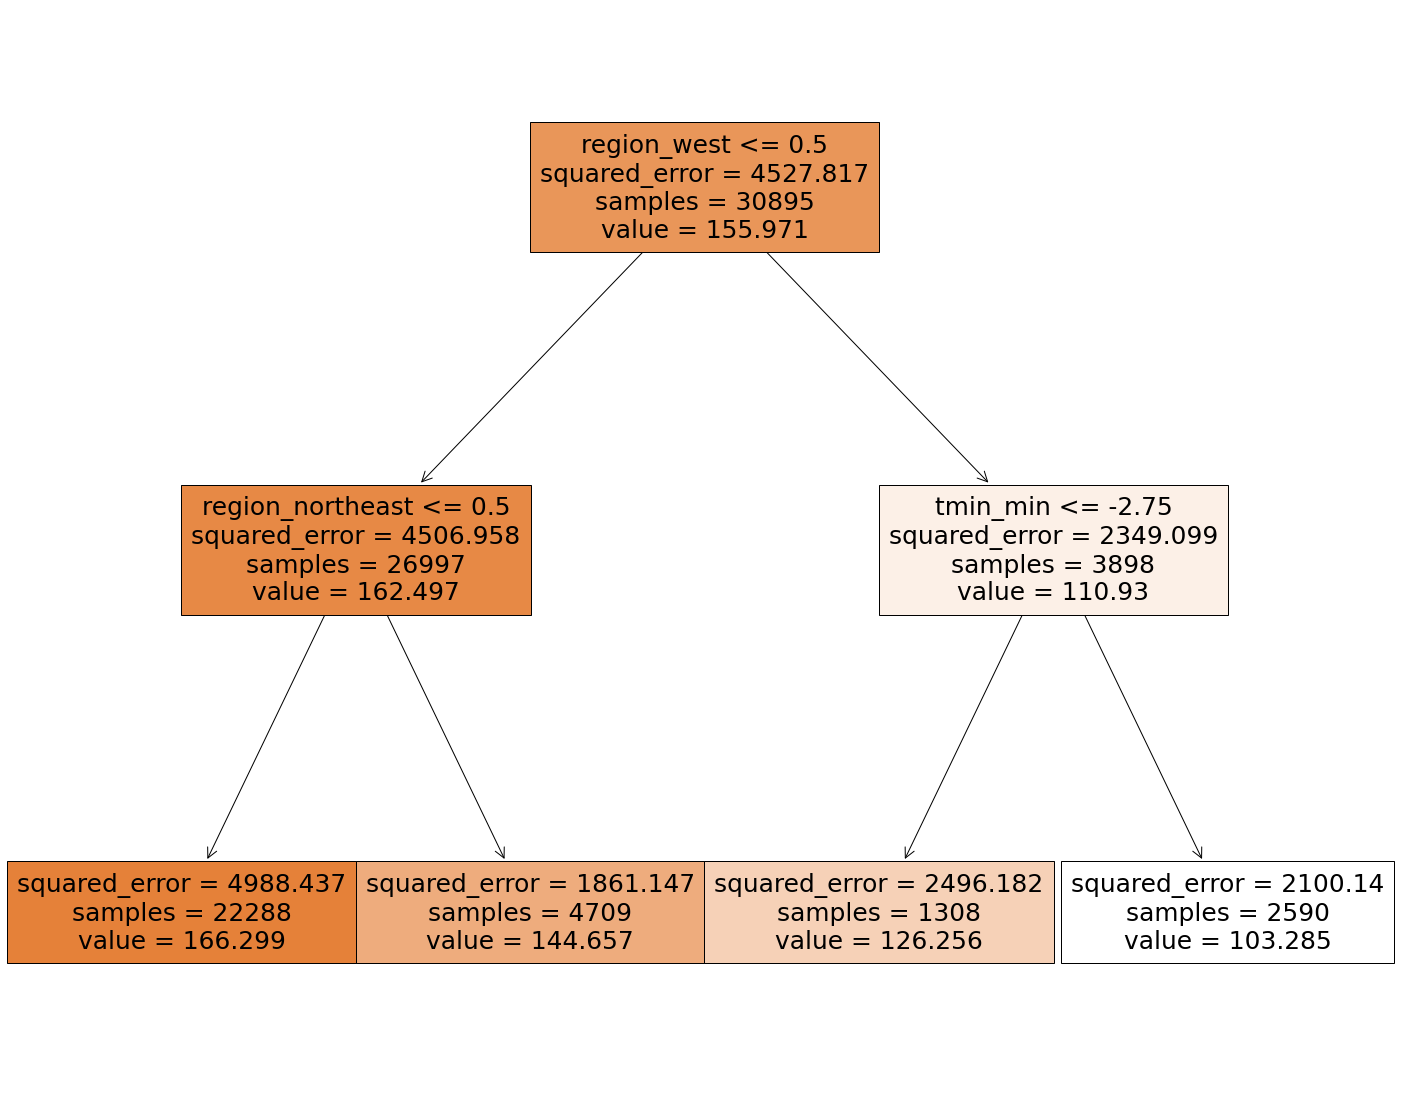

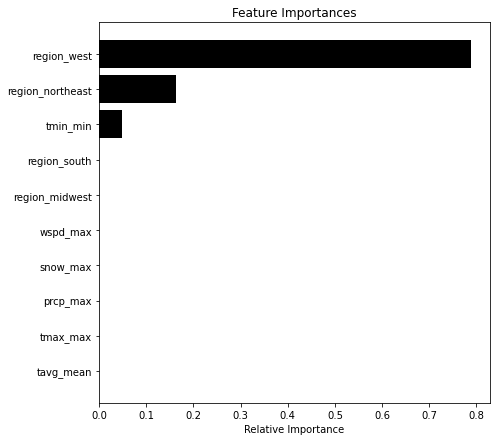

In [1004]:
region_weather_rt = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', regions_weather_X_train, regions_weather_y_train, regions_weather_X_test, regions_weather_y_test )

66945
Length Training Set:  48938
Training Set Ratio:  0.7310179998506237
Length Testing Set:  18007
Testing Set Ratio:  0.26898200014937634
Best Parameters for Model:  {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 100}
Train Error is:  -0.3003873560559545
Test Error is: 0.2910
Feature:  prop_65_85_up Importantance:  0.010423368250928235
Feature:  prop_female Importantance:  0.22802314537534238
Feature:  prop_white_nh Importantance:  0.07991922924149059
Feature:  pop_density Importantance:  0.3702577572092168
Feature:  region_midwest Importantance:  0.00010046363204830468
Feature:  region_northeast Importantance:  0.0003890759536315456
Feature:  region_south Importantance:  0.05390780515526581
Feature:  region_west Importantance:  0.2569791551820763


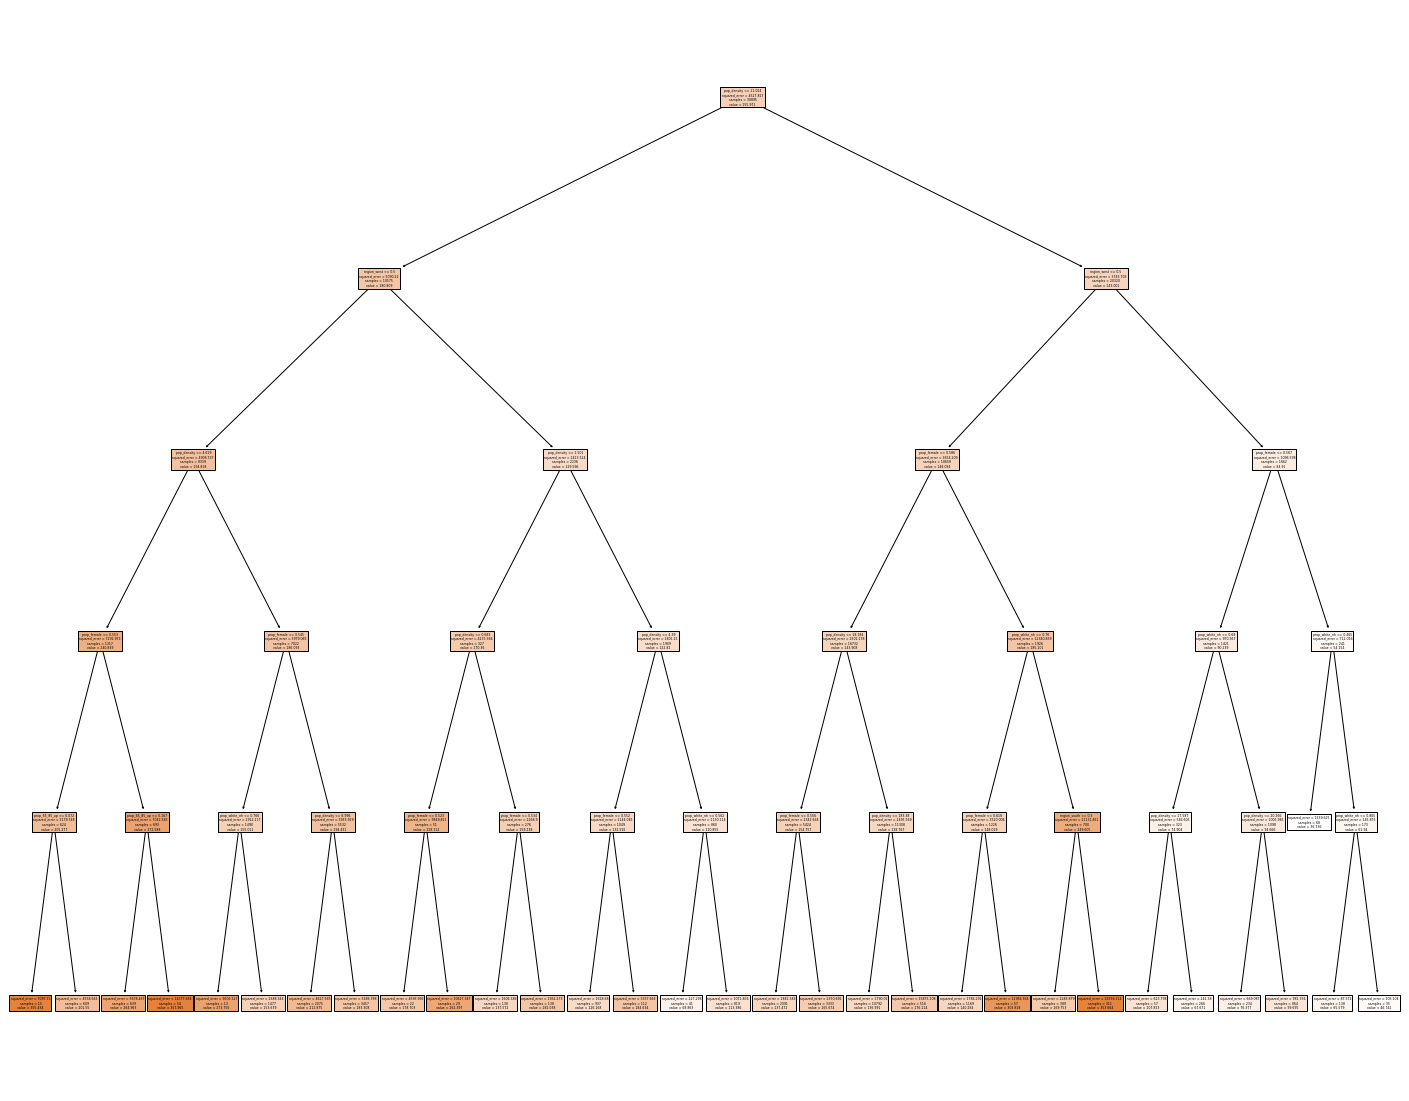

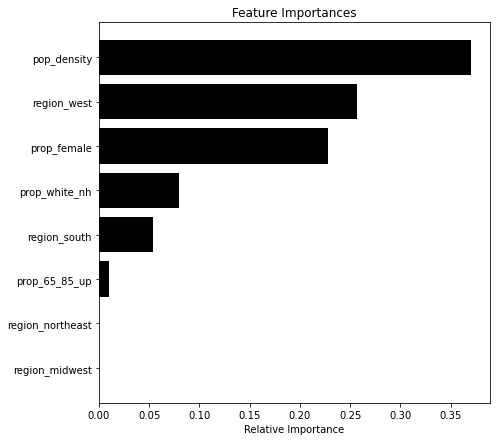

In [1005]:
#ohe region demo 
regions_demo_results = train_test_split(ohe_counties, demo_vars, ['region_midwest', 'region_northeast', 'region_south', 'region_west'])
region_demo_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', regions_demo_results[0], regions_demo_results[1], regions_demo_results[2], regions_demo_results[3] )

66945
Length Training Set:  48938
Training Set Ratio:  0.7310179998506237
Length Testing Set:  18007
Testing Set Ratio:  0.26898200014937634
Best Parameters for Model:  {'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 50}
Train Error is:  -0.3256220228108561
Test Error is: 0.3541
Feature:  median_income Importantance:  0.5693994544344743
Feature:  gini_index Importantance:  0.0
Feature:  prop_poor Importantance:  0.0
Feature:  region_midwest Importantance:  0.0
Feature:  region_northeast Importantance:  0.0
Feature:  region_south Importantance:  0.0
Feature:  region_west Importantance:  0.43060054556552574


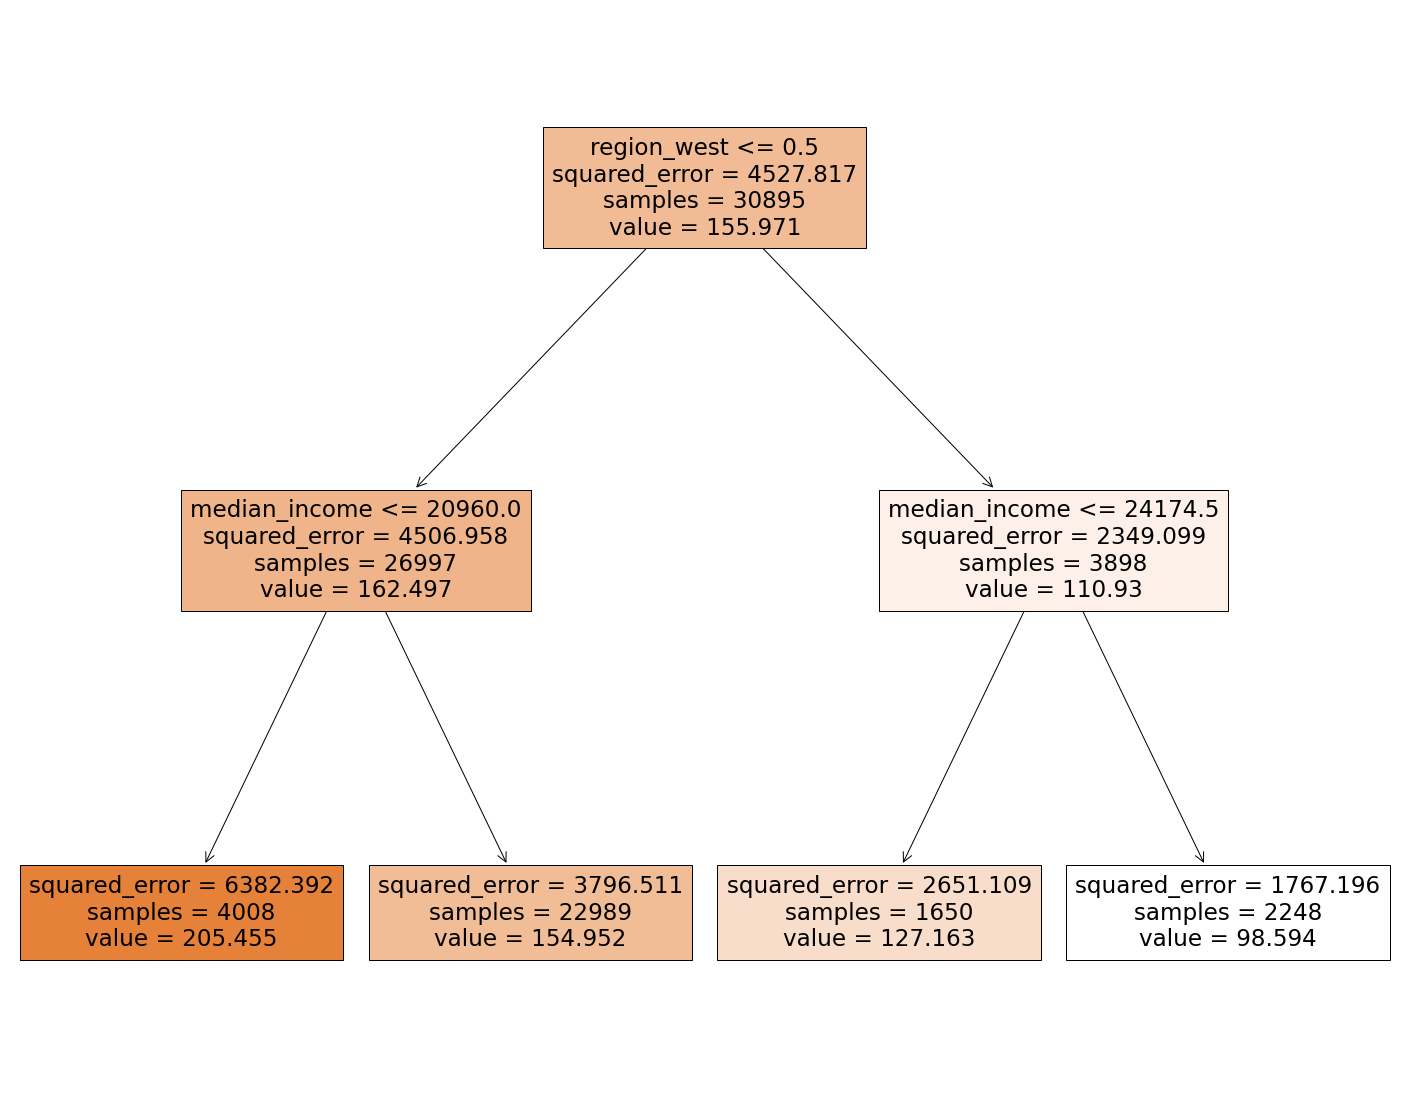

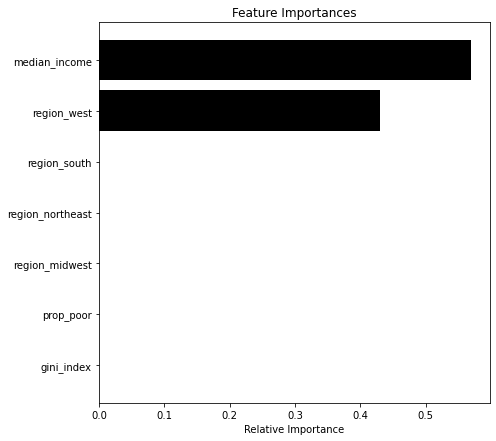

In [1006]:
#ohe region econ
regions_econ_results = train_test_split(ohe_counties, econ_vars, ['region_midwest', 'region_northeast', 'region_south', 'region_west'])
region_econ_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', regions_econ_results[0], regions_econ_results[1], regions_econ_results[2], regions_econ_results[3] )

66945
Length Training Set:  48938
Training Set Ratio:  0.7310179998506237
Length Testing Set:  18007
Testing Set Ratio:  0.26898200014937634
Best Parameters for Model:  {'max_depth': 4, 'min_samples_leaf': 10, 'n_estimators': 100}
Train Error is:  -0.30216960683367555
Test Error is: 0.3052
Feature:  tavg_mean Importantance:  4.8889645063349435e-05
Feature:  tmin_min Importantance:  0.00012005141780322444
Feature:  tmax_max Importantance:  0.0
Feature:  prcp_max Importantance:  0.0
Feature:  snow_max Importantance:  0.0
Feature:  wspd_max Importantance:  0.0
Feature:  prop_65_85_up Importantance:  0.0004005025953550646
Feature:  prop_female Importantance:  0.22441918974861447
Feature:  prop_white_nh Importantance:  0.059638504821442936
Feature:  pop_density Importantance:  0.35383796814926616
Feature:  median_income Importantance:  0.04586177286418421
Feature:  gini_index Importantance:  0.0004942927199063217
Feature:  prop_poor Importantance:  0.00011410262873724944
Feature:  region_mi

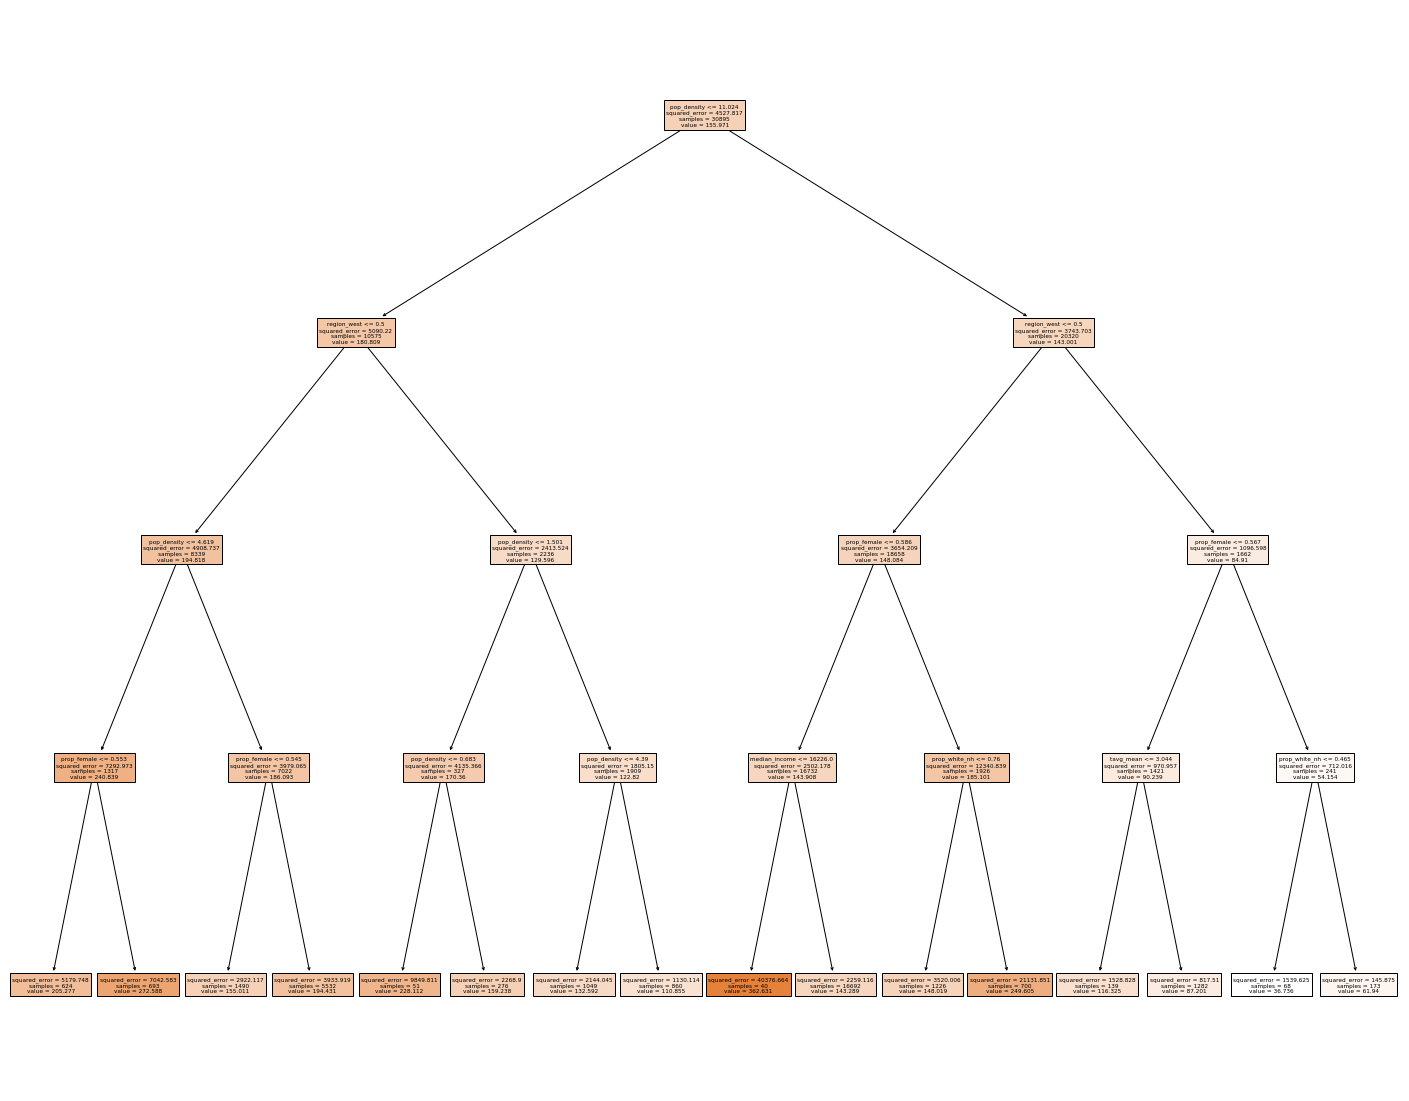

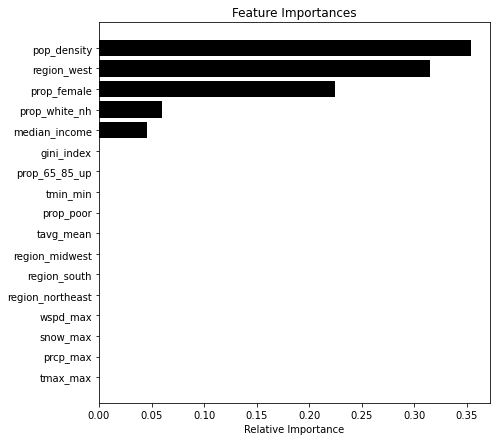

In [1007]:
#ohe region full
full_vars = weather_vars + demo_vars + econ_vars
regions_full_results = train_test_split(ohe_counties, full_vars, ['region_midwest', 'region_northeast', 'region_south', 'region_west'])
region_full_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', regions_full_results[0], regions_full_results[1], regions_full_results[2], regions_full_results[3] )

In [719]:
#latitude/longitude 

latlon_weather_results = train_test_split(geographic_df, weather_vars, ['lon', 'lat'])
latlon_weather_X_train = latlon_weather_results[0]
latlon_weather_y_train = latlon_weather_results[1]
latlon_weather_X_test = latlon_weather_results[2]
latlon_weather_y_test = latlon_weather_results[3]
#30% testing set

66945
Length Training Set:  48938
Training Set Ratio:  0.7310179998506237
Length Testing Set:  18007
Testing Set Ratio:  0.26898200014937634


Best Parameters for Model:  {'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 50}
Train Error is:  -0.3514035761842736
Test Error is: 0.3631


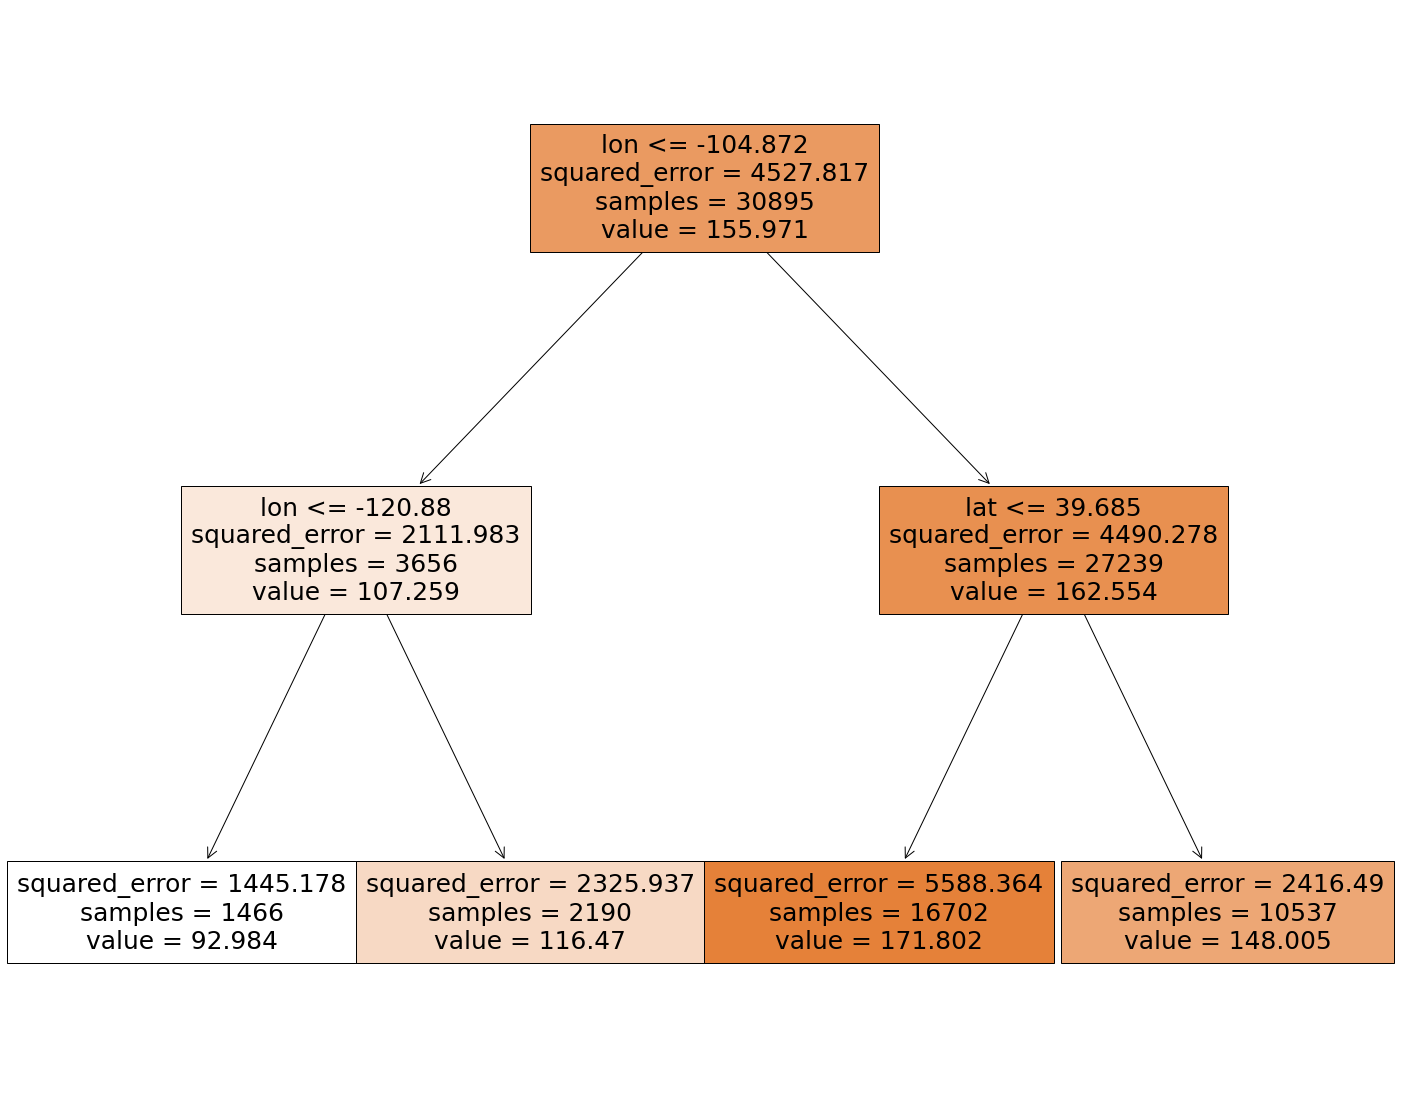

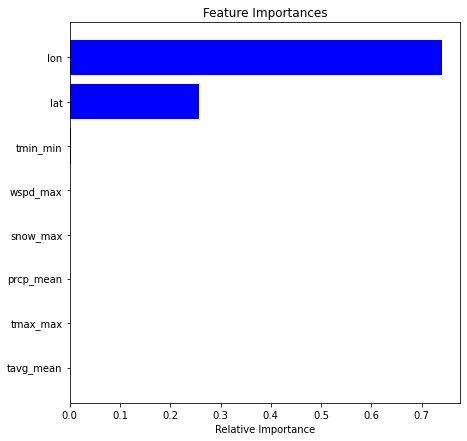

In [720]:
latlon_weather_rt = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', latlon_weather_X_train, latlon_weather_y_train, latlon_weather_X_test, latlon_weather_y_test )

66945
Length Training Set:  48938
Training Set Ratio:  0.7310179998506237
Length Testing Set:  18007
Testing Set Ratio:  0.26898200014937634
Best Parameters for Model:  {'max_depth': 2, 'min_samples_leaf': 5, 'n_estimators': 100}
Train Error is:  -0.3403193197732623
Test Error is: 0.4083
Feature:  tavg_mean Importantance:  0.03635915494069994
Feature:  tmin_min Importantance:  0.4653938799943829
Feature:  tmax_max Importantance:  0.49674528137090596
Feature:  prcp_max Importantance:  0.0
Feature:  snow_max Importantance:  0.0015016836940111794
Feature:  wspd_max Importantance:  0.0


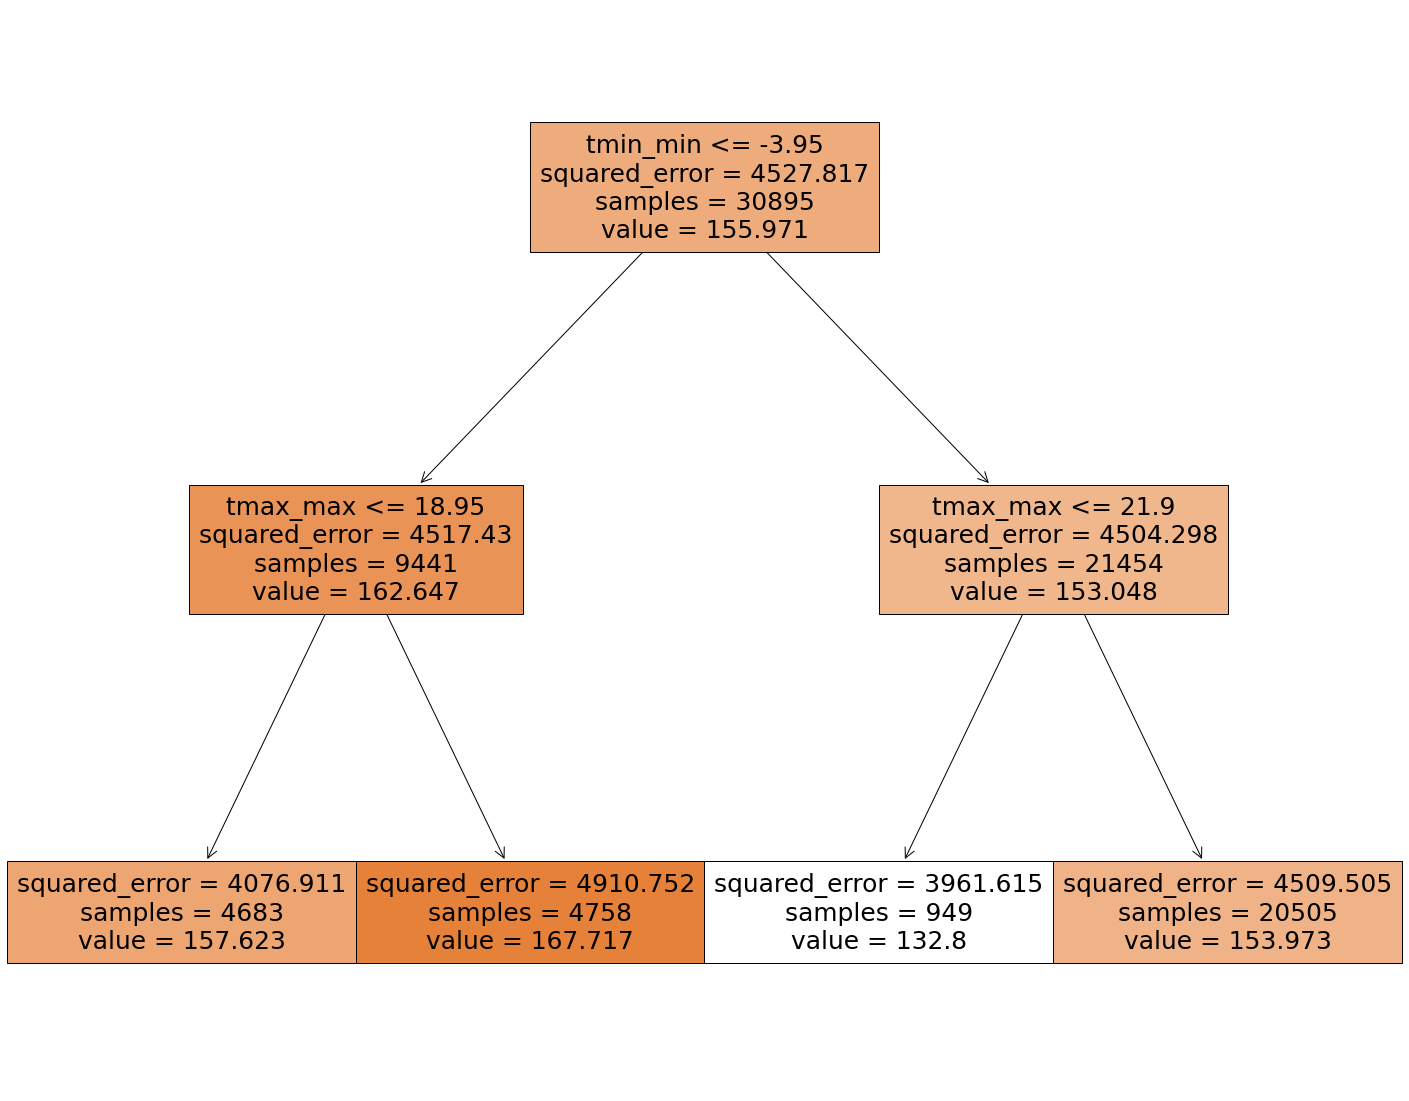

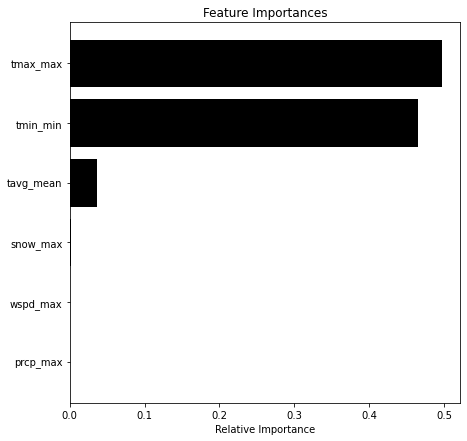

In [944]:
#could I put the region in as a categorical variable? 
#use latitude and longitude of the county centroids as a variable? - where are the error rates as a function of time/space 
#shapely package - look into this 
#use space and time to diaganose 


weather_results = train_test_split(time_df, weather_vars, [])
weather_X_train = weather_results[0]
weather_y_train = weather_results[1]
weather_X_test = weather_results[2]
weather_y_test = weather_results[3]

weather_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', weather_X_train, weather_y_train, weather_X_test, weather_y_test)


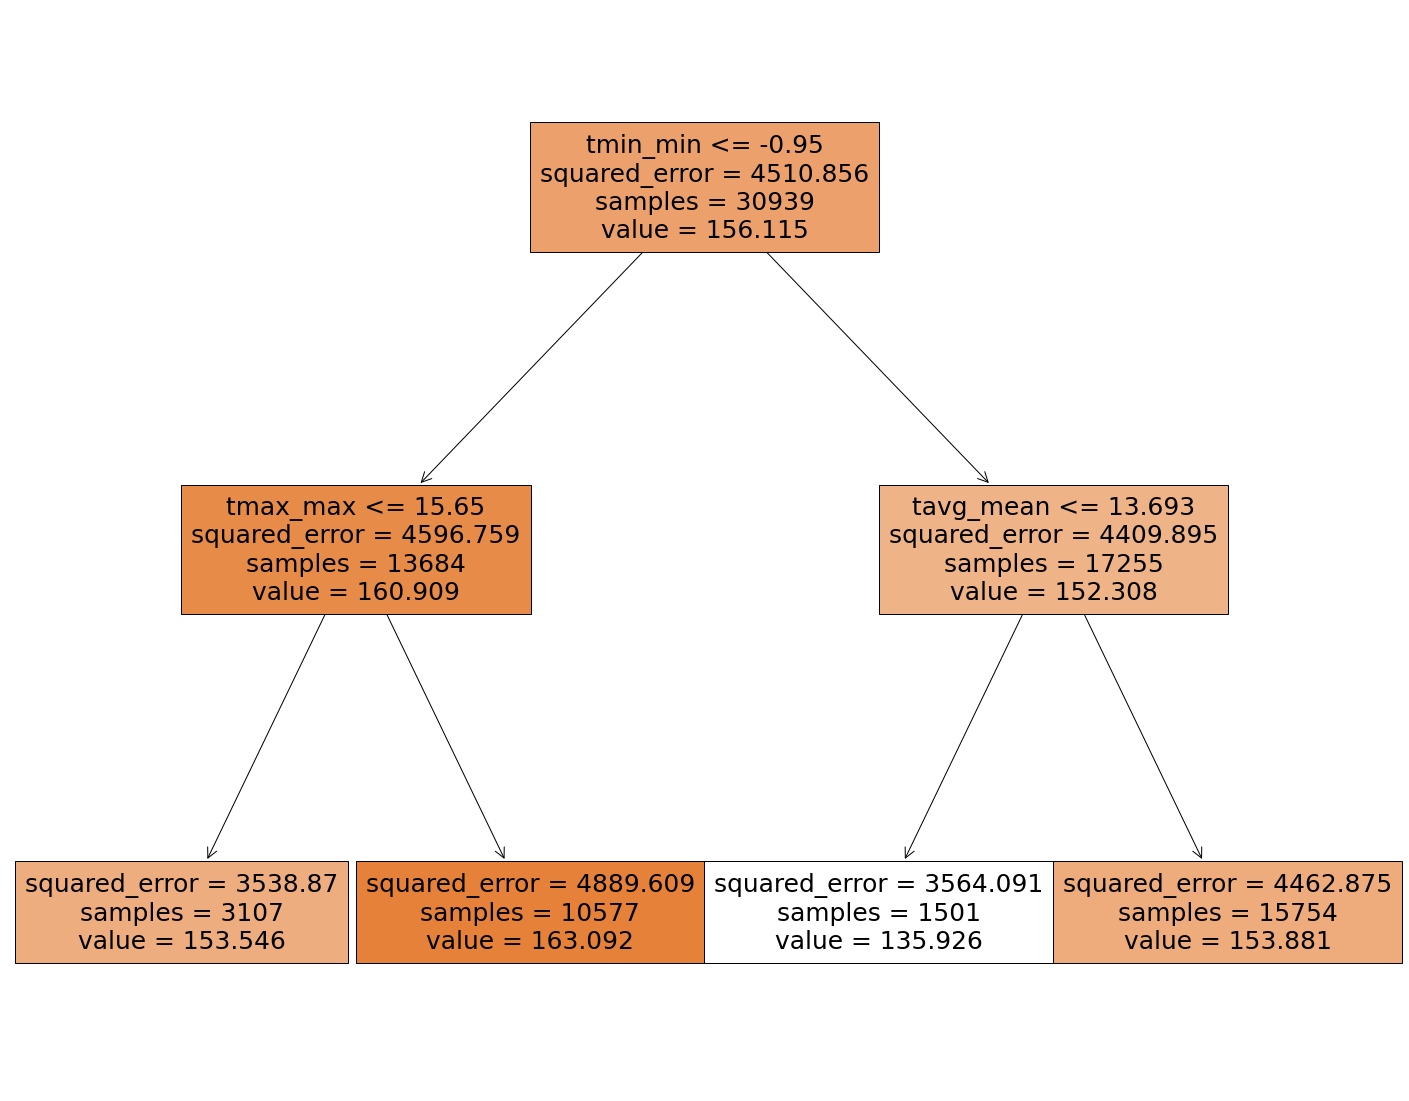

In [911]:
 #print one tree
one_tree = weather_rf.estimators_[5]

DT_figure = plt.figure(figsize=(25,20))
_ = tree.plot_tree(one_tree, feature_names=weather_X_train.columns, filled=True)


#imp = weather_rf.feature_importances_

#features = train_x.columns

#indices = np.argsort(imp)

#plt.figure(figsize=(7,7))
#plt.title('Feature Importances')
#plt.barh(range(len(indices)), imp[indices], color='black', align='center')
#plt.yticks(range(len(indices)), [features[i] for i in indices])
#plt.xlabel('Relative Importance')
#plt.show()

In [920]:
imp = weather_rf.feature_importances_

features = weather_X_train.columns

for i in range(len(imp)): 
    print("Feature: ", features[i], "Importantance: ", imp[i])


Feature:  tavg_mean Importantance:  0.03635915494069994
Feature:  tmin_min Importantance:  0.4653938799943829
Feature:  tmax_max Importantance:  0.49674528137090596
Feature:  prcp_max Importantance:  0.0
Feature:  snow_max Importantance:  0.0015016836940111794
Feature:  wspd_max Importantance:  0.0


## Demographics

In [909]:
#Demogaphics training/test set 
demo_results = train_test_split(time_df, demo_vars, [])
demo_X_train = demo_results[0]
demo_y_train = demo_results[1]
demo_X_test = demo_results[2]
demo_y_test = demo_results[3]

66945
Length Training Set:  48938
Training Set Ratio:  0.7310179998506237
Length Testing Set:  18007
Testing Set Ratio:  0.26898200014937634


Best Parameters for Model:  {'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 200}
Train Error is:  -0.3222595666871898
Test Error is: 0.3817
Feature:  prop_65_85_up Importantance:  0.0
Feature:  prop_female Importantance:  0.49660302489355485
Feature:  prop_white_nh Importantance:  0.0
Feature:  pop_density Importantance:  0.5033969751064452


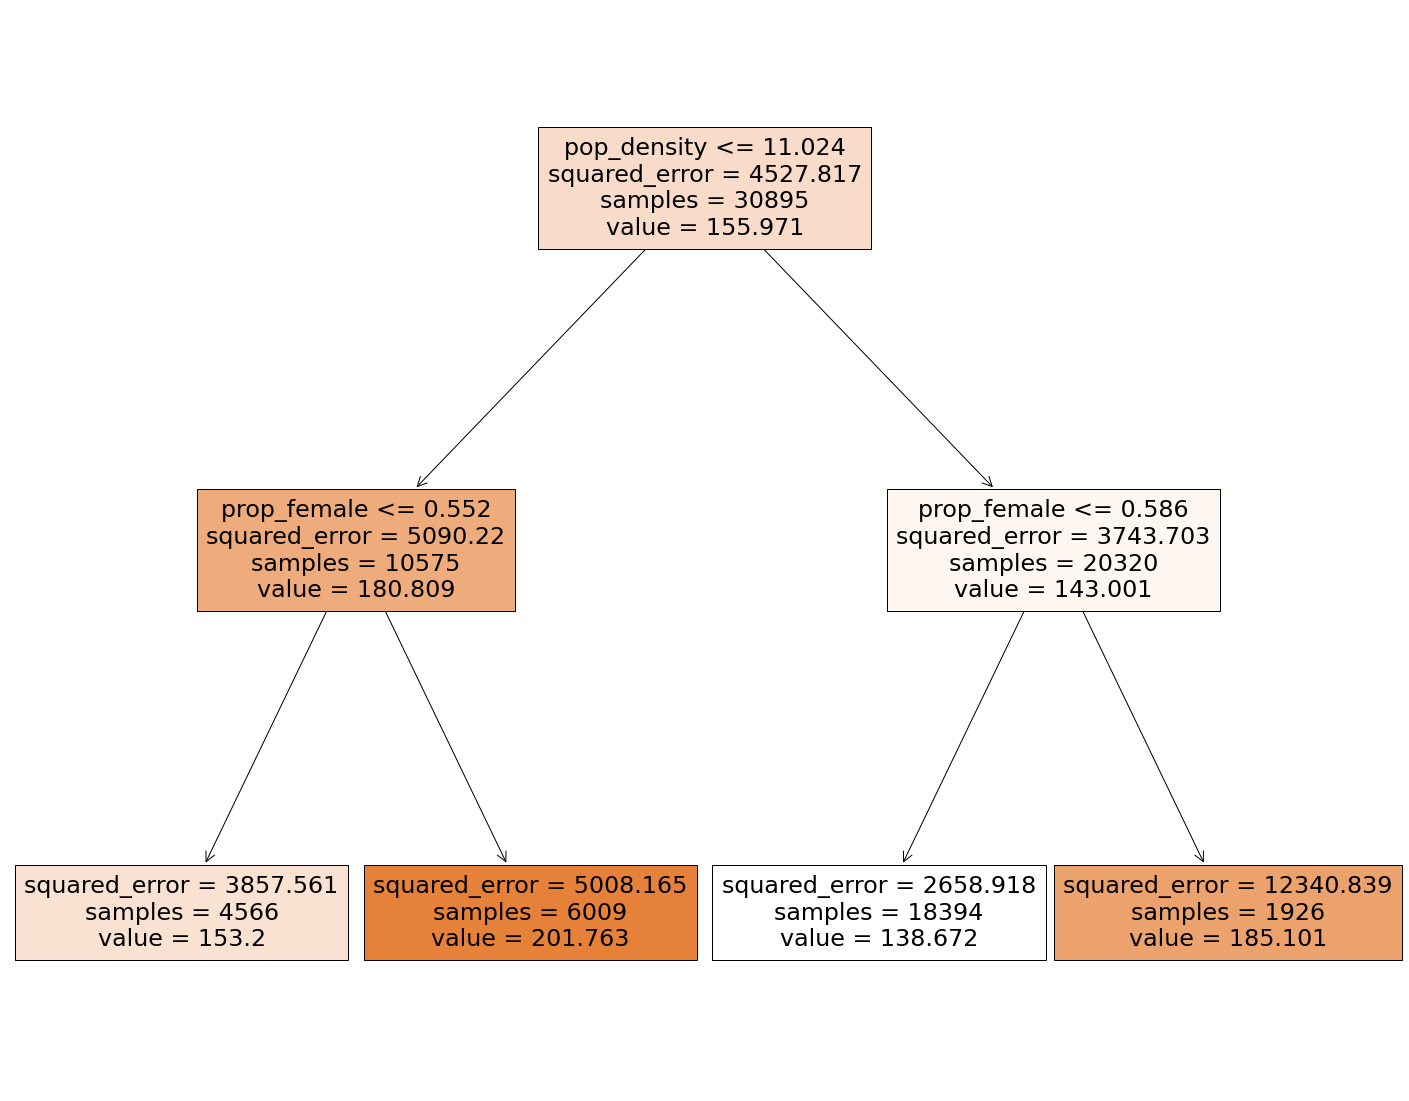

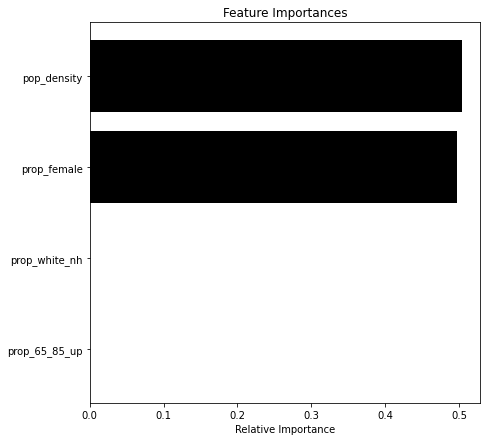

In [922]:
demo_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', demo_X_train, demo_y_train, demo_X_test, demo_y_test )

## Socioeconomic

In [982]:
#SES training/test set 
econ_results = train_test_split(time_df, econ_vars, [])
econ_X_train = econ_results[0]
econ_y_train = econ_results[1]
econ_X_test = econ_results[2]
econ_y_test = econ_results[3]

66945
Length Training Set:  48938
Training Set Ratio:  0.7310179998506237
Length Testing Set:  18007
Testing Set Ratio:  0.26898200014937634


Best Parameters for Model:  {'max_depth': 2, 'min_samples_leaf': 10, 'n_estimators': 50}
Train Error is:  -0.3330708044252738
Test Error is: 0.3985
Feature:  median_income Importantance:  1.0
Feature:  gini_index Importantance:  0.0
Feature:  prop_poor Importantance:  0.0


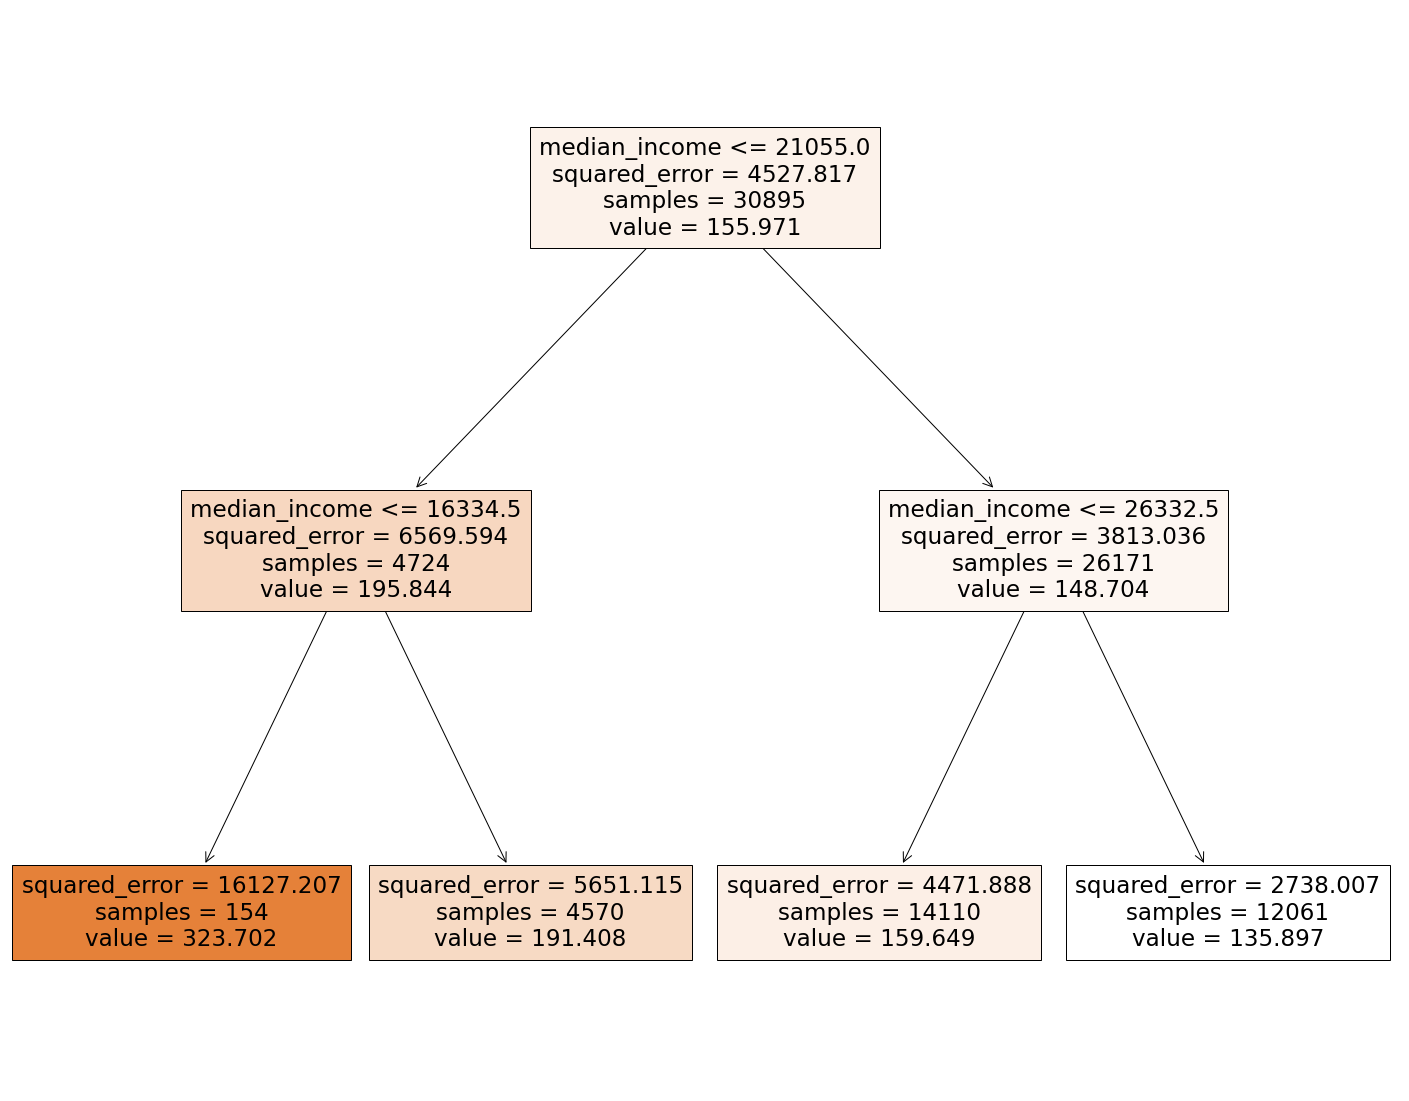

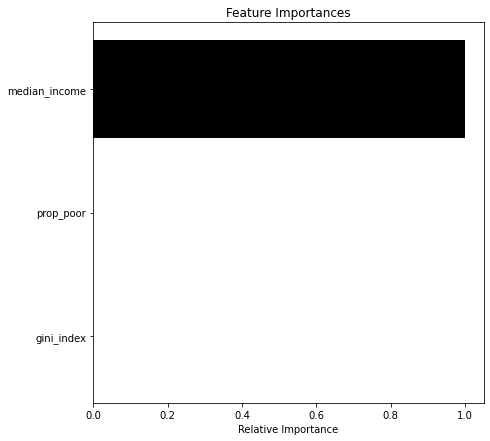

In [983]:
econ_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', econ_X_train, econ_y_train, econ_X_test, econ_y_test )

## Full Model

In [986]:
#Training/test set 
full_vars = demo_vars + econ_vars + weather_vars

#get rid of raw pop 65 and up too since this is denominator for outcome
full_results = train_test_split(time_df, full_vars, [])
full_X_train = full_results[0]
full_y_train = full_results[1]
full_X_test = full_results[2]
full_y_test = full_results[3]

66945
Length Training Set:  48938
Training Set Ratio:  0.7310179998506237
Length Testing Set:  18007
Testing Set Ratio:  0.26898200014937634


Best Parameters for Model:  {'max_depth': 4, 'min_samples_leaf': 1, 'n_estimators': 200}
Train Error is:  -0.3209015187085704
Test Error is: 0.3358
Feature:  prop_65_85_up Importantance:  0.004791900946907354
Feature:  prop_female Importantance:  0.3503308881436178
Feature:  prop_white_nh Importantance:  0.21645196866541047
Feature:  pop_density Importantance:  0.3260981196995309
Feature:  median_income Importantance:  0.08659480283487532
Feature:  gini_index Importantance:  0.009939899574042895
Feature:  prop_poor Importantance:  0.005792420135615215
Feature:  tavg_mean Importantance:  0.0
Feature:  tmin_min Importantance:  0.0
Feature:  tmax_max Importantance:  0.0
Feature:  prcp_max Importantance:  0.0
Feature:  snow_max Importantance:  0.0
Feature:  wspd_max Importantance:  0.0


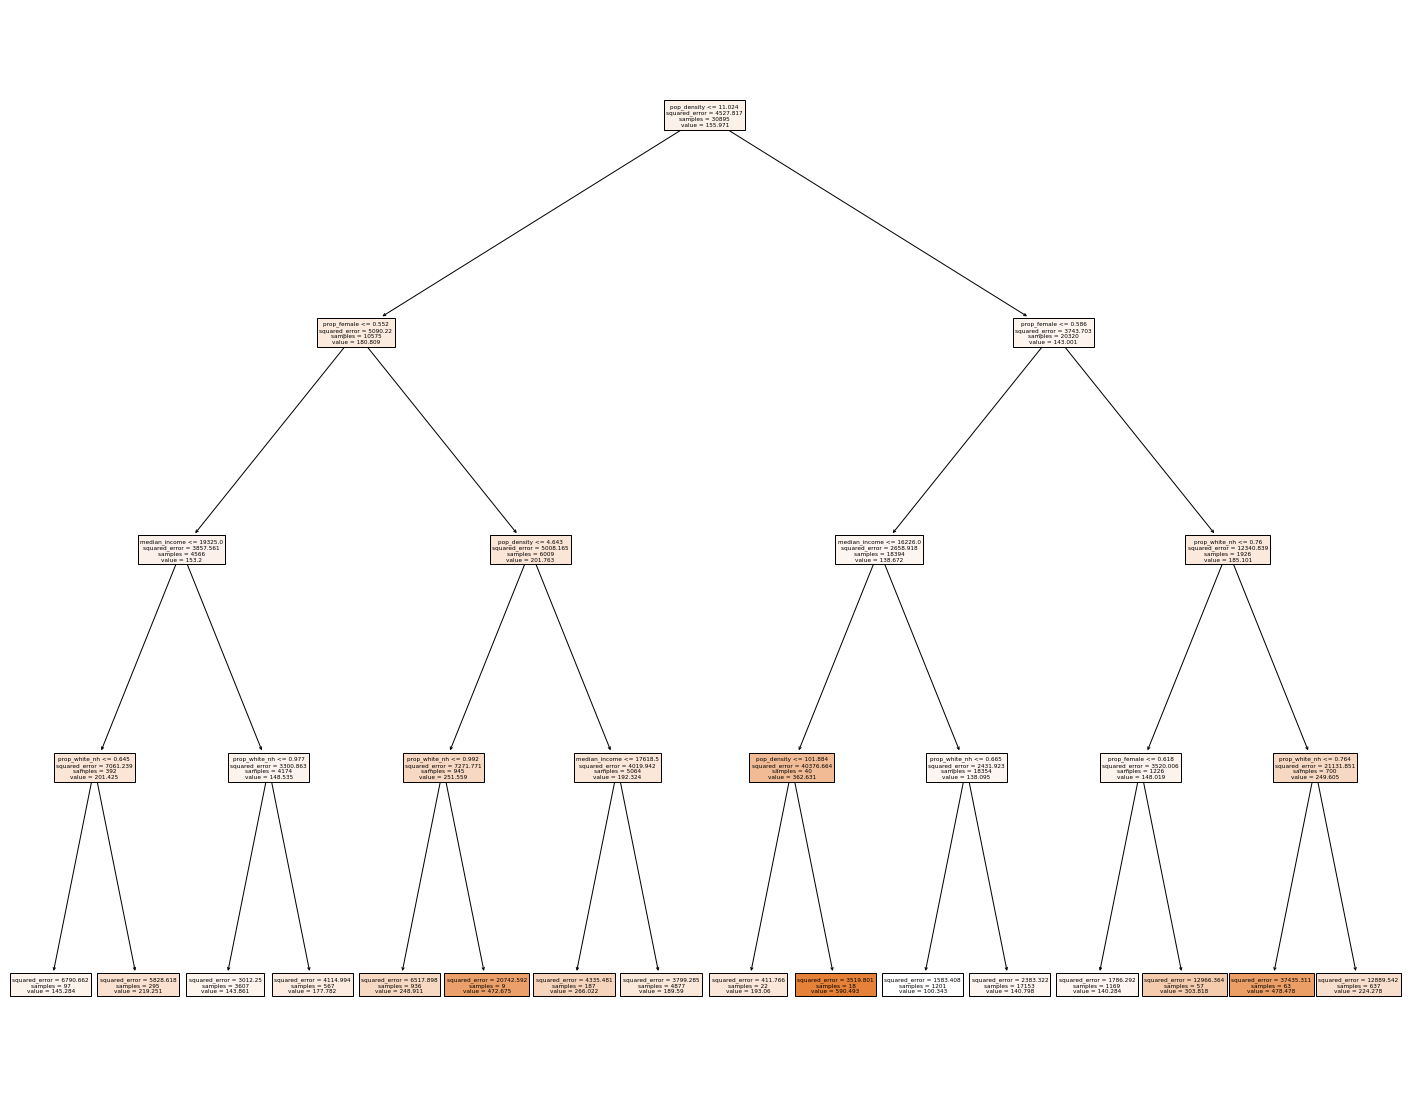

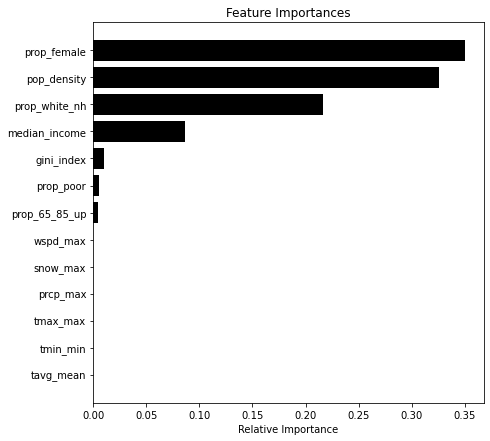

In [987]:
full_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', full_X_train, full_y_train, full_X_test, full_y_test )

In [953]:
test_preds = weather_y_test.reset_index()

In [954]:
len(test_preds)

18007

In [938]:
test_preds.head()

date scaled_fall_rate
0  2015-02-01 00:00:00       163.912034
1  2014-03-01 00:00:00       163.912034
2  2015-04-01 00:00:00       163.912034
3  2015-05-01 00:00:00       150.252698
4  2015-06-01 00:00:00       163.912034

In [1009]:
#predictions from all the models 
weather_pred = weather_rf.predict(weather_X_test)
demo_pred = demo_rf.predict(demo_X_test)
econ_pred = econ_rf.predict(econ_X_test)
full_pred = full_rf.predict(full_X_test)

In [1010]:
pred_df = pd.DataFrame(weather_pred, columns = ['pred'])
len(pred_df)

18007

In [1012]:
test_preds['weather_pred'] = weather_pred.tolist()
test_preds['demo_pred'] = demo_pred.tolist()
test_preds['econ_pred'] = econ_pred.tolist()
test_preds['full_pred'] = full_pred.tolist()


In [1013]:
test_preds.head()

date  scaled_fall_rate        pred  weather_pred   demo_pred  \
0 2015-02-01        163.912034  164.395326    164.395326  202.933961   
1 2014-03-01        163.912034  153.079330    153.079330  202.933961   
2 2015-04-01        163.912034  154.302105    154.302105  202.933961   
3 2015-05-01        150.252698  154.302105    154.302105  202.933961   
4 2015-06-01        163.912034  154.302105    154.302105  202.933961   

    econ_pred   full_pred  
0  136.433322  190.123583  
1  136.433322  190.123583  
2  136.433322  190.123583  
3  136.433322  190.123583  
4  136.433322  190.123583

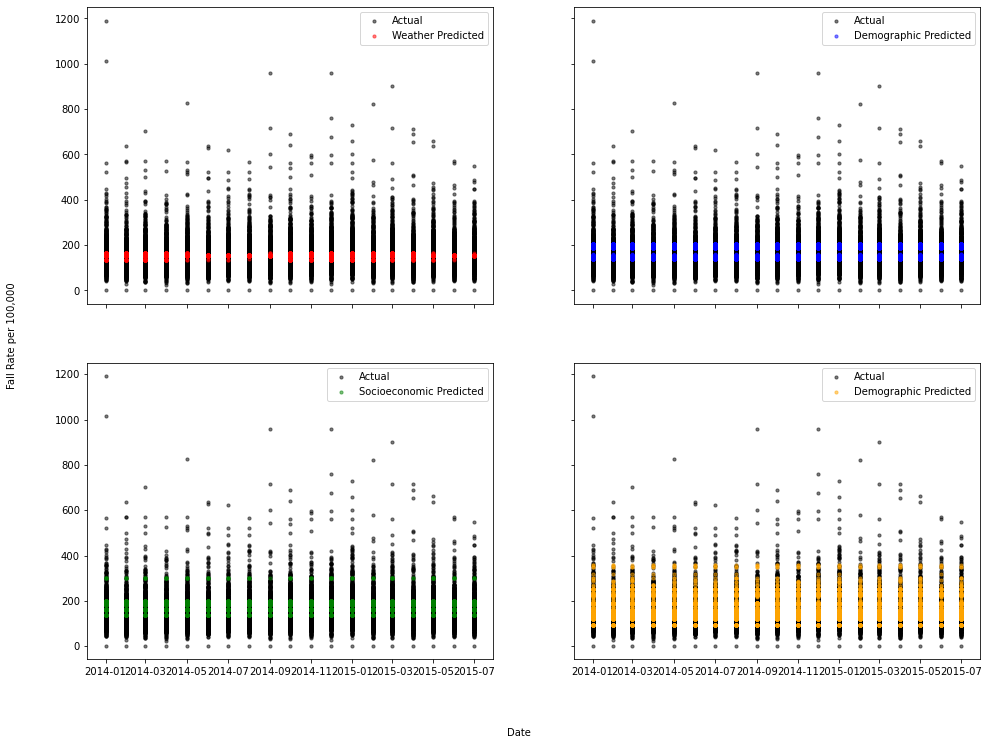

In [1025]:
fig, ax = plt.subplots(2, 2, sharex='all', sharey='all', figsize=(16, 12))


ax[0,0].scatter(test_preds['date'],test_preds['scaled_fall_rate'],color = 'black', alpha = 0.5, s = 10, label = 'Actual')
ax[0,0].scatter(test_preds['date'],test_preds['weather_pred'], color = 'red', alpha = 0.5, s = 10, label = 'Weather Predicted')
ax[0,0].legend(loc="upper right")

ax[0, 1].scatter(test_preds['date'],test_preds['scaled_fall_rate'],color = 'black', alpha = 0.5, s = 10, label = 'Actual')
ax[0, 1].scatter(test_preds['date'],test_preds['demo_pred'], color = 'blue', alpha = 0.5, s = 10, label = 'Demographic Predicted')
ax[0,1].legend(loc="upper right")

ax[1, 0].scatter(test_preds['date'],test_preds['scaled_fall_rate'],color = 'black', alpha = 0.5, s = 10, label = 'Actual')
ax[1, 0].scatter(test_preds['date'],test_preds['econ_pred'], color = 'green', alpha = 0.5, s = 10, label = 'Socioeconomic Predicted')
ax[1,0].legend(loc="upper right")

ax[1, 1].scatter(test_preds['date'],test_preds['scaled_fall_rate'],color = 'black', alpha = 0.5, s = 10, label = 'Actual')
ax[1, 1].scatter(test_preds['date'],test_preds['full_pred'], color = 'orange', alpha = 0.5, s = 10, label = 'Demographic Predicted')
ax[1,1].legend(loc="upper right")


# Set common labels
fig.text(0.5, 0.04, 'Date', ha='center', va='center')
fig.text(0.06, 0.5, 'Fall Rate per 100,000', ha='center', va='center', rotation='vertical')

#plt.xlabel('Date')
#plt.ylabel('Fall Rate per 100,000')
#plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
#plt.legend(loc="best")
plt.show()


# Regional Analysis 


Want to create 4 different models for each of the 4 census regions in the US (https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf), split the data into these groups. 



In [1057]:
full_df = pd.read_pickle("full_data.pkl")

In [1058]:
full_df.head()


month_count  fipscounty     date  tavg_min  tavg_max  tavg_median  \
0          NaN        1001  2010-01      -3.9      15.6         6.70   
1         14.0        1001  2011-01      -2.3      16.1         6.70   
2          NaN        1001  2012-01       0.3      18.9        11.75   
3          NaN        1001  2013-01       5.0      20.9        12.40   
4          NaN        1001  2014-01      -7.2      11.6         3.90   

   tavg_mean  tavg_std  tmin_min  tmin_max  ...  tsun_std  median_income  \
0   5.393103  6.070769      -8.9      11.0  ...       NaN        26728.0   
1   5.823333  4.301217      -8.0      12.0  ...       NaN        26728.0   
2  11.310714  5.214747      -5.9      17.2  ...       NaN        26728.0   
3  12.092308  5.250137      -0.6      17.1  ...       NaN        26728.0   
4   3.485185  4.998669     -10.9       7.0  ...       NaN        26728.0   

   gini_index  pop_65_up  prop_65_85_up  prop_female  prop_white_nh  \
0        0.41       7321       0.091381     0.577244       0.829531   
1        0.41       7321       0.091381     0.577244       0.829531   
2        0.41       7321       0.091381     0.577244       0.829531   
3        0.41       7321       0.091381     0.577244       0.829531   
4        0.41       7321       0.091381     0.577244       0.829531   

   prop_poor  pop_density  scaled_fall_rate  
0   0.067614     6.439718               NaN  
1   0.067614     6.439718        191.230706  
2   0.067614     6.439718               NaN  
3   0.067614     6.439718               NaN  
4   0.067614     6.439718               NaN  

[5 rows x 62 columns]

In [1060]:
#remove the unnecessary weather variables 

full_df.drop(["month_count", "wdir_min", "wdir_max", "wdir_median", "wdir_mean", "wdir_std",
            "wpgt_min", "wpgt_max", "wpgt_median", "wpgt_mean", "wpgt_std",
            "pres_min", "pres_max", "pres_median", "pres_mean", "pres_std",
            "tsun_min", "tsun_max", "tsun_median", "tsun_mean", "tsun_std", 
            'tavg_min', 'tavg_max', 'tavg_median',  'tavg_std',
        'tmin_max', 'tmin_median', 'tmin_mean', 'tmin_std',
       'tmax_min',  'tmax_median', 'tmax_mean', 'tmax_std',
       'prcp_min', 'prcp_mean', 'prcp_median',  'prcp_std',
       'snow_min',  'snow_median', 'snow_mean', 'snow_std',
       'wspd_min',  'wspd_median', 'wspd_mean', 'wspd_std'], axis = 1, inplace = True)


In [822]:
full_df.head()

fipscounty     date  tavg_mean  tmin_min  tmax_max  prcp_max  snow_max  \
0        1001  2010-01   5.393103      -8.9      21.9       NaN       NaN   
1        1001  2011-01   5.823333      -8.0      23.0       NaN       NaN   
2        1001  2012-01  11.310714      -5.9      24.6       NaN       NaN   
3        1001  2013-01  12.092308      -0.6      26.4       NaN       NaN   
4        1001  2014-01   3.485185     -10.9      18.9       NaN       NaN   

   wspd_max  median_income  gini_index  pop_65_up  prop_65_85_up  prop_female  \
0      18.0        26728.0        0.41       7321       0.091381     0.577244   
1      16.8        26728.0        0.41       7321       0.091381     0.577244   
2      16.9        26728.0        0.41       7321       0.091381     0.577244   
3      20.7        26728.0        0.41       7321       0.091381     0.577244   
4      22.1        26728.0        0.41       7321       0.091381     0.577244   

   prop_white_nh  prop_poor  pop_density  scaled_fall_rate  
0       0.829531   0.067614     6.439718               NaN  
1       0.829531   0.067614     6.439718        191.230706  
2       0.829531   0.067614     6.439718               NaN  
3       0.829531   0.067614     6.439718               NaN  
4       0.829531   0.067614     6.439718               NaN

In [1061]:
#easy way to deal with the precipitation and snow 
full_df['prcp_max'] = full_df['prcp_max'].replace(np.nan, 0)

full_df['snow_max'] = full_df['snow_max'].replace(np.nan, 0)

In [1062]:
full_df.isnull().sum()

month_count         126267
fipscounty               0
date                     0
tavg_mean             6333
tmin_min               134
tmax_max               135
prcp_max                 0
snow_max                 0
wspd_max              4905
median_income            0
gini_index               0
pop_65_up                0
prop_65_85_up            0
prop_female              0
prop_white_nh            0
prop_poor                0
pop_density              0
scaled_fall_rate    126267
dtype: int64

In [375]:
len(full_df['fipscounty'].unique())

3104

In [376]:
#come back to this
#no_missing_data = full_df.dropna()
#no_missing_data.head()
#print(len(no_missing_data['fipscounty'].unique()))

In [843]:
#add states back in, then group by region 
#use states from the Medicare crosswalk (hopefully easiest)
fips_crosswalk_2015 = pd.read_csv("ssa_fips_state_county2015_nostatewide.csv")
fips_crosswalk_2015.head()

county state  ssacounty  fipscounty  cbsaold            cbsanameold  \
0  AUTAUGA    AL       1000        1001  33860.0         Montgomery, AL   
1  BALDWIN    AL       1010        1003      NaN                    NaN   
2  BARBOUR    AL       1020        1005      NaN                    NaN   
3     BIBB    AL       1030        1007  13820.0  Birmingham-Hoover, AL   
4   BLOUNT    AL       1040        1009  13820.0  Birmingham-Hoover, AL   

      cbsa                   cbsaname  ssastate  fipsstate  
0  33860.0             Montgomery, AL         1          1  
1  19300.0  Daphne-Fairhope-Foley, AL         1          1  
2      NaN                        NaN         1          1  
3  13820.0      Birmingham-Hoover, AL         1          1  
4  13820.0      Birmingham-Hoover, AL         1          1

In [827]:
crosswalk_small = fips_crosswalk_2015[['state', 'fipscounty']]

In [1063]:
datawstates = full_df.merge(crosswalk_small, left_on= 'fipscounty', right_on = 'fipscounty', how = 'inner')
datawstates.head()

month_count  fipscounty     date  tavg_mean  tmin_min  tmax_max  prcp_max  \
0          NaN        1001  2010-01   5.393103      -8.9      21.9       0.0   
1         14.0        1001  2011-01   5.823333      -8.0      23.0       0.0   
2          NaN        1001  2012-01  11.310714      -5.9      24.6       0.0   
3          NaN        1001  2013-01  12.092308      -0.6      26.4       0.0   
4          NaN        1001  2014-01   3.485185     -10.9      18.9       0.0   

   snow_max  wspd_max  median_income  gini_index  pop_65_up  prop_65_85_up  \
0       0.0      18.0        26728.0        0.41       7321       0.091381   
1       0.0      16.8        26728.0        0.41       7321       0.091381   
2       0.0      16.9        26728.0        0.41       7321       0.091381   
3       0.0      20.7        26728.0        0.41       7321       0.091381   
4       0.0      22.1        26728.0        0.41       7321       0.091381   

   prop_female  prop_white_nh  prop_poor  pop_density  scaled_fall_rate state  
0     0.577244       0.829531   0.067614     6.439718               NaN    AL  
1     0.577244       0.829531   0.067614     6.439718        191.230706    AL  
2     0.577244       0.829531   0.067614     6.439718               NaN    AL  
3     0.577244       0.829531   0.067614     6.439718               NaN    AL  
4     0.577244       0.829531   0.067614     6.439718               NaN    AL

In [829]:
len(datawstates['fipscounty'].unique())

3104

In [1064]:
#regions key 
west = ['WA', 'OR', 'CA', 'MT', 'ID', 'WY', 'NV', 'UT', 'CO', 'AZ', 'NM']
midwest = ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'IN', 'MI', 'OH']
south = ['TX', 'OK', 'AR', 'LA', 'MS', 'AL', 'GA', 'FL', 'SC', 'NC', 'KY', 'TN', 'WV','MD', 'DE', 'VA', 'DC']
northeast = ['PA', 'NY', 'NJ', 'VT', 'NH', 'MA', 'CT', 'RI', 'ME']

In [1065]:
datawstates['west_region'] = np.where(datawstates['state'].isin(west), 1, 0)
datawstates['midwest_region'] = np.where(datawstates['state'].isin(midwest), 1, 0)
datawstates['south_region'] = np.where(datawstates['state'].isin(south), 1, 0)
datawstates['northeast_region'] = np.where(datawstates['state'].isin(northeast), 1, 0)

datawstates.head()

month_count  fipscounty     date  tavg_mean  tmin_min  tmax_max  prcp_max  \
0          NaN        1001  2010-01   5.393103      -8.9      21.9       0.0   
1         14.0        1001  2011-01   5.823333      -8.0      23.0       0.0   
2          NaN        1001  2012-01  11.310714      -5.9      24.6       0.0   
3          NaN        1001  2013-01  12.092308      -0.6      26.4       0.0   
4          NaN        1001  2014-01   3.485185     -10.9      18.9       0.0   

   snow_max  wspd_max  median_income  ...  prop_female  prop_white_nh  \
0       0.0      18.0        26728.0  ...     0.577244       0.829531   
1       0.0      16.8        26728.0  ...     0.577244       0.829531   
2       0.0      16.9        26728.0  ...     0.577244       0.829531   
3       0.0      20.7        26728.0  ...     0.577244       0.829531   
4       0.0      22.1        26728.0  ...     0.577244       0.829531   

   prop_poor  pop_density  scaled_fall_rate  state  west_region  \
0   0.067614     6.439718               NaN     AL            0   
1   0.067614     6.439718        191.230706     AL            0   
2   0.067614     6.439718               NaN     AL            0   
3   0.067614     6.439718               NaN     AL            0   
4   0.067614     6.439718               NaN     AL            0   

   midwest_region south_region  northeast_region  
0               0            1                 0  
1               0            1                 0  
2               0            1                 0  
3               0            1                 0  
4               0            1                 0  

[5 rows x 23 columns]

In [846]:
total_west = datawstates[datawstates['west_region']==1]
len(total_west['fipscounty'].unique())

414

In [839]:
total_midwest = datawstates[datawstates['midwest_region']==1]
len(total_midwest['fipscounty'].unique())

1053

In [806]:
total_south = datawstates[datawstates['south_region']==1]
len(total_south['fipscounty'].unique())

1420

In [807]:
total_northeast = datawstates[datawstates['northeast_region']==1]
len(total_northeast['fipscounty'].unique())

217

In [808]:
len(total_west['fipscounty'].unique()) + len(total_midwest['fipscounty'].unique()) + len(total_south['fipscounty'].unique()) +len(total_northeast['fipscounty'].unique())

3104

In [833]:
#save as pickle for the future 
datawstates.to_pickle("region_data.pkl")

In [1066]:
#save this to csv to for R analysis
datawstates.to_csv("full_data_regions.csv")

In [1046]:
datawstates = pd.read_pickle('region_data.pkl')

In [1047]:
datawstates.head()

fipscounty     date  tavg_mean  tmin_min  tmax_max  prcp_max  snow_max  \
0        1001  2010-01   5.393103      -8.9      21.9       NaN       0.0   
1        1001  2011-01   5.823333      -8.0      23.0       NaN       0.0   
2        1001  2012-01  11.310714      -5.9      24.6       NaN       0.0   
3        1001  2013-01  12.092308      -0.6      26.4       NaN       0.0   
4        1001  2014-01   3.485185     -10.9      18.9       NaN       0.0   

   wspd_max  median_income  gini_index  ...  prop_white_nh  prop_poor  \
0      18.0        26728.0        0.41  ...       0.829531   0.067614   
1      16.8        26728.0        0.41  ...       0.829531   0.067614   
2      16.9        26728.0        0.41  ...       0.829531   0.067614   
3      20.7        26728.0        0.41  ...       0.829531   0.067614   
4      22.1        26728.0        0.41  ...       0.829531   0.067614   

   pop_density  scaled_fall_rate  prcp_mean  state  west_region  \
0     6.439718               NaN        0.0     AL            0   
1     6.439718        191.230706        0.0     AL            0   
2     6.439718               NaN        0.0     AL            0   
3     6.439718               NaN        0.0     AL            0   
4     6.439718               NaN        0.0     AL            0   

   midwest_region south_region  northeast_region  
0               0            1                 0  
1               0            1                 0  
2               0            1                 0  
3               0            1                 0  
4               0            1                 0  

[5 rows x 23 columns]

In [847]:
#create regions, drop nas
#train/test splits
#then subset the relevant variables for each model

west_region_df = datawstates[datawstates['west_region'] ==1]
midwest_region_df = datawstates[datawstates['midwest_region'] ==1]
south_region_df = datawstates[datawstates['south_region'] ==1]
northeast_region_df = datawstates[datawstates['northeast_region'] ==1]

In [431]:
print(len(west_region_df.state.unique()))
print(len(midwest_region_df.state.unique()))
print(len(south_region_df.state.unique()))
print(len(northeast_region_df.state.unique()))


11
12
17
9


In [840]:
west_region_df.head()

date  tavg_mean  tmin_min  tmax_max  prcp_max  snow_max  wspd_max  \
4667 2010-01-01  -4.548276      -7.2      18.8      49.9       0.0      15.9   
4670 2013-01-01  -7.596552     -16.0      21.7      12.5       0.0      21.4   
4671 2014-01-01  -0.396154      -6.9      22.3       0.2       0.0      25.5   
4674 2011-02-01  -2.518519     -16.1      24.9       5.4       0.0      23.2   
4676 2013-02-01  -1.614815     -10.0      21.2       5.7       0.0      22.9   

      median_income  gini_index  pop_65_up  prop_65_85_up  prop_female  \
4667        16458.0      0.4693       8984       0.109083     0.539849   
4670        16458.0      0.4693       8984       0.109083     0.539849   
4671        16458.0      0.4693       8984       0.109083     0.539849   
4674        16458.0      0.4693       8984       0.109083     0.539849   
4676        16458.0      0.4693       8984       0.109083     0.539849   

      prop_white_nh  prop_poor  pop_density  scaled_fall_rate  prcp_mean  
4667       0.329252   0.230298     1.004329        122.439893       49.9  
4670       0.329252   0.230298     1.004329        122.439893       12.5  
4671       0.329252   0.230298     1.004329        122.439893        0.2  
4674       0.329252   0.230298     1.004329        166.963491        5.4  
4676       0.329252   0.230298     1.004329        122.439893        5.7

In [836]:
def region_preparing(region_df):
    '''
    Takes region dataframe and turns it into time dataframe ready for train/test split
    '''
    
    region_df.dropna(inplace=True)
    print(len(region_df['fipscounty'].unique()))
    region_df.drop(['fipscounty','state', 'west_region', 'midwest_region', 'south_region', 'northeast_region' ], axis=1, inplace = True)
    region_df['date'] = pd.to_datetime(region_df['date'])
    region_time_df = region_df.set_index('date')
    
    return region_time_df
    

In [848]:
west_time_df = region_preparing(west_region_df)
west_time_df.describe()

193


/var/folders/gy/w5ghr6zn5jn84fzh3qwwsnbm0000gn/T/ipykernel_51792/2232091303.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df.dropna(inplace=True)
/Users/jadebenson/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/var/folders/gy/w5ghr6zn5jn84fzh3qwwsnbm0000gn/T/ipykernel_51792/2232091303.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

tavg_mean     tmin_min     tmax_max     prcp_max     snow_max  \
count  8622.000000  8622.000000  8622.000000  8622.000000  8622.000000   
mean     13.151777     0.662085    27.343656     5.648399     5.739968   
std       8.253066     9.539866     8.899499    11.948152    30.036287   
min     -17.500000   -36.600000   -13.000000     0.000000     0.000000   
25%       7.247903    -4.400000    20.600000     0.000000     0.000000   
50%      13.228309     1.100000    27.800000     0.000000     0.000000   
75%      19.136667     7.800000    34.400000     6.600000     0.000000   
max      36.110345    26.700000    49.400000   155.500000   460.000000   

          wspd_max  median_income   gini_index     pop_65_up  prop_65_85_up  \
count  8622.000000    8622.000000  8622.000000  8.622000e+03    8622.000000   
mean     21.824217   26157.791928     0.446750  9.236943e+04       0.129123   
std       8.230146    5269.690638     0.025947  2.115259e+05       0.018637   
min       0.000000   13558.000000     0.360500  1.699000e+03       0.081226   
25%      15.800000   22319.000000     0.428400  1.424100e+04       0.117913   
50%      20.900000   25041.000000     0.447600  2.755150e+04       0.128591   
75%      26.600000   29503.000000     0.462700  6.597100e+04       0.141764   
max      58.300000   47489.000000     0.524100  1.149893e+06       0.199125   

       prop_female  prop_white_nh    prop_poor  pop_density  scaled_fall_rate  \
count  8622.000000    8622.000000  8622.000000  8622.000000       8622.000000   
mean      0.546332       0.803098     0.085244    38.160117        112.545778   
std       0.016344       0.164289     0.027338   116.039832         49.872913   
min       0.476047       0.197482     0.032697     0.133814          1.217505   
25%       0.534107       0.686188     0.067702     3.113644         79.732233   
50%       0.548133       0.874454     0.077676     7.345651        105.048147   
75%       0.559122       0.936537     0.097816    28.805077        136.165577   
max       0.581213       0.981735     0.305495  1181.298402        647.439670   

         prcp_mean  
count  8622.000000  
mean      5.648399  
std      11.948152  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       6.600000  
max     155.500000

In [849]:
midwest_time_df = region_preparing(midwest_region_df)
midwest_time_df.describe()

506


/var/folders/gy/w5ghr6zn5jn84fzh3qwwsnbm0000gn/T/ipykernel_51792/2232091303.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df.dropna(inplace=True)
/Users/jadebenson/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/var/folders/gy/w5ghr6zn5jn84fzh3qwwsnbm0000gn/T/ipykernel_51792/2232091303.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

tavg_mean      tmin_min      tmax_max      prcp_max      snow_max  \
count  17203.000000  17203.000000  17203.000000  17203.000000  17203.000000   
mean      10.436019     -3.496628     24.851026     10.472208     12.497064   
std       10.443752     11.909576      9.455718     17.055039     55.618445   
min      -19.066667    -37.800000     -8.000000      0.000000      0.000000   
25%        1.353590    -12.800000     17.800000      0.000000      0.000000   
50%       11.441935     -2.200000     27.800000      0.900000      0.000000   
75%       19.810608      6.700000     32.200000     15.700000      0.000000   
max       31.372414     22.000000     45.000000    223.400000    737.000000   

           wspd_max  median_income    gini_index      pop_65_up  \
count  17203.000000   17203.000000  17203.000000   17203.000000   
mean      25.011998   26301.288961      0.434089   28653.760681   
std        6.948085    4327.369881      0.027825   51521.901013   
min        2.400000   12861.000000      0.352500    1008.000000   
25%       20.100000   23194.000000      0.414600    9295.500000   
50%       24.600000   25747.000000      0.432200   15775.000000   
75%       29.500000   28342.000000      0.449700   27017.000000   
max       70.200000   42133.000000      0.535200  649182.000000   

       prop_65_85_up   prop_female  prop_white_nh     prop_poor   pop_density  \
count   17203.000000  17203.000000   17203.000000  17203.000000  17203.000000   
mean        0.140906      0.564552       0.933132      0.071213     37.494947   
std         0.020829      0.013340       0.070312      0.020094     57.749133   
min         0.073453      0.498342       0.483938      0.023863      1.002127   
25%         0.127279      0.557667       0.925786      0.056587     11.495886   
50%         0.142579      0.565761       0.954107      0.069830     19.688021   
75%         0.155719      0.572306       0.974112      0.081406     35.886116   
max         0.238095      0.606787       1.000000      0.175256    407.662860   

       scaled_fall_rate     prcp_mean  
count      17203.000000  17203.000000  
mean         161.614751     10.472208  
std           60.646786     17.055039  
min           31.150568      0.000000  
25%          120.209503      0.000000  
50%          154.229446      0.900000  
75%          191.726503     15.700000  
max         1190.476190    223.400000

In [850]:
south_time_df = region_preparing(south_region_df)
south_time_df.describe()

838


/var/folders/gy/w5ghr6zn5jn84fzh3qwwsnbm0000gn/T/ipykernel_51792/2232091303.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df.dropna(inplace=True)
/Users/jadebenson/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/var/folders/gy/w5ghr6zn5jn84fzh3qwwsnbm0000gn/T/ipykernel_51792/2232091303.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

tavg_mean      tmin_min      tmax_max      prcp_max      snow_max  \
count  30936.000000  30936.000000  30936.000000  30936.000000  30936.000000   
mean      16.912792      4.216770     29.576804     14.004474      3.346263   
std        8.340665     10.244877      6.305583     35.450225     26.175320   
min       -7.289286    -32.800000      2.000000      0.000000      0.000000   
25%        9.982759     -3.800000     25.000000      0.000000      0.000000   
50%       18.050000      3.300000     30.600000      0.500000      0.000000   
75%       24.268966     13.000000     34.400000     22.100000      0.000000   
max       34.629032     26.100000     48.000000   4790.400000    864.000000   

           wspd_max  median_income    gini_index      pop_65_up  \
count  30936.000000   30936.000000  30936.000000   30936.000000   
mean      19.453879   24752.689391      0.453495   27563.576577   
std        6.574003    5929.715455      0.032183   42010.993466   
min        0.000000   13148.000000      0.360000    1046.000000   
25%       14.800000   21013.000000      0.432600    8903.000000   
50%       19.000000   23453.000000      0.452900   13910.500000   
75%       23.700000   26728.000000      0.474500   26248.000000   
max       58.000000   59876.000000      0.561800  379862.000000   

       prop_65_85_up   prop_female  prop_white_nh     prop_poor   pop_density  \
count   30936.000000  30936.000000   30936.000000  30936.000000  30936.000000   
mean        0.117606      0.563348       0.816525      0.095304     35.911582   
std         0.021707      0.019216       0.145999      0.032728     73.917362   
min         0.049210      0.469969       0.047547      0.027206      1.307995   
25%         0.103233      0.551618       0.755675      0.073839      7.531875   
50%         0.116576      0.564516       0.845847      0.088894     14.311177   
75%         0.131688      0.575641       0.925449      0.112188     28.186392   
max         0.213159      0.621529       0.995347      0.339693    788.461538   

       scaled_fall_rate     prcp_mean  
count      30936.000000  30936.000000  
mean         170.161716     14.004474  
std           75.392864     35.450225  
min           23.753439      0.000000  
25%          122.783083      0.000000  
50%          155.026742      0.500000  
75%          197.954470     22.100000  
max         1051.625239   4790.400000

In [851]:
northeast_time_df = region_preparing(northeast_region_df)
northeast_time_df.describe()

196


/var/folders/gy/w5ghr6zn5jn84fzh3qwwsnbm0000gn/T/ipykernel_51792/2232091303.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df.dropna(inplace=True)
/Users/jadebenson/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/var/folders/gy/w5ghr6zn5jn84fzh3qwwsnbm0000gn/T/ipykernel_51792/2232091303.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

tavg_mean      tmin_min      tmax_max      prcp_max      snow_max  \
count  10330.000000  10330.000000  10330.000000  10330.000000  10330.000000   
mean      10.217088     -2.717386     24.011946     11.699090     14.674056   
std        9.558306     10.837183      8.744558     18.928123     69.668059   
min      -16.213043    -36.700000    -10.000000      0.000000      0.000000   
25%        1.793161    -10.600000     17.000000      0.000000      0.000000   
50%       10.967143     -2.000000     26.100000      1.500000      0.000000   
75%       18.796774      6.700000     31.600000     18.500000      0.000000   
max       31.857143     23.300000     42.200000    203.700000    914.000000   

           wspd_max  median_income    gini_index      pop_65_up  \
count  10330.000000   10330.000000  10330.000000   10330.000000   
mean      21.724492   28672.864472      0.442989   50412.670862   
std        7.176474    5507.408550      0.028620   55715.041406   
min        3.500000   19553.000000      0.366000    3055.000000   
25%       16.500000   24331.750000      0.422900   14347.000000   
50%       21.200000   27360.000000      0.438800   27320.000000   
75%       26.400000   31669.000000      0.455600   68417.000000   
max       58.300000   45469.000000      0.597500  302335.000000   

       prop_65_85_up   prop_female  prop_white_nh     prop_poor   pop_density  \
count   10330.000000  10330.000000   10330.000000  10330.000000  10330.000000   
mean        0.147074      0.565858       0.903858      0.075032    114.220769   
std         0.018548      0.017133       0.119644      0.026712    331.412328   
min         0.085763      0.512253       0.239089      0.033884      0.863197   
25%         0.133638      0.555434       0.875616      0.058475     15.336536   
50%         0.148174      0.568167       0.950331      0.071534     30.686288   
75%         0.159925      0.578116       0.976307      0.082916     72.361863   
max         0.206245      0.617178       0.994908      0.227895   3579.175610   

       scaled_fall_rate     prcp_mean  
count      10330.000000  10330.000000  
mean         145.447775     11.699090  
std           44.272336     18.928123  
min           31.949173      0.000000  
25%          116.951865      0.000000  
50%          144.808612      1.500000  
75%          171.465614     18.500000  
max          509.482027    203.700000

In [1027]:
#oversample so they're the smme length 
from sklearn.utils import resample

west_resampled = resample(west_time_df, n_samples = 30936, random_state=42)
print(len(west_resampled))
west_resampled.tail()

30936


tavg_mean  tmin_min  tmax_max  prcp_max  snow_max  wspd_max  \
date                                                                      
2010-03-01   7.539286      -2.0      21.0       0.0       0.0      17.1   
2014-12-01   5.162069      -8.0      18.0       0.0       0.0      24.3   
2015-06-01  23.606897      10.0      38.9       1.3       0.0      27.8   
2013-10-01  16.248387       5.0      29.4       0.0       0.0      29.5   
2009-11-01   2.700000      -5.0      12.0       0.0       0.0      21.8   

            median_income  gini_index  pop_65_up  prop_65_85_up  prop_female  \
date                                                                           
2010-03-01        22813.0      0.4136      13816       0.149971     0.529241   
2014-12-01        33579.0      0.4037      82602       0.132152     0.561064   
2015-06-01        22039.0      0.4244      11360       0.155194     0.551232   
2013-10-01        27161.0      0.4518     173676       0.141528     0.573309   
2009-11-01        24186.0      0.4320      22376       0.109671     0.534322   

            prop_white_nh  prop_poor  pop_density  scaled_fall_rate  prcp_mean  
date                                                                            
2010-03-01       0.959902   0.069629     3.073911         94.093804        0.0  
2014-12-01       0.872219   0.069780    25.662192         89.586209        0.0  
2015-06-01       0.938468   0.092694     3.277617         96.830986        1.3  
2013-10-01       0.664674   0.094014   107.661479         73.124669        0.0  
2009-11-01       0.966839   0.077494     8.025721         75.974258        0.0

30936
Length Training Set:  22482
Training Set Ratio:  0.7267261442979054
Length Testing Set:  8454
Testing Set Ratio:  0.27327385570209467
Best Parameters for Model:  {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 200}
Train Error is:  -0.8438523328333196
Test Error is: 1.0017
Feature:  tavg_mean Importantance:  0.09189933441877951
Feature:  tmin_min Importantance:  0.5133728040654204
Feature:  tmax_max Importantance:  0.12180661690637724
Feature:  prcp_max Importantance:  0.04373268533039972
Feature:  snow_max Importantance:  0.00330123652951847
Feature:  wspd_max Importantance:  0.22588732274950468


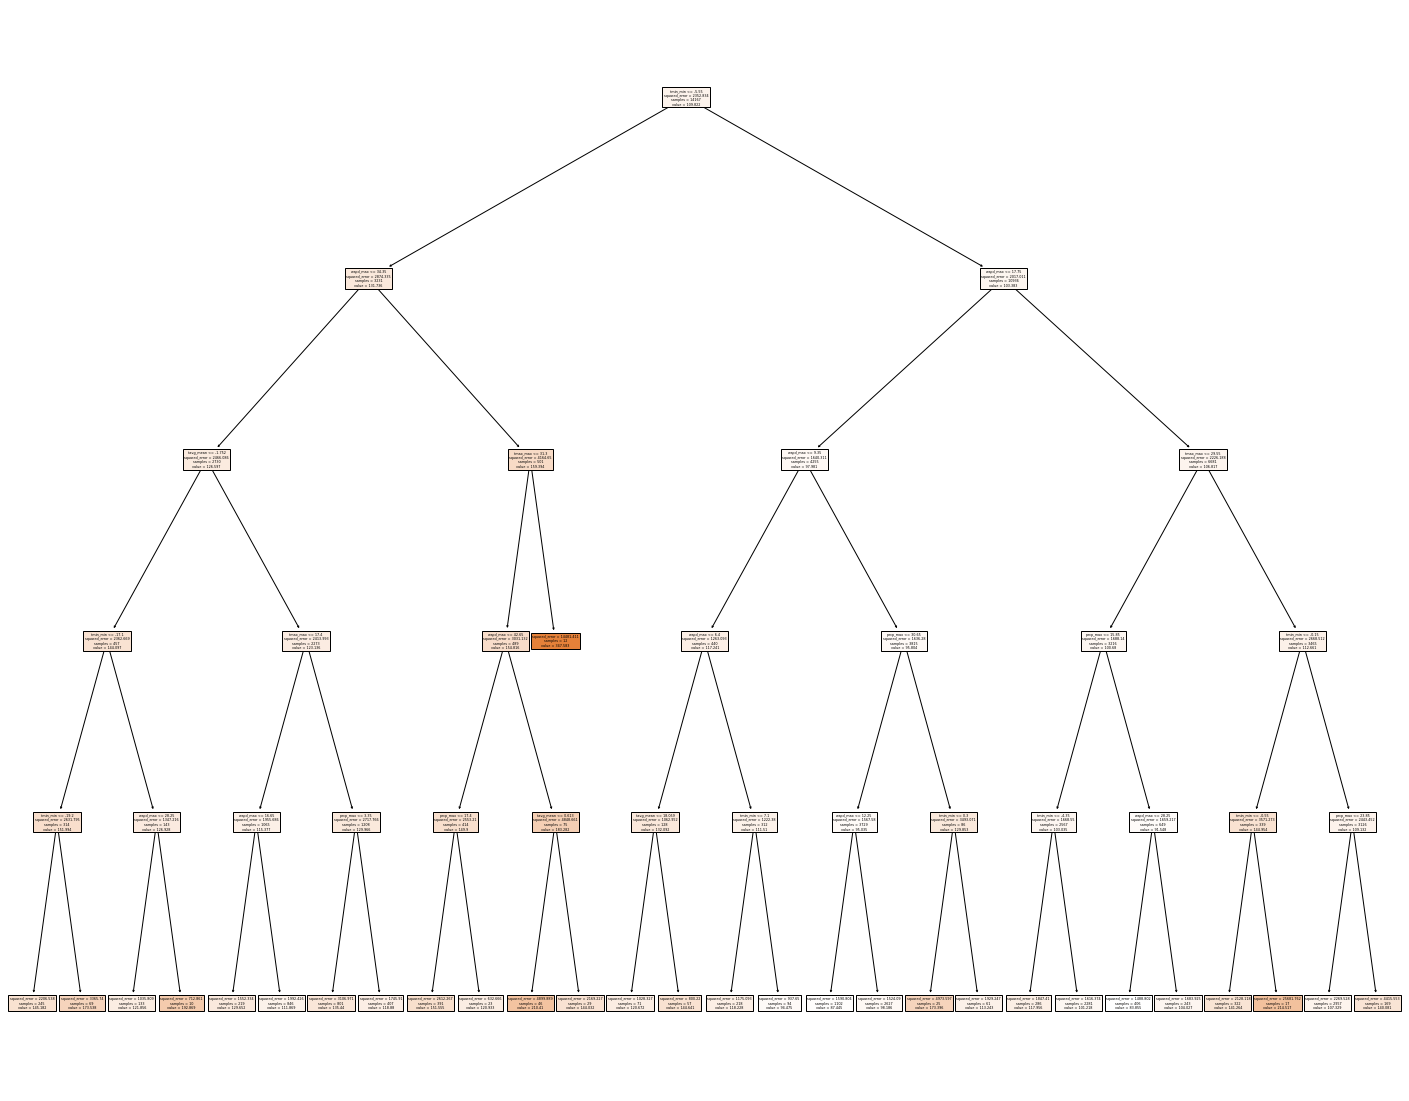

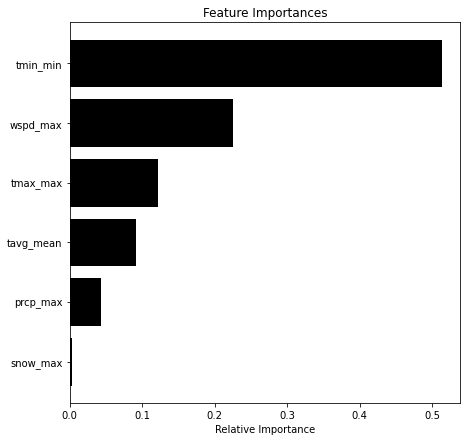

In [1028]:
#West Weather 
west_weather_results = train_test_split(west_resampled, weather_vars, [])
west_weather_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', west_weather_results[0], west_weather_results[1], west_weather_results[2], west_weather_results[3] )

30936
Length Training Set:  22482
Training Set Ratio:  0.7267261442979054
Length Testing Set:  8454
Testing Set Ratio:  0.27327385570209467
Best Parameters for Model:  {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 200}
Train Error is:  -0.4519517548639135
Test Error is: 0.5320
Feature:  prop_65_85_up Importantance:  0.05725971706868125
Feature:  prop_female Importantance:  0.2618868989166215
Feature:  prop_white_nh Importantance:  0.06801330014484039
Feature:  pop_density Importantance:  0.6128400838698569


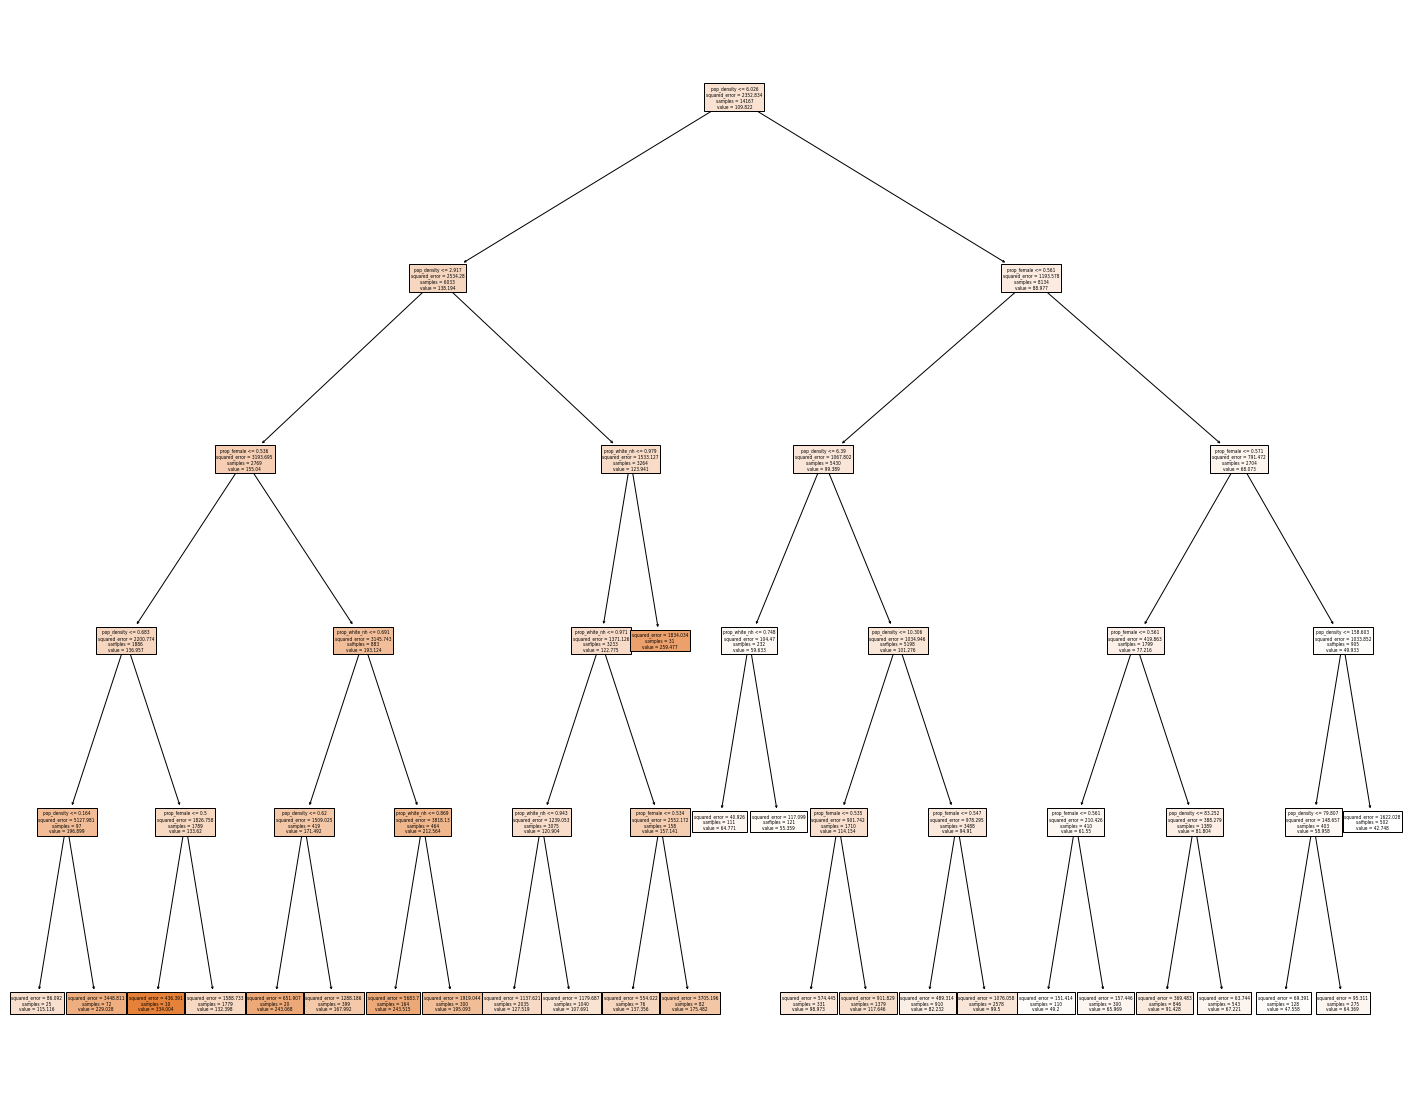

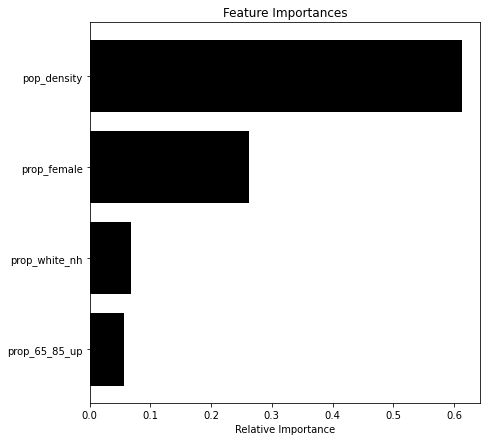

In [1029]:
#West demo 
west_demo_results = train_test_split(west_resampled, demo_vars, [])
west_demo_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', west_demo_results[0], west_demo_results[1], west_demo_results[2], west_demo_results[3] )

30936
Length Training Set:  22482
Training Set Ratio:  0.7267261442979054
Length Testing Set:  8454
Testing Set Ratio:  0.27327385570209467
Best Parameters for Model:  {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 200}
Train Error is:  -0.4972379621938301
Test Error is: 0.5551
Feature:  median_income Importantance:  0.45386111462043827
Feature:  gini_index Importantance:  0.24978475339795556
Feature:  prop_poor Importantance:  0.2963541319816063


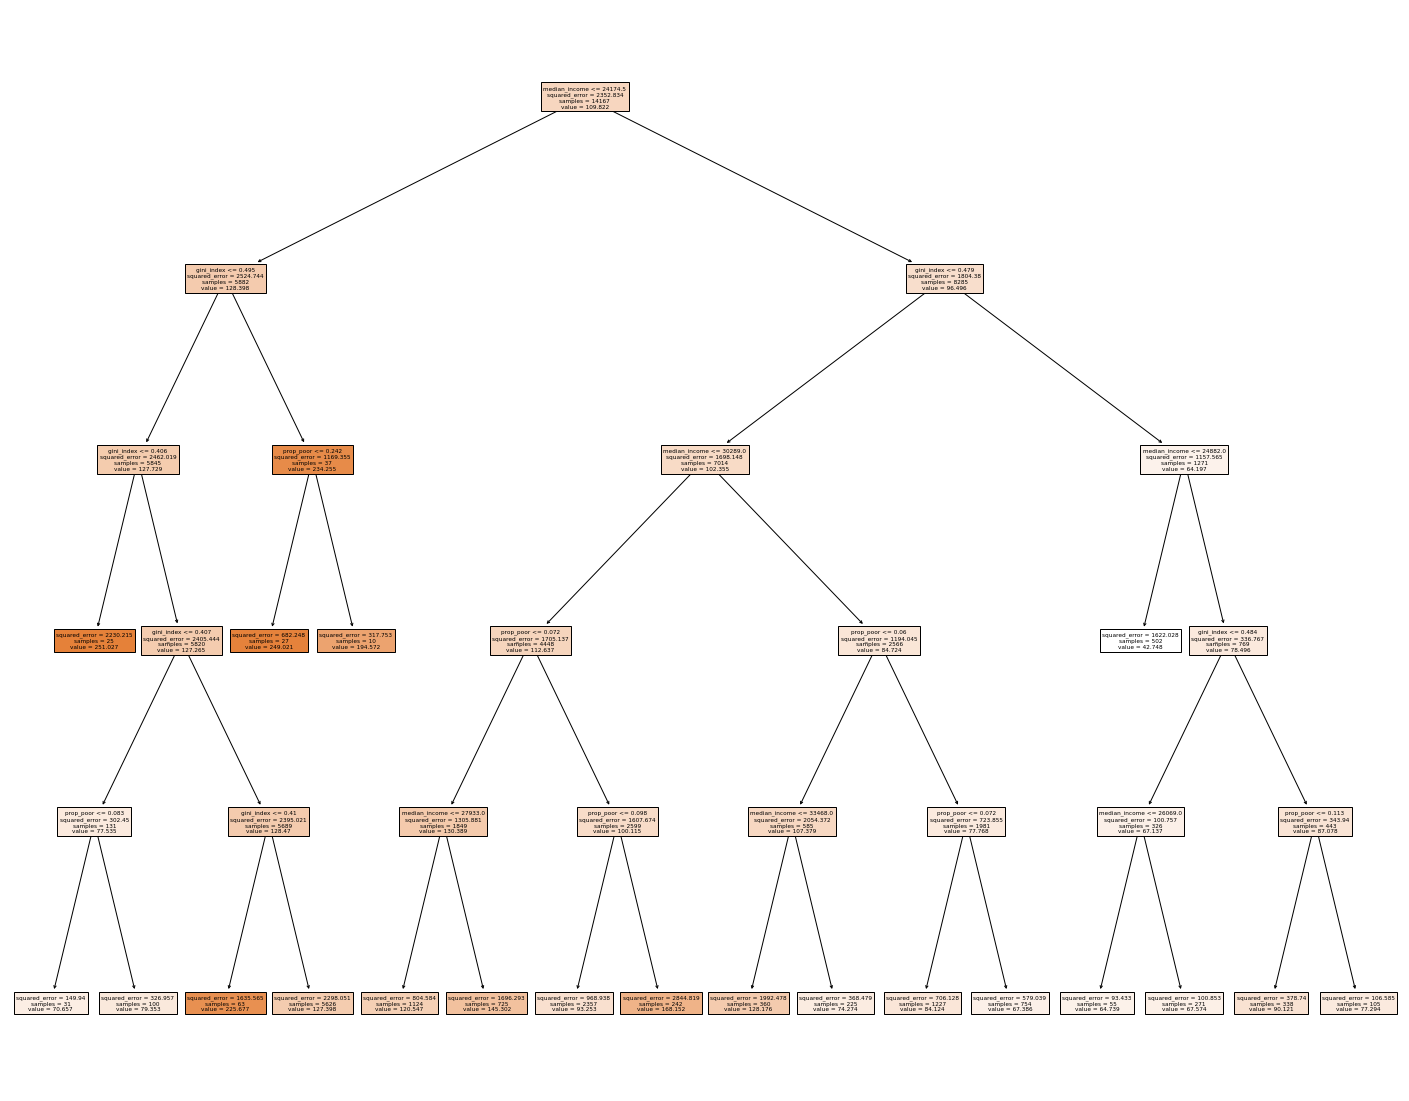

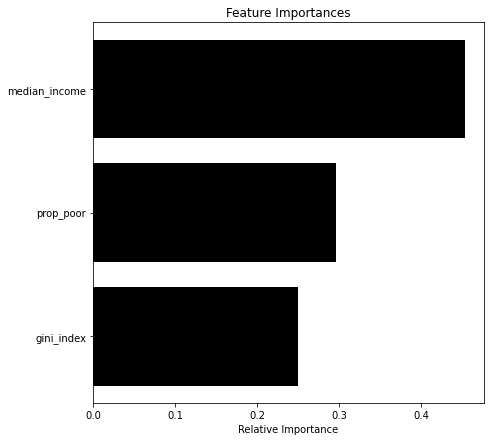

In [1030]:
#West Econ 
west_econ_results = train_test_split(west_resampled, econ_vars, [])
west_econ_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', west_econ_results[0], west_econ_results[1], west_econ_results[2], west_econ_results[3] )

30936
Length Training Set:  22482
Training Set Ratio:  0.7267261442979054
Length Testing Set:  8454
Testing Set Ratio:  0.27327385570209467
Best Parameters for Model:  {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 200}
Train Error is:  -0.44305023604661886
Test Error is: 0.5325
Feature:  tavg_mean Importantance:  0.0007604060107438624
Feature:  tmin_min Importantance:  0.009557584426837396
Feature:  tmax_max Importantance:  0.0017609508656410598
Feature:  prcp_max Importantance:  0.0034030657299055295
Feature:  snow_max Importantance:  6.3261873659289126e-06
Feature:  wspd_max Importantance:  0.0021130463219823674
Feature:  prop_65_85_up Importantance:  0.019661106418029414
Feature:  prop_female Importantance:  0.22078749448288454
Feature:  prop_white_nh Importantance:  0.03205926682507221
Feature:  pop_density Importantance:  0.5508731414828643
Feature:  median_income Importantance:  0.059188951651436526
Feature:  gini_index Importantance:  0.07970980451663655
Feature:  pro

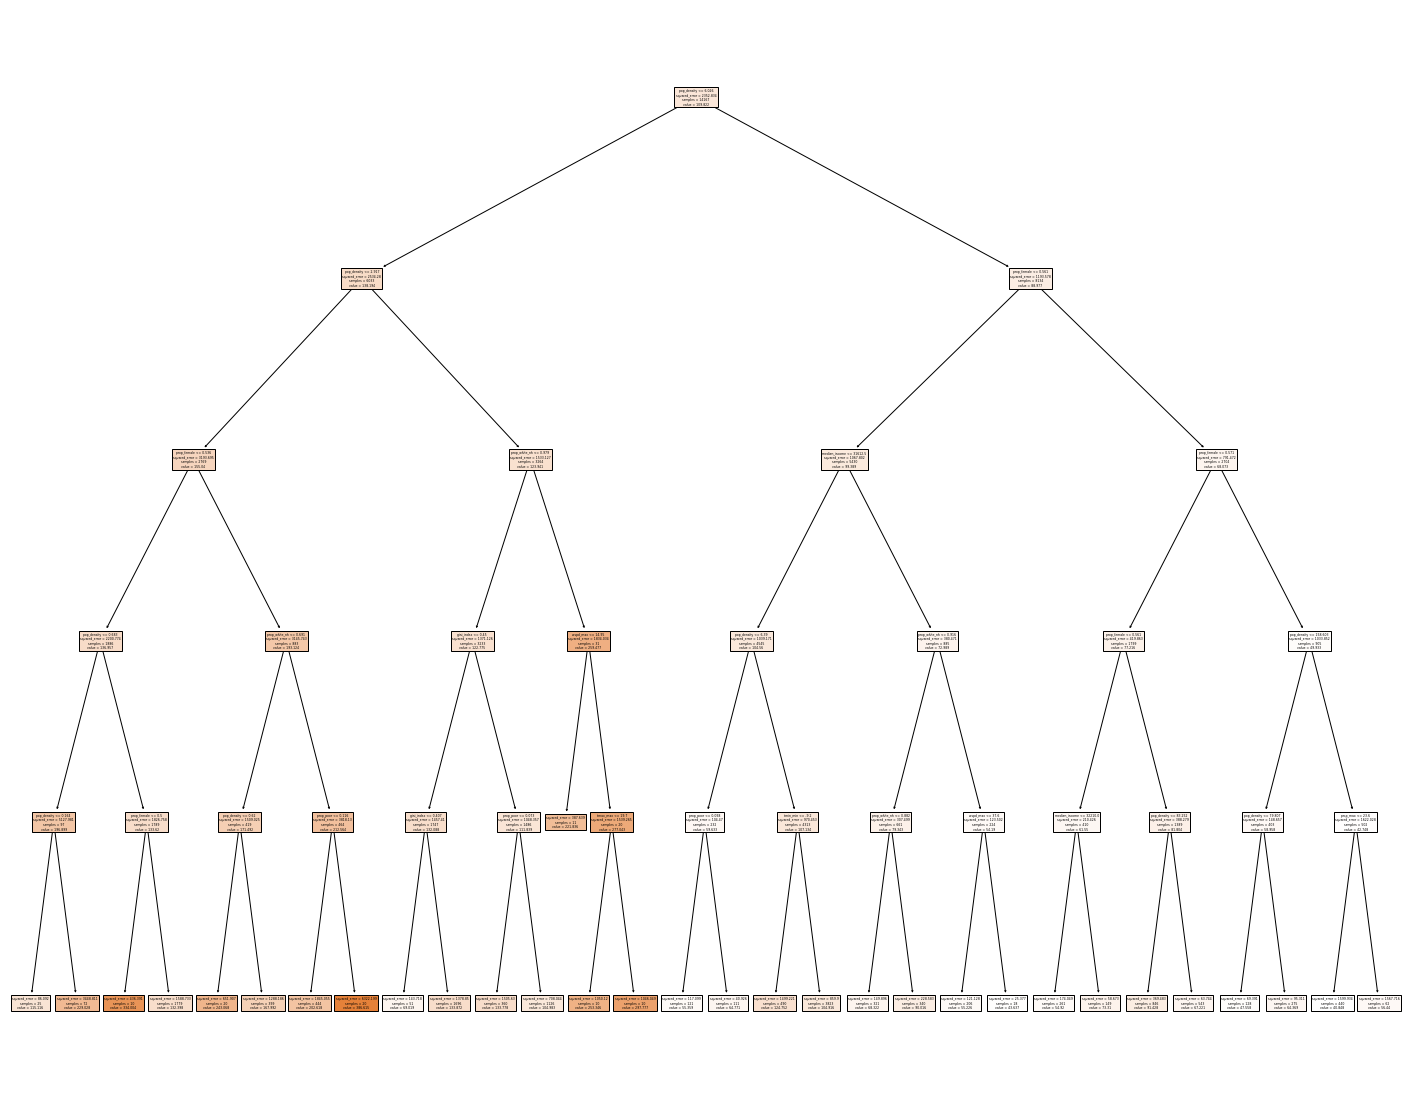

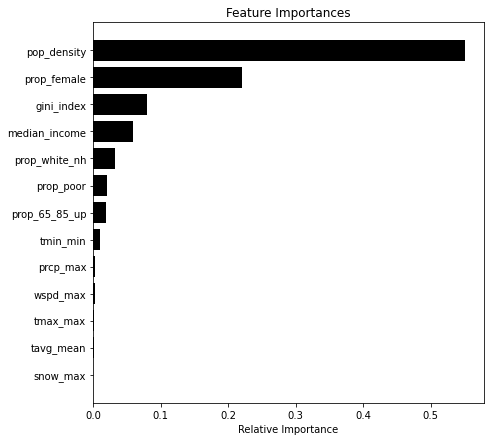

In [1031]:
#West Full 
west_full_results = train_test_split(west_resampled, full_vars, [])
west_full_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', west_full_results[0], west_full_results[1], west_full_results[2], west_full_results[3] )

In [1032]:
#Midwest Sampling
midwest_resampled = resample(midwest_time_df, n_samples = 30936, random_state=42)
print(len(midwest_resampled))

30936


30936
Length Training Set:  22759
Training Set Ratio:  0.7356801137832946
Length Testing Set:  8177
Testing Set Ratio:  0.26431988621670544
Best Parameters for Model:  {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 200}
Train Error is:  -0.3164149565011552
Test Error is: 0.3193
Feature:  tavg_mean Importantance:  0.0774104870718508
Feature:  tmin_min Importantance:  0.16545761688548752
Feature:  tmax_max Importantance:  0.2823050238755007
Feature:  prcp_max Importantance:  0.1721207352936098
Feature:  snow_max Importantance:  0.019864115209520715
Feature:  wspd_max Importantance:  0.2828420216640304


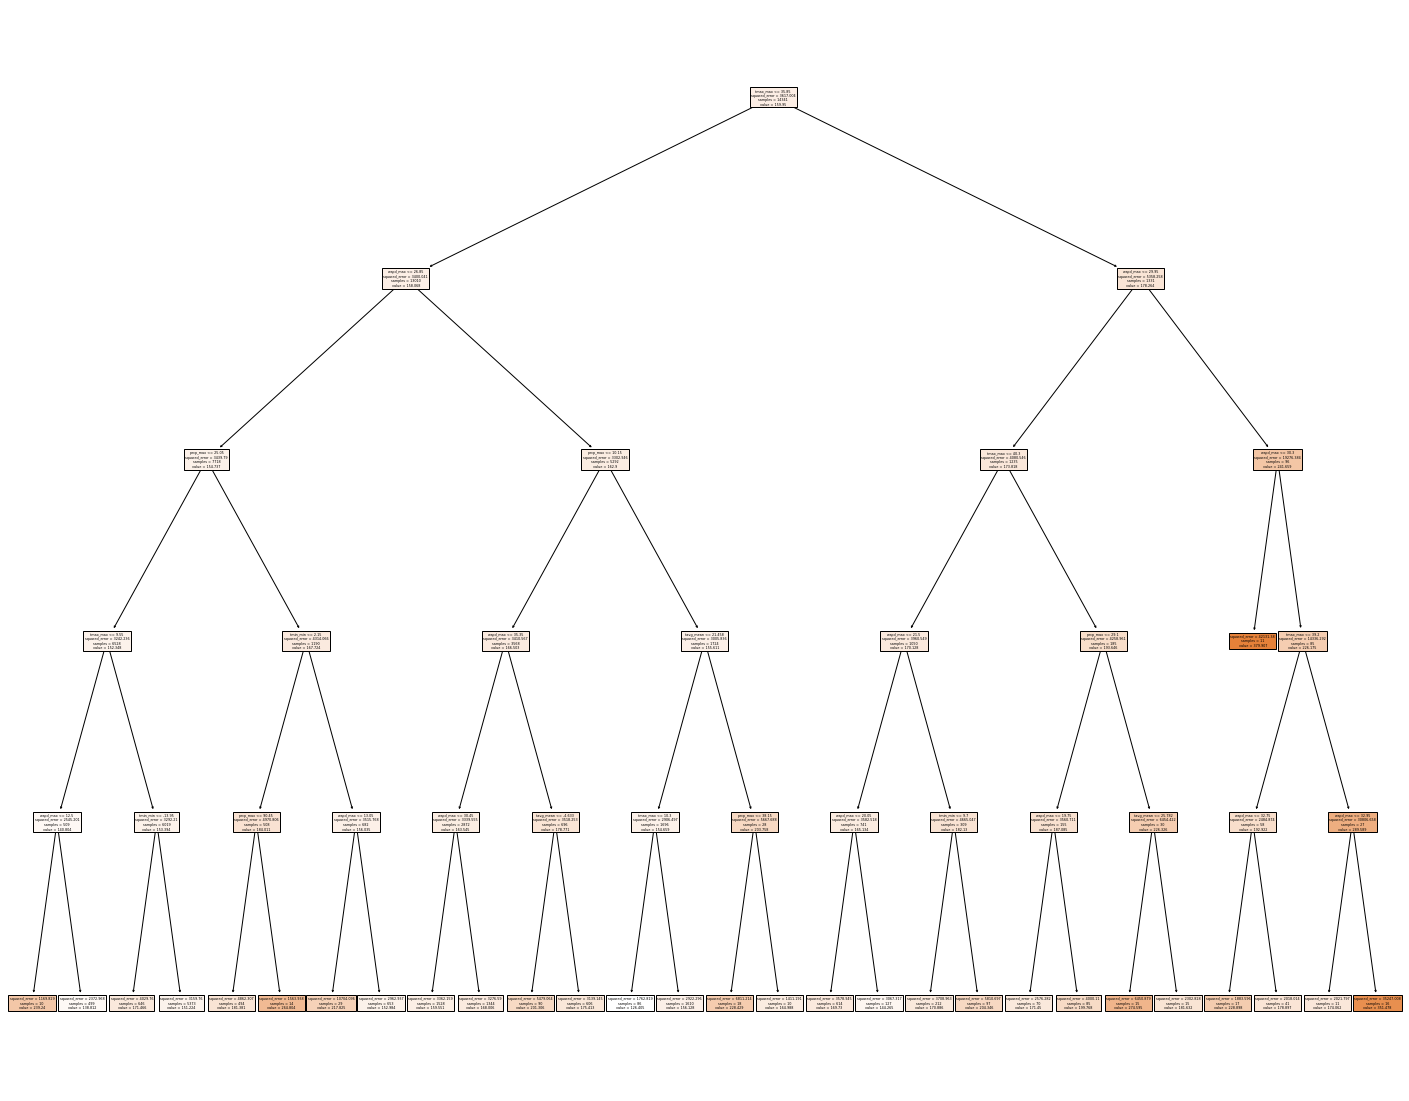

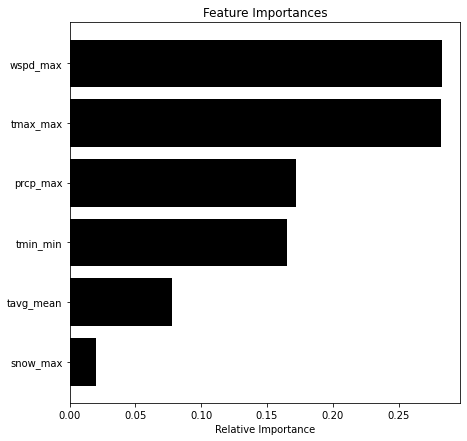

In [1033]:
#Midwest Weather 
midwest_weather_results = train_test_split(midwest_resampled, weather_vars, [])
midwest_weather_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', midwest_weather_results[0], midwest_weather_results[1], midwest_weather_results[2], midwest_weather_results[3] )

30936
Length Training Set:  22759
Training Set Ratio:  0.7356801137832946
Length Testing Set:  8177
Testing Set Ratio:  0.26431988621670544
Best Parameters for Model:  {'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 50}
Train Error is:  -0.2280846280995684
Test Error is: 0.2470
Feature:  prop_65_85_up Importantance:  0.03174013348952088
Feature:  prop_female Importantance:  0.16108843960181773
Feature:  prop_white_nh Importantance:  0.08899709305705128
Feature:  pop_density Importantance:  0.7181743338516102


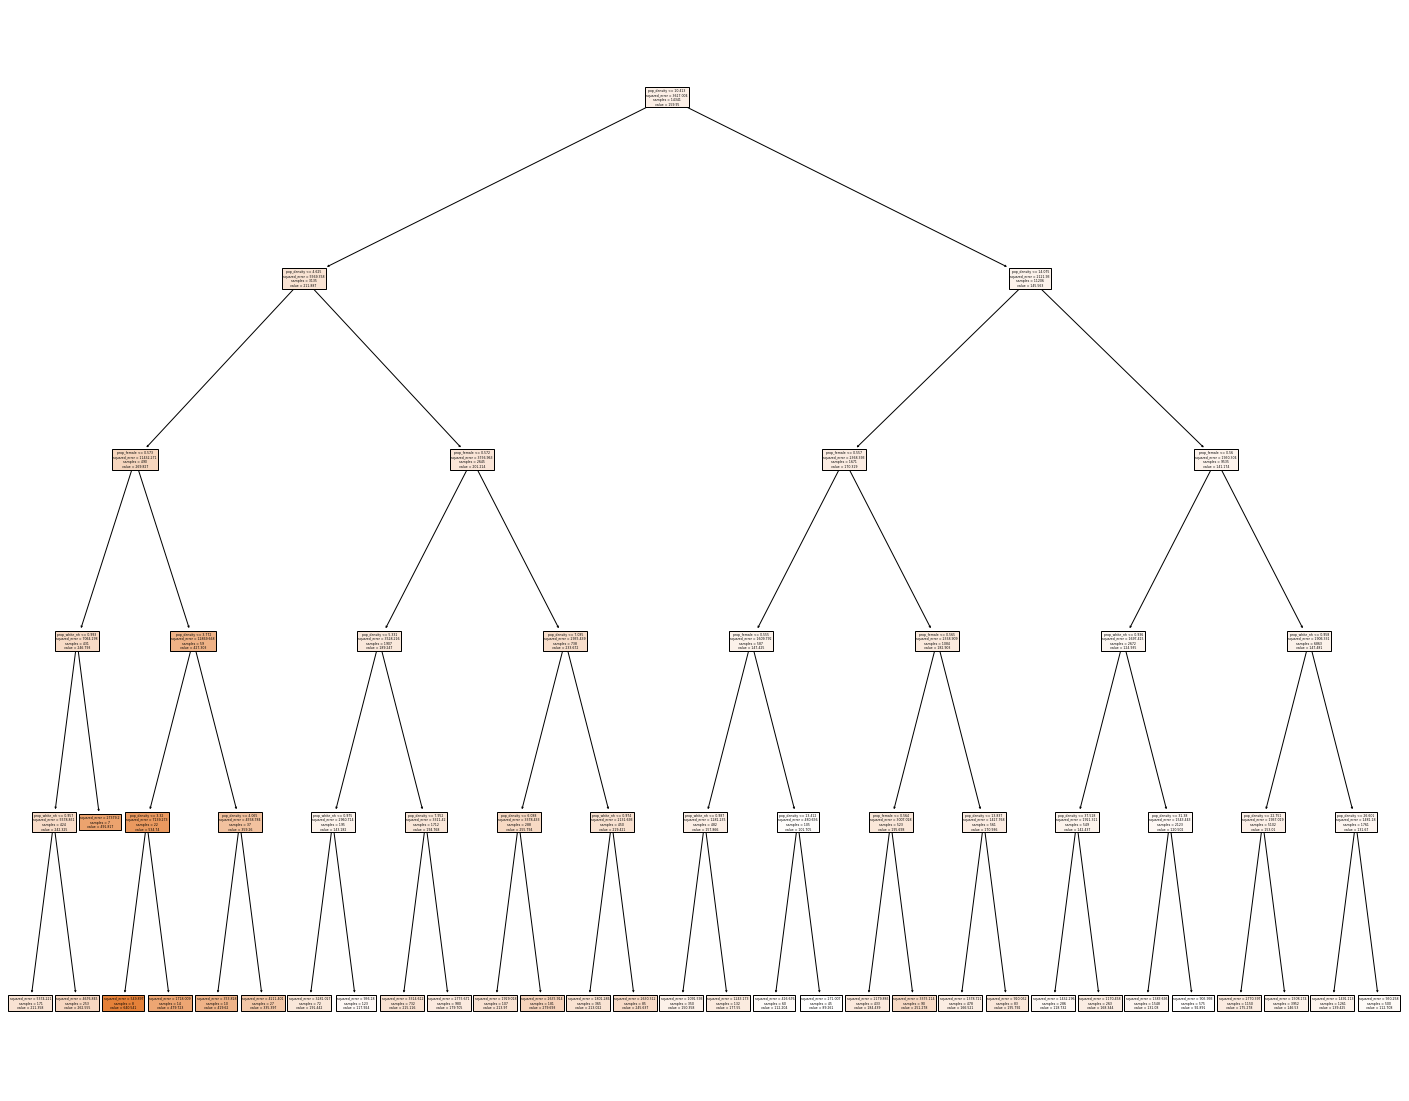

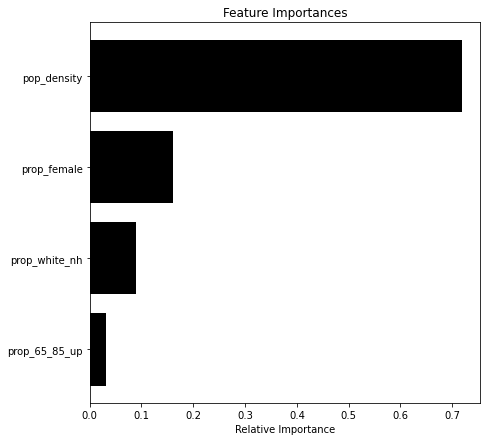

In [1034]:
#Midwest demo 
midwest_demo_results = train_test_split(midwest_resampled, demo_vars, [])
midwest_demo_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', midwest_demo_results[0], midwest_demo_results[1], midwest_demo_results[2], midwest_demo_results[3] )

30936
Length Training Set:  22759
Training Set Ratio:  0.7356801137832946
Length Testing Set:  8177
Testing Set Ratio:  0.26431988621670544
Best Parameters for Model:  {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 200}
Train Error is:  -0.26825718103839663
Test Error is: 0.2810
Feature:  median_income Importantance:  0.5401906677102118
Feature:  gini_index Importantance:  0.290945966528355
Feature:  prop_poor Importantance:  0.1688633657614332


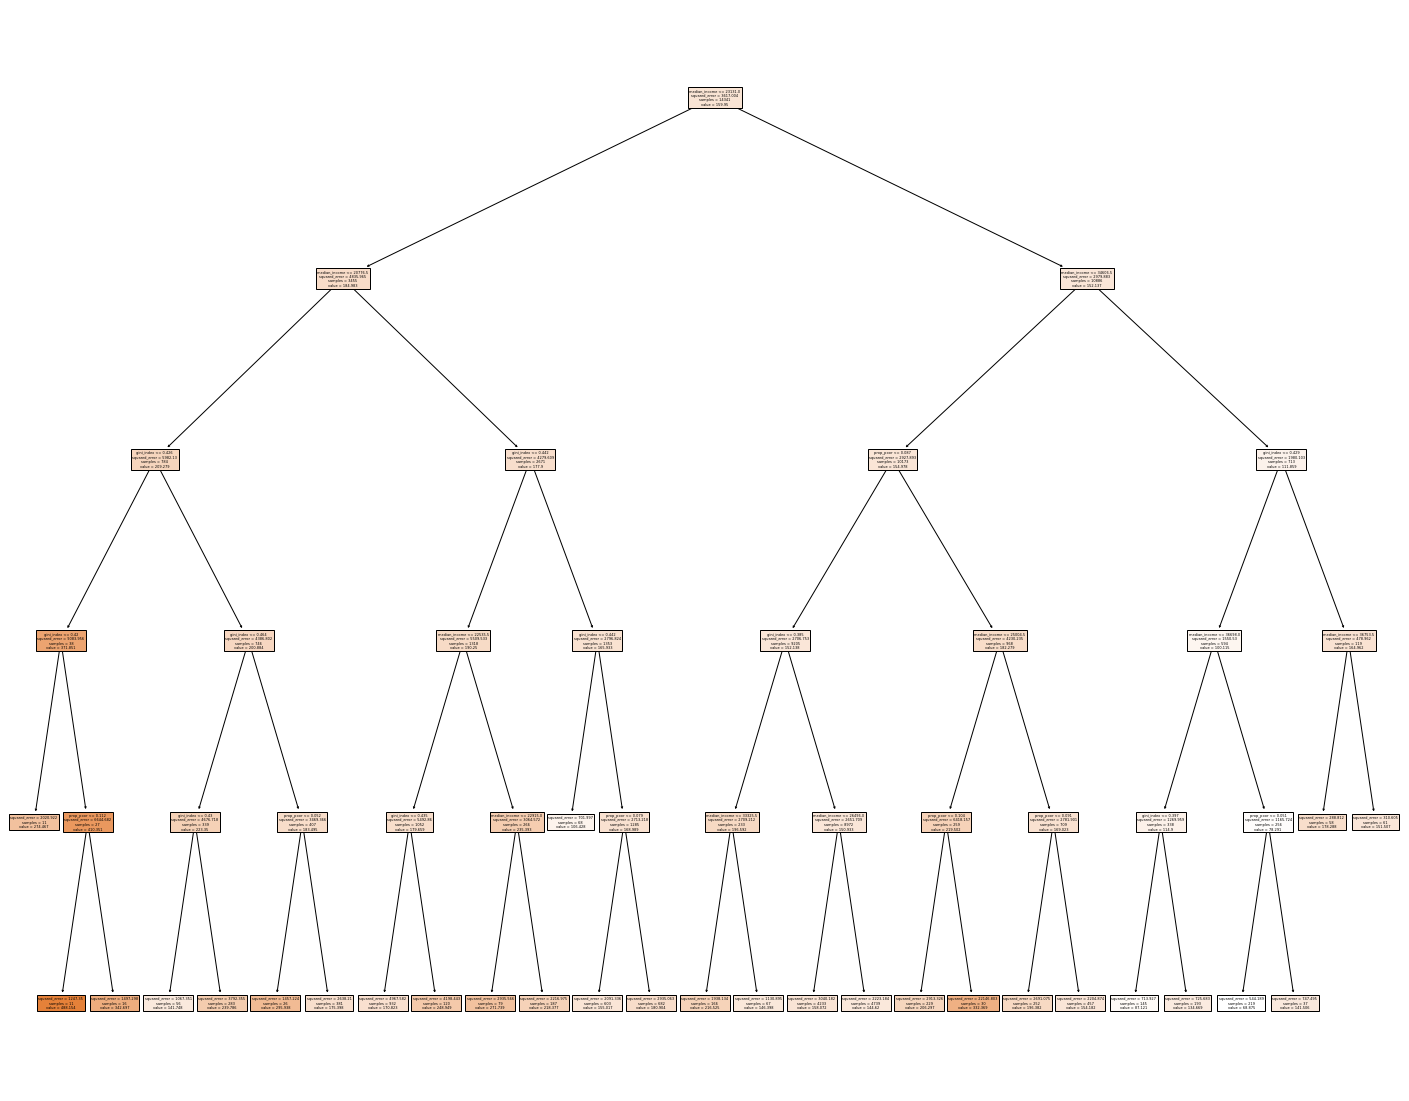

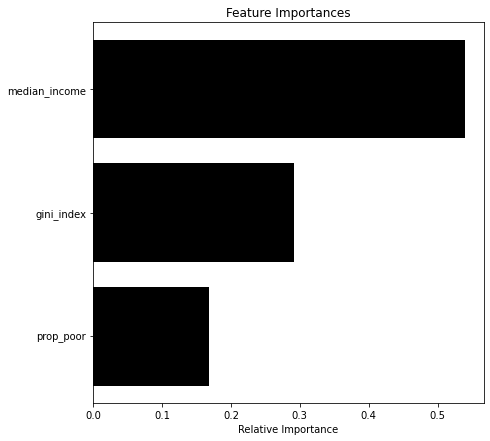

In [1035]:
#midwest Econ 
midwest_econ_results = train_test_split(midwest_resampled, econ_vars, [])
midwest_econ_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', midwest_econ_results[0], midwest_econ_results[1], midwest_econ_results[2], midwest_econ_results[3] )

30936
Length Training Set:  22759
Training Set Ratio:  0.7356801137832946
Length Testing Set:  8177
Testing Set Ratio:  0.26431988621670544
Best Parameters for Model:  {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 50}
Train Error is:  -0.22582983050432434
Test Error is: 0.2454
Feature:  tavg_mean Importantance:  0.00032131991729208965
Feature:  tmin_min Importantance:  0.00012718951604148026
Feature:  tmax_max Importantance:  0.0012337276351979348
Feature:  prcp_max Importantance:  0.001649008600694247
Feature:  snow_max Importantance:  2.8147340220907318e-05
Feature:  wspd_max Importantance:  0.002236602194563084
Feature:  prop_65_85_up Importantance:  0.025052557170254626
Feature:  prop_female Importantance:  0.13832537566649272
Feature:  prop_white_nh Importantance:  0.05074126455165154
Feature:  pop_density Importantance:  0.6883832199276955
Feature:  median_income Importantance:  0.04104514073712887
Feature:  gini_index Importantance:  0.03318514820470425
Feature:  prop

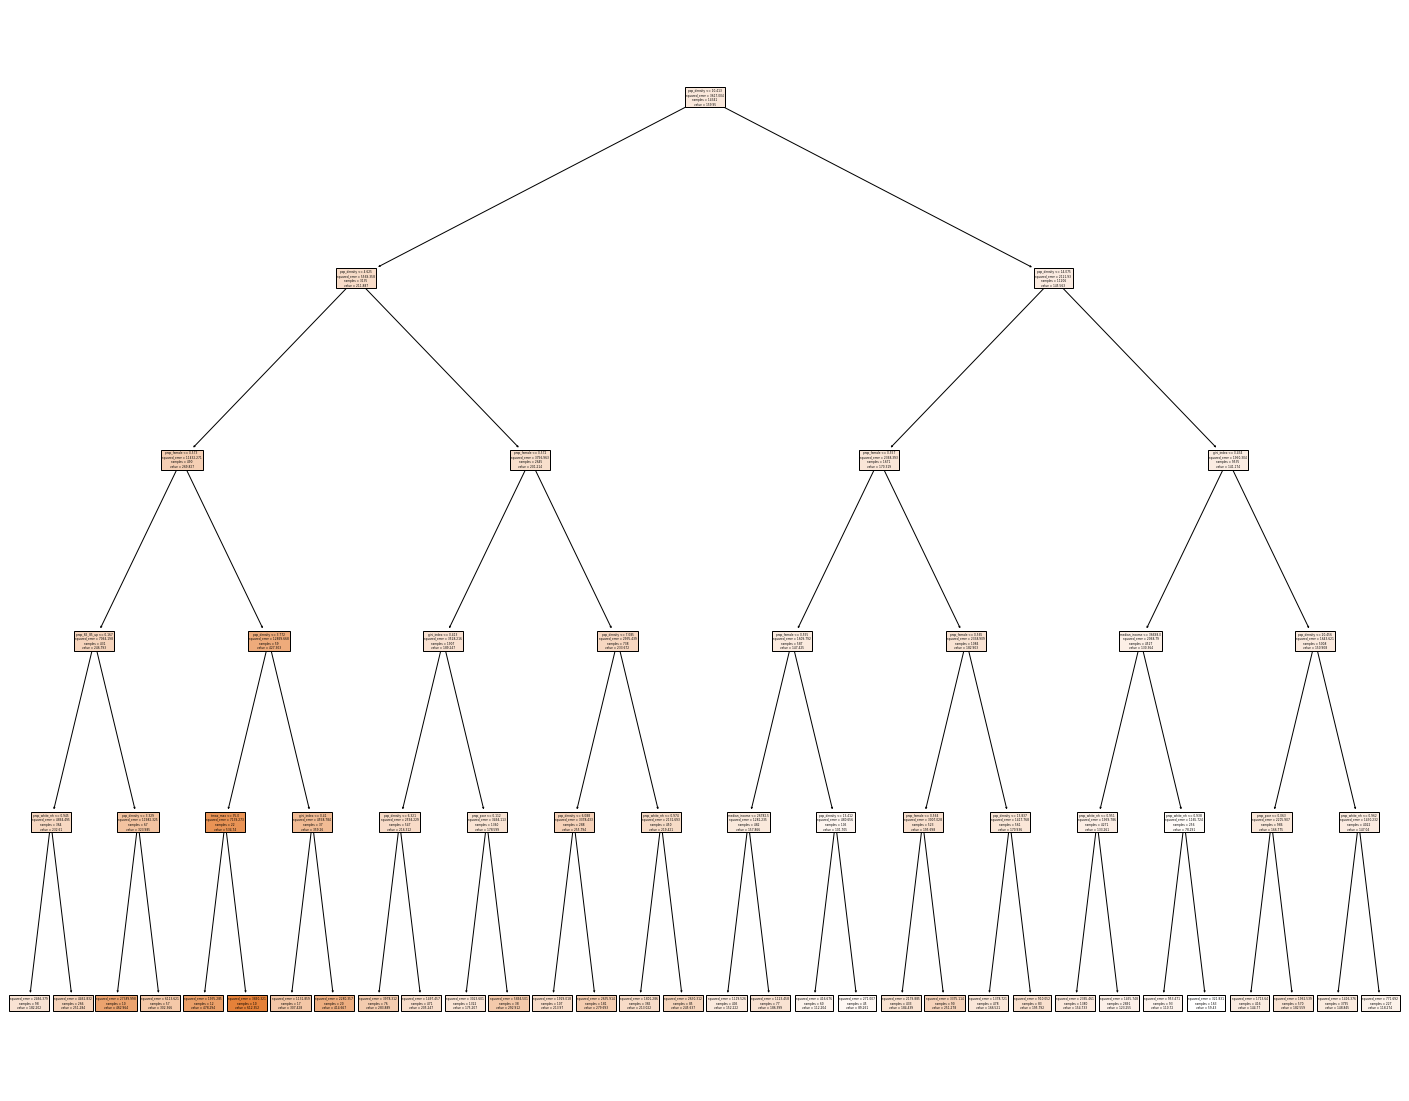

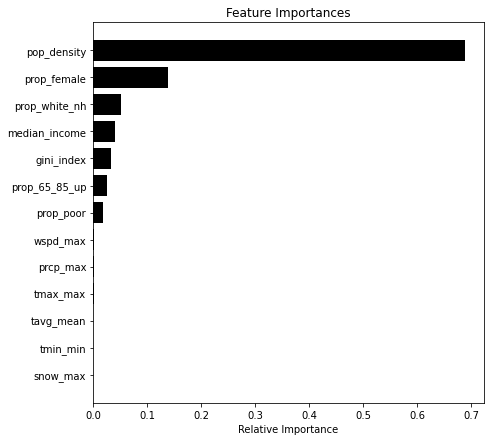

In [1036]:
#midwest Full 
midwest_full_results = train_test_split(midwest_resampled, full_vars, [])
midwest_full_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', midwest_full_results[0], midwest_full_results[1], midwest_full_results[2], midwest_full_results[3] )

30936
Length Training Set:  22545
Training Set Ratio:  0.7287626066718387
Length Testing Set:  8391
Testing Set Ratio:  0.2712373933281614
Best Parameters for Model:  {'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 50}
Train Error is:  -0.3479803048424874
Test Error is: 0.3172
Feature:  tavg_mean Importantance:  0.4569370863676942
Feature:  tmin_min Importantance:  0.44315424986355706
Feature:  tmax_max Importantance:  0.03768938297307615
Feature:  prcp_max Importantance:  0.047401081500149246
Feature:  snow_max Importantance:  0.0
Feature:  wspd_max Importantance:  0.014818199295523448


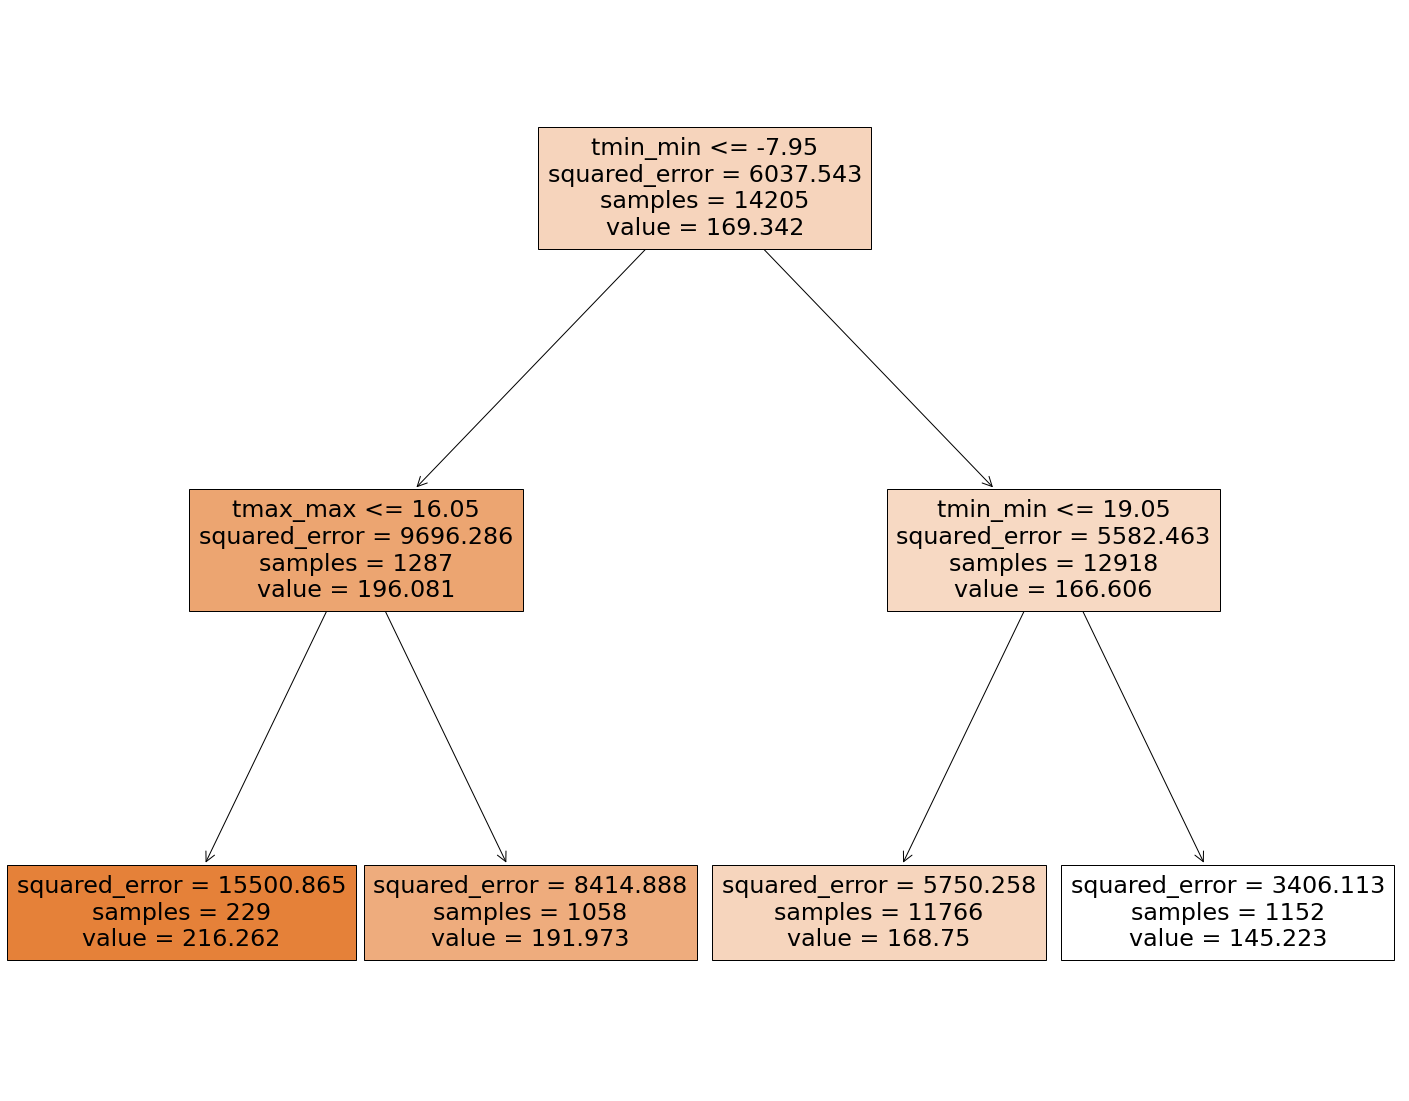

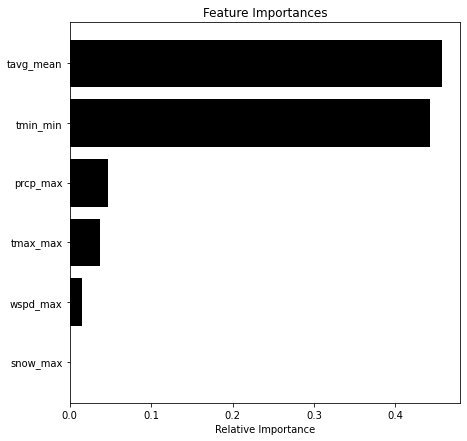

In [1037]:
#South - doesn't need sampling

#South Weather 
south_weather_results = train_test_split(south_time_df, weather_vars, [])
south_weather_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', south_weather_results[0], south_weather_results[1], south_weather_results[2], south_weather_results[3] )

30936
Length Training Set:  22545
Training Set Ratio:  0.7287626066718387
Length Testing Set:  8391
Testing Set Ratio:  0.2712373933281614
Best Parameters for Model:  {'max_depth': 4, 'min_samples_leaf': 1, 'n_estimators': 200}
Train Error is:  -0.30232806183270733
Test Error is: 0.2616
Feature:  prop_65_85_up Importantance:  0.15350799531361523
Feature:  prop_female Importantance:  0.07809462347868094
Feature:  prop_white_nh Importantance:  0.22386393881576447
Feature:  pop_density Importantance:  0.5445334423919393


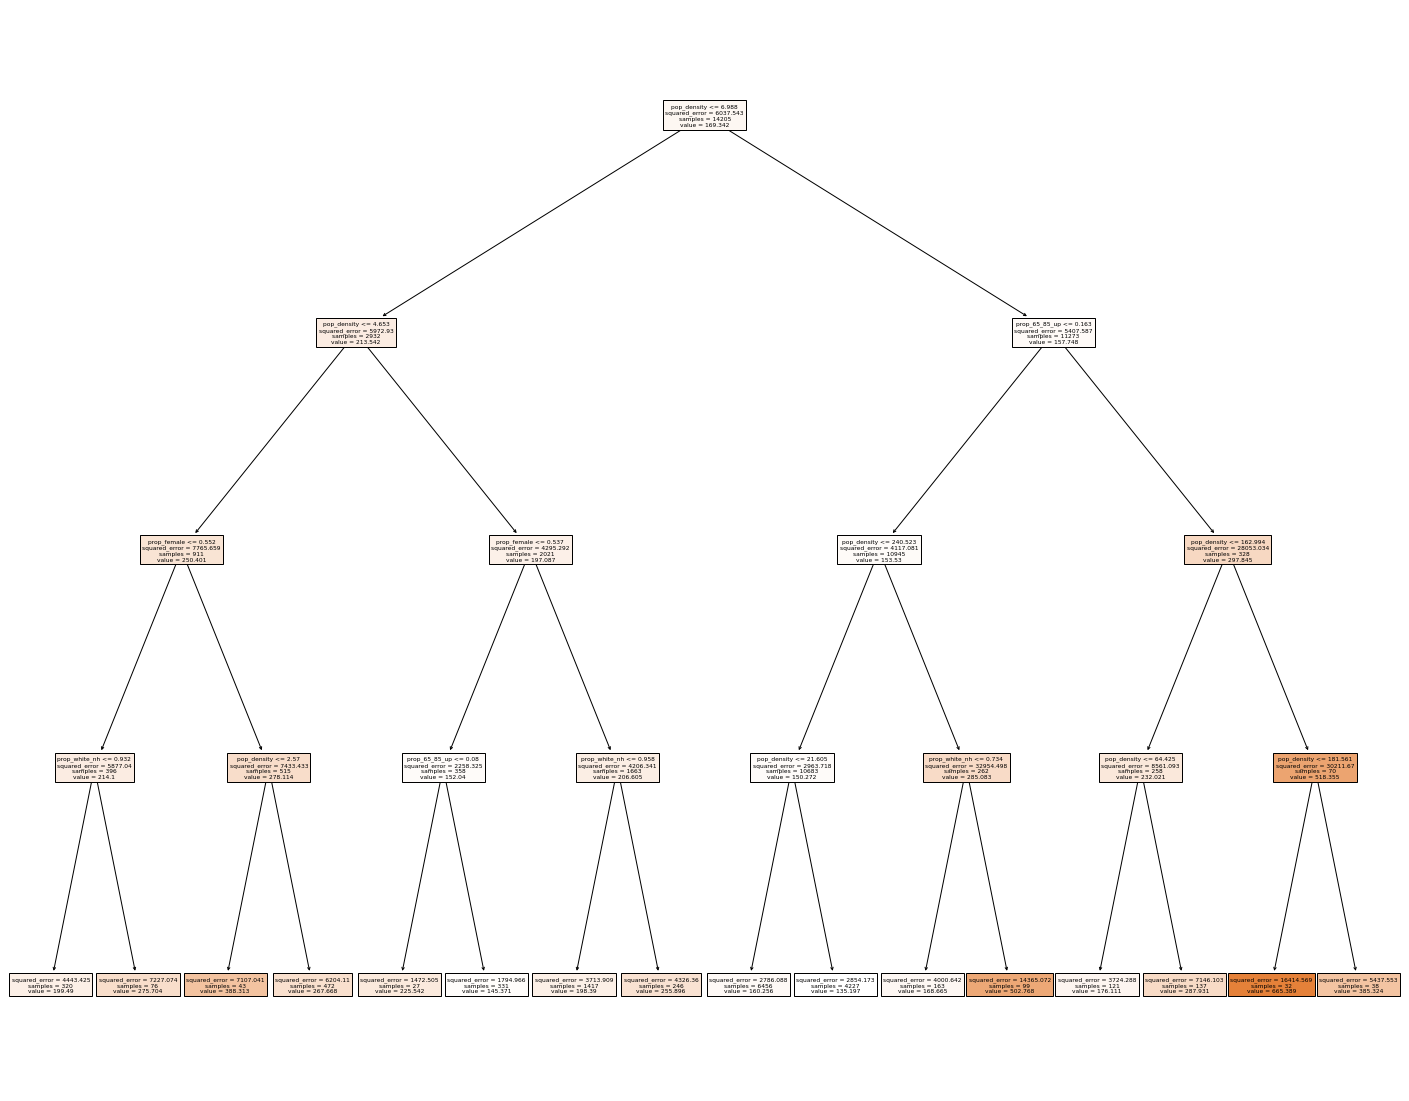

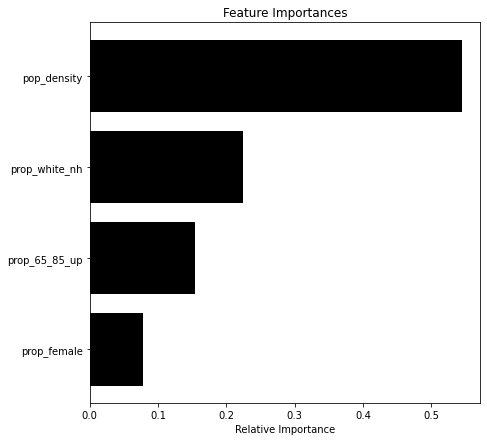

In [1038]:
#South demo 
south_demo_results = train_test_split(south_time_df, demo_vars, [])
south_demo_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', south_demo_results[0], south_demo_results[1], south_demo_results[2], south_demo_results[3] )

30936
Length Training Set:  22545
Training Set Ratio:  0.7287626066718387
Length Testing Set:  8391
Testing Set Ratio:  0.2712373933281614
Best Parameters for Model:  {'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 200}
Train Error is:  -0.31402158070315916
Test Error is: 0.2969
Feature:  median_income Importantance:  1.0
Feature:  gini_index Importantance:  0.0
Feature:  prop_poor Importantance:  0.0


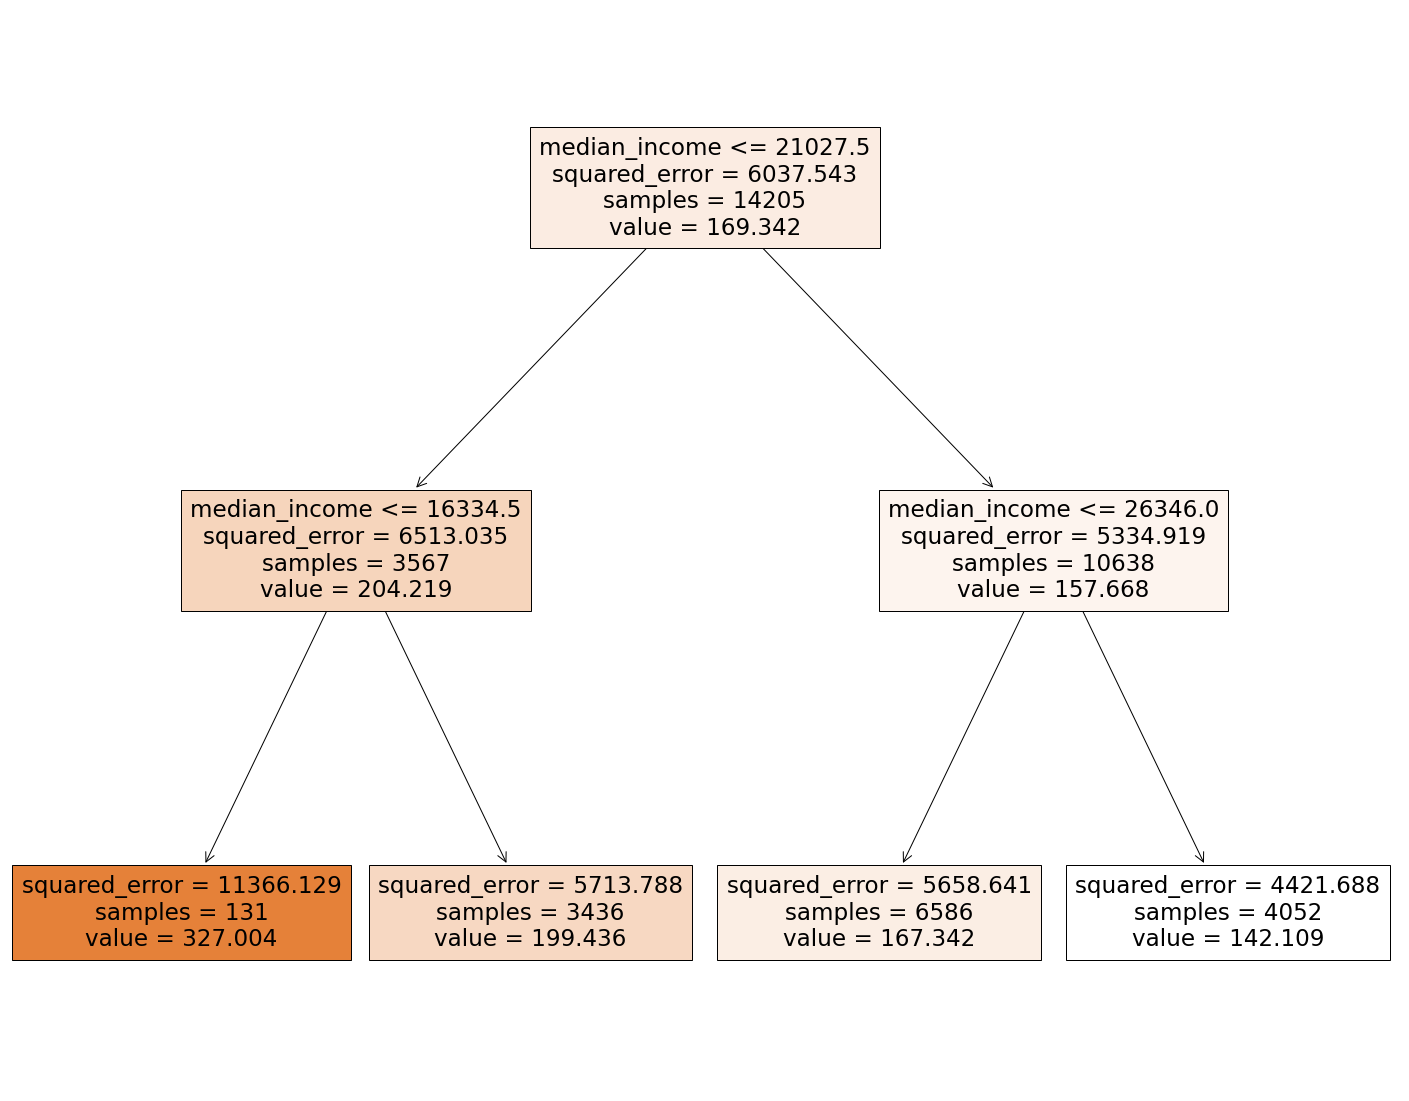

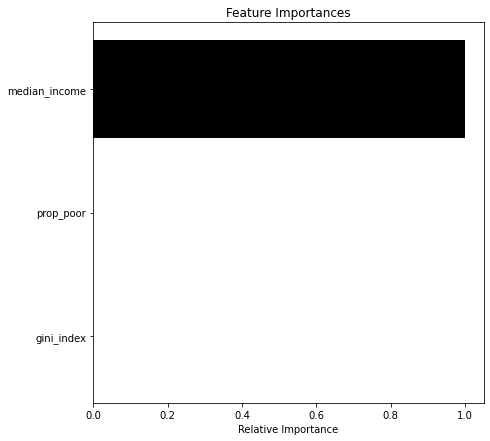

In [1039]:
#South Econ 
south_econ_results = train_test_split(south_time_df, econ_vars, [])
south_econ_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', south_econ_results[0], south_econ_results[1], south_econ_results[2], south_econ_results[3] )

30936
Length Training Set:  22545
Training Set Ratio:  0.7287626066718387
Length Testing Set:  8391
Testing Set Ratio:  0.2712373933281614
Best Parameters for Model:  {'max_depth': 4, 'min_samples_leaf': 10, 'n_estimators': 200}
Train Error is:  -0.2979581843072999
Test Error is: 0.2628
Feature:  tavg_mean Importantance:  0.0
Feature:  tmin_min Importantance:  1.4595766957206362e-06
Feature:  tmax_max Importantance:  0.0
Feature:  prcp_max Importantance:  3.351438031196217e-05
Feature:  snow_max Importantance:  0.0
Feature:  wspd_max Importantance:  8.971782869817446e-05
Feature:  prop_65_85_up Importantance:  0.14016100725412675
Feature:  prop_female Importantance:  0.021277694584691708
Feature:  prop_white_nh Importantance:  0.18789849239887002
Feature:  pop_density Importantance:  0.46486307785175945
Feature:  median_income Importantance:  0.10072725749248913
Feature:  gini_index Importantance:  0.029597514933831656
Feature:  prop_poor Importantance:  0.05535026369852547


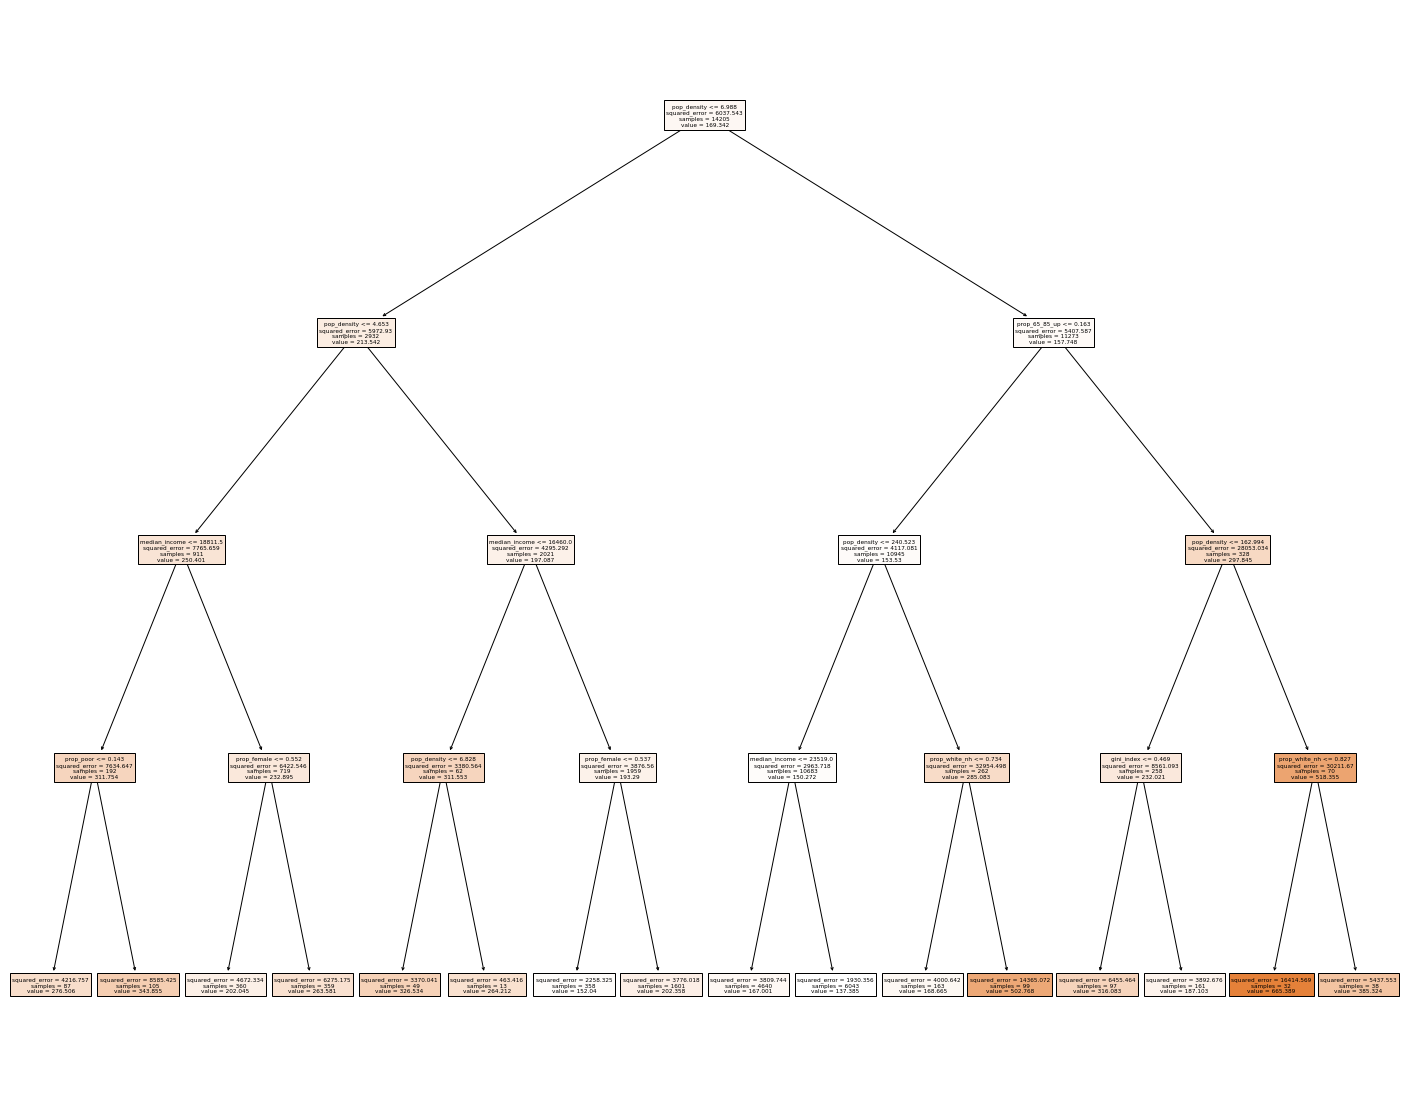

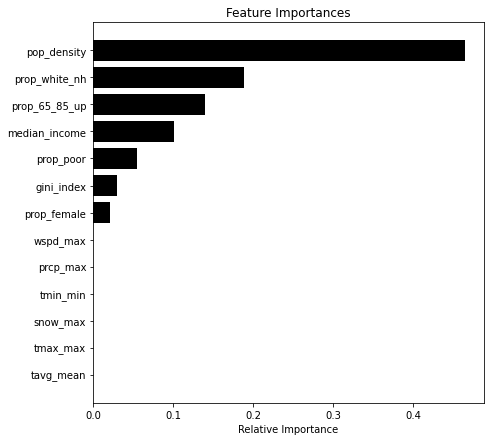

In [1040]:
#South Full 
south_full_results = train_test_split(south_time_df, full_vars, [])
south_full_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', south_full_results[0], south_full_results[1], south_full_results[2], south_full_results[3] )

In [1041]:
#Northeast resampling 
northeast_resampled = resample(northeast_time_df, n_samples = 30936, random_state=42)
print(len(northeast_resampled))

30936


30936
Length Training Set:  22695
Training Set Ratio:  0.733611326609775
Length Testing Set:  8241
Testing Set Ratio:  0.266388673390225
Best Parameters for Model:  {'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 200}
Train Error is:  -0.26602819801434646
Test Error is: 0.2955
Feature:  tavg_mean Importantance:  0.08688126578157938
Feature:  tmin_min Importantance:  0.21918578971928723
Feature:  tmax_max Importantance:  0.12460692612017313
Feature:  prcp_max Importantance:  0.15396081197172715
Feature:  snow_max Importantance:  0.10110307110343582
Feature:  wspd_max Importantance:  0.3142621353037972


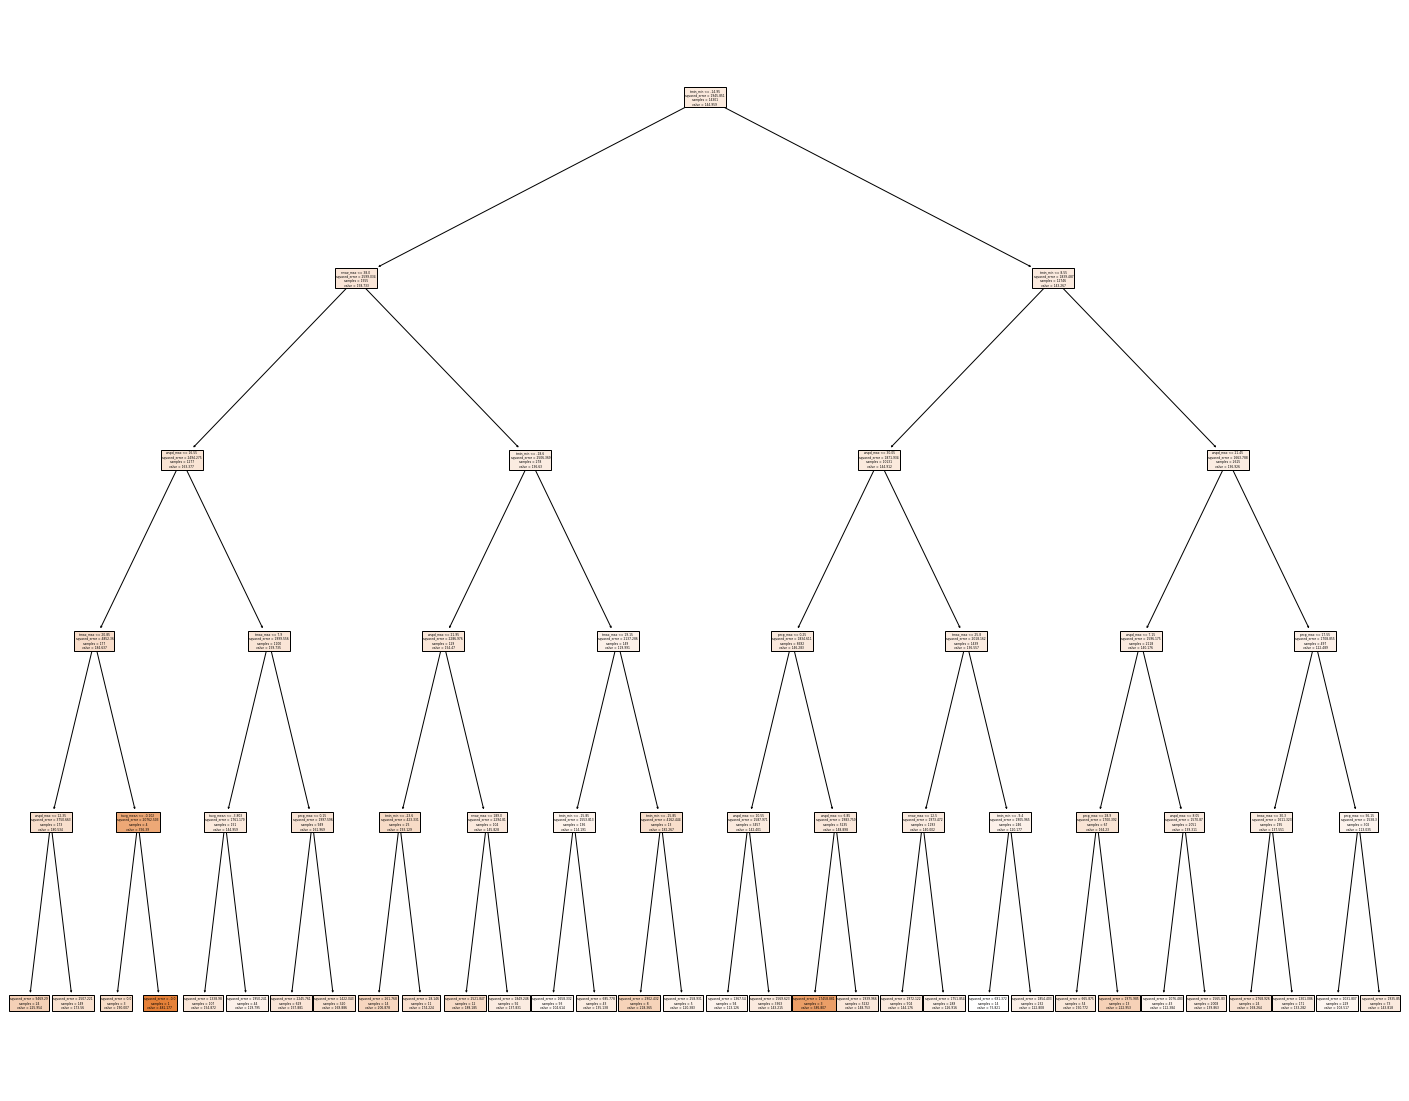

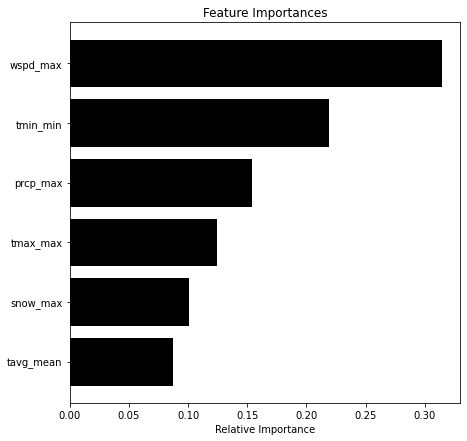

In [1042]:
#Northeast Weather 
northeast_weather_results = train_test_split(northeast_resampled, weather_vars, [])
northeast_weather_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', northeast_weather_results[0], northeast_weather_results[1], northeast_weather_results[2], northeast_weather_results[3] )

30936
Length Training Set:  22695
Training Set Ratio:  0.733611326609775
Length Testing Set:  8241
Testing Set Ratio:  0.266388673390225
Best Parameters for Model:  {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 50}
Train Error is:  -0.2252420024664773
Test Error is: 0.2480
Feature:  prop_65_85_up Importantance:  0.3668939064729225
Feature:  prop_female Importantance:  0.31740955794456077
Feature:  prop_white_nh Importantance:  0.17025008815530873
Feature:  pop_density Importantance:  0.14544644742720808


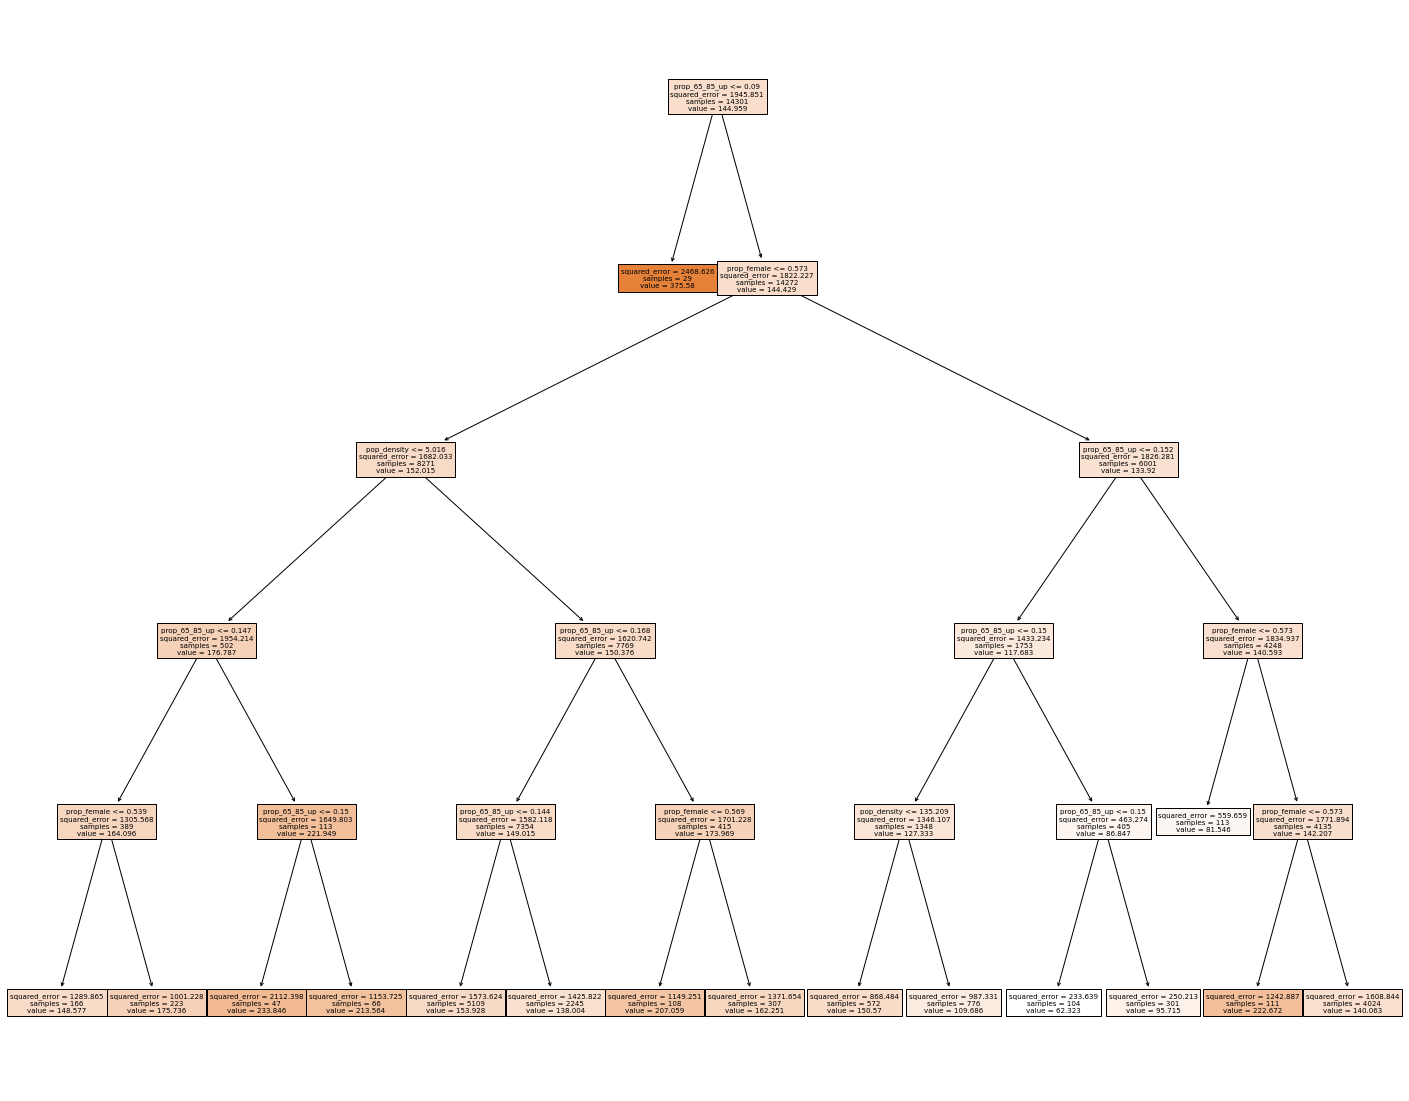

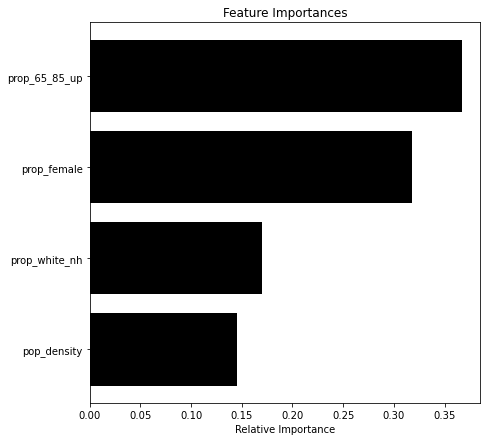

In [1043]:
#Northeast demo 
northeast_demo_results = train_test_split(northeast_resampled, demo_vars, [])
northeast_demo_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', northeast_demo_results[0], northeast_demo_results[1], northeast_demo_results[2], northeast_demo_results[3] )

30936
Length Training Set:  22695
Training Set Ratio:  0.733611326609775
Length Testing Set:  8241
Testing Set Ratio:  0.266388673390225
Best Parameters for Model:  {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 50}
Train Error is:  -0.22460578928173222
Test Error is: 0.2407
Feature:  median_income Importantance:  0.41739397649843557
Feature:  gini_index Importantance:  0.11969725805583606
Feature:  prop_poor Importantance:  0.46290876544572834


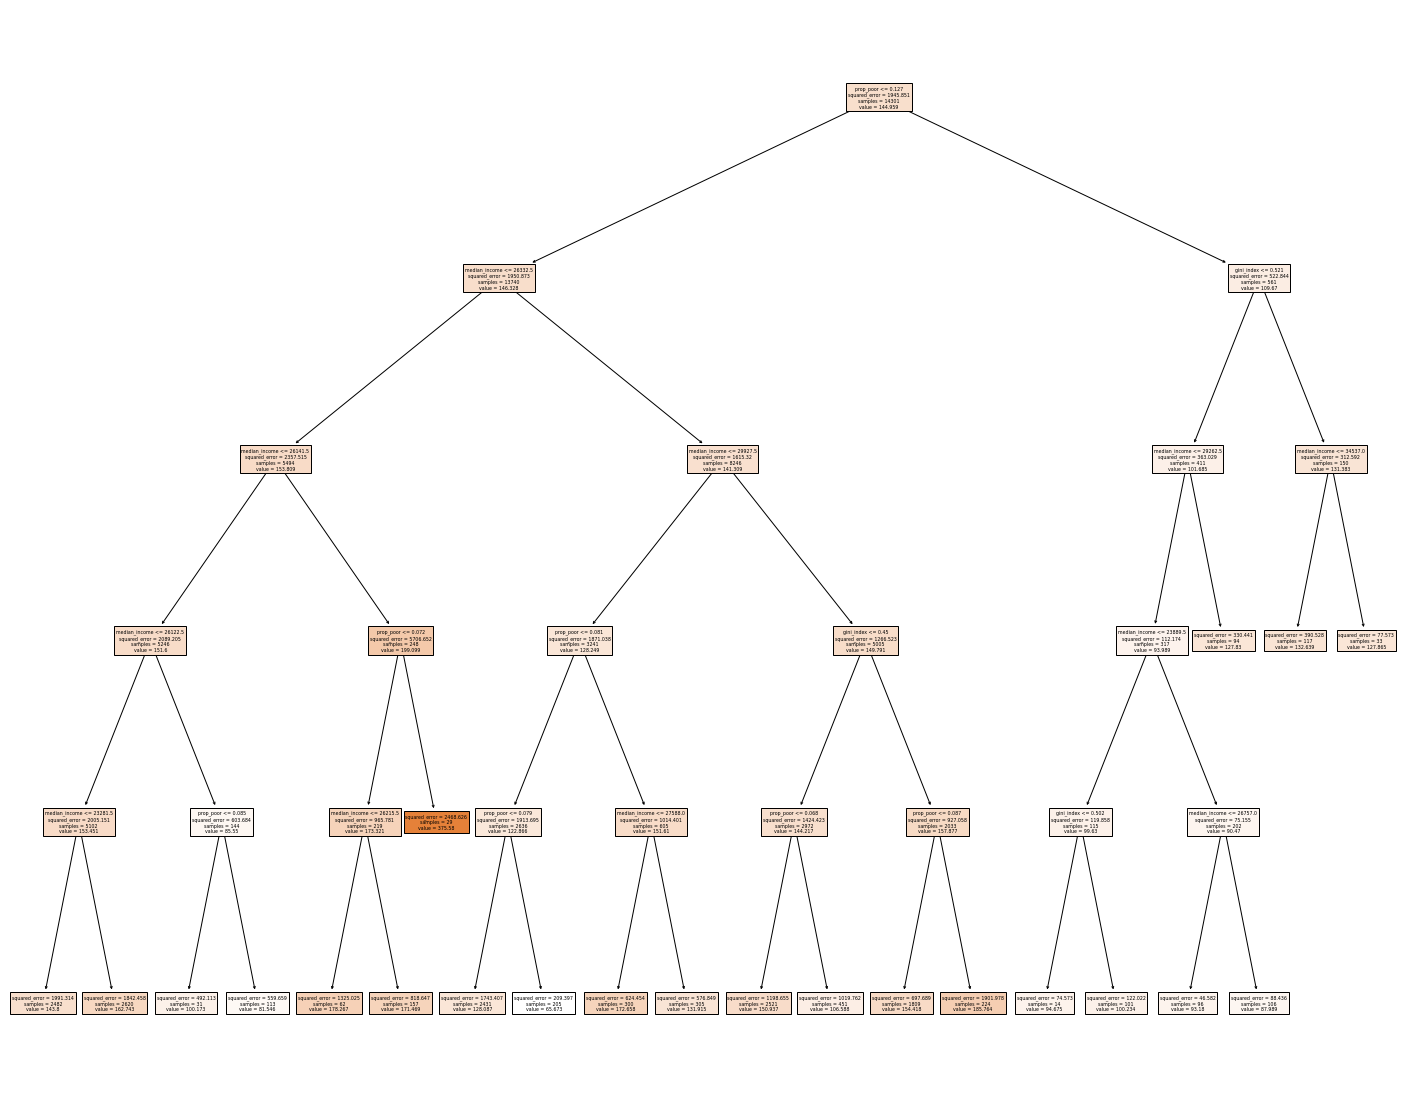

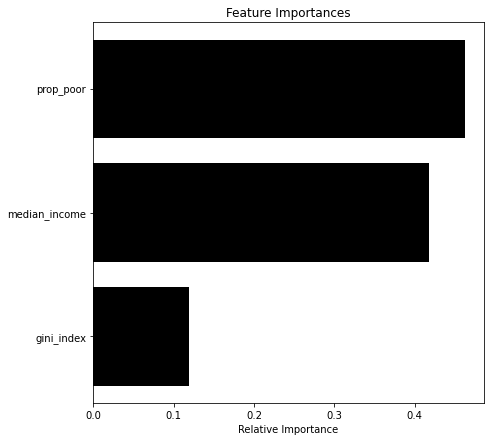

In [1044]:
#Northeast Econ 
northeast_econ_results = train_test_split(northeast_resampled, econ_vars, [])
northeast_econ_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', northeast_econ_results[0], northeast_econ_results[1], northeast_econ_results[2], northeast_econ_results[3] )

30936
Length Training Set:  22695
Training Set Ratio:  0.733611326609775
Length Testing Set:  8241
Testing Set Ratio:  0.266388673390225
Best Parameters for Model:  {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 50}
Train Error is:  -0.21458104518758542
Test Error is: 0.2374
Feature:  tavg_mean Importantance:  0.0017882767558659231
Feature:  tmin_min Importantance:  0.0007968913389224784
Feature:  tmax_max Importantance:  0.004516344669224185
Feature:  prcp_max Importantance:  0.009915964515596244
Feature:  snow_max Importantance:  3.6570663916199006e-05
Feature:  wspd_max Importantance:  0.0006628446529773445
Feature:  prop_65_85_up Importantance:  0.2989935376077727
Feature:  prop_female Importantance:  0.22078248806310646
Feature:  prop_white_nh Importantance:  0.033246348560912665
Feature:  pop_density Importantance:  0.08998504506602609
Feature:  median_income Importantance:  0.17067288644474882
Feature:  gini_index Importantance:  0.06758942605435606
Feature:  prop_poor

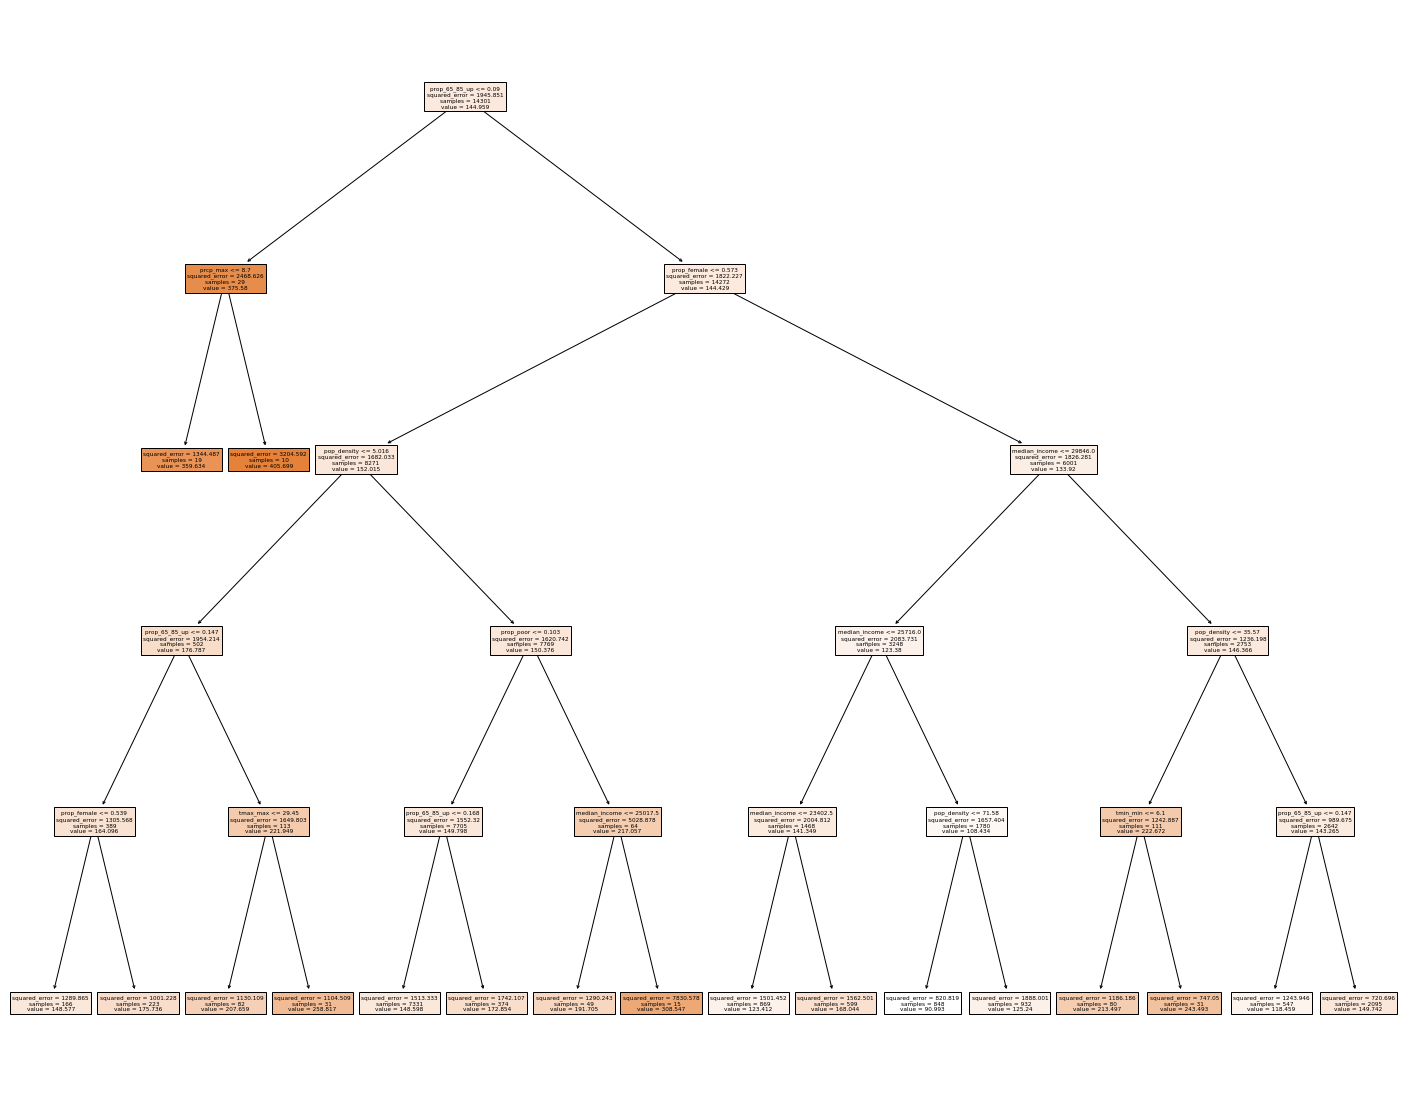

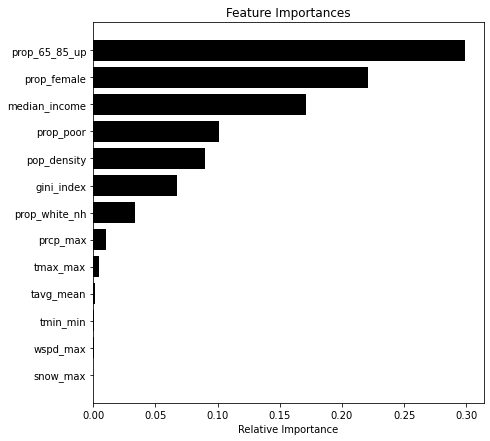

In [1045]:
#Northeast Full 
northeast_full_results = train_test_split(northeast_resampled, full_vars, [])
northeast_full_rf = analysis_pipeline('RF', rf_param_search, 'mean_absolute_percentage_error', northeast_full_results[0], northeast_full_results[1], northeast_full_results[2], northeast_full_results[3] )

In [886]:
#ANOVA data prep

combine_west_time_df = west_time_df.reset_index()
combine_west_time_df['region'] = 'west'
combine_midwest_time_df = midwest_time_df.reset_index()
combine_midwest_time_df['region'] = 'midwest'
combine_south_time_df = south_time_df.reset_index()
combine_south_time_df['region'] = 'south'
combine_northeast_time_df = northeast_time_df.reset_index()
combine_northeast_time_df['region'] = 'northeast'


In [887]:
cleaned_combined_regions = pd.concat([combine_west_time_df, combine_midwest_time_df, combine_south_time_df, combine_northeast_time_df], ignore_index=True)
cleaned_combined_regions

date  tavg_mean  tmin_min  tmax_max  prcp_max  snow_max  wspd_max  \
0     2010-01-01  -4.548276      -7.2      18.8      49.9       0.0      15.9   
1     2013-01-01  -7.596552     -16.0      21.7      12.5       0.0      21.4   
2     2014-01-01  -0.396154      -6.9      22.3       0.2       0.0      25.5   
3     2011-02-01  -2.518519     -16.1      24.9       5.4       0.0      23.2   
4     2013-02-01  -1.614815     -10.0      21.2       5.7       0.0      22.9   
...          ...        ...       ...       ...       ...       ...       ...   
67086 2011-11-01   4.766667      -8.3      20.0       0.8       0.0      15.6   
67087 2014-11-01   1.990000     -16.1      17.8       0.0       0.0      20.1   
67088 2009-12-01  -3.496552     -20.0      16.1       0.0       0.0      23.0   
67089 2010-12-01  -3.630000     -15.6      12.8       0.3       0.0      20.6   
67090 2011-12-01  -0.990000     -13.9      12.8       0.8       0.0      19.4   

       median_income  gini_index  pop_65_up  prop_65_85_up  prop_female  \
0            16458.0      0.4693       8984       0.109083     0.539849   
1            16458.0      0.4693       8984       0.109083     0.539849   
2            16458.0      0.4693       8984       0.109083     0.539849   
3            16458.0      0.4693       8984       0.109083     0.539849   
4            16458.0      0.4693       8984       0.109083     0.539849   
...              ...         ...        ...            ...          ...   
67086        29205.0      0.4596      10798       0.124375     0.540193   
67087        29205.0      0.4596      10798       0.124375     0.540193   
67088        29205.0      0.4596      10798       0.124375     0.540193   
67089        29205.0      0.4596      10798       0.124375     0.540193   
67090        29205.0      0.4596      10798       0.124375     0.540193   

       prop_white_nh  prop_poor  pop_density  scaled_fall_rate  prcp_mean  \
0           0.329252   0.230298     1.004329        122.439893       49.9   
1           0.329252   0.230298     1.004329        122.439893       12.5   
2           0.329252   0.230298     1.004329        122.439893        0.2   
3           0.329252   0.230298     1.004329        166.963491        5.4   
4           0.329252   0.230298     1.004329        122.439893        5.7   
...              ...        ...          ...               ...        ...   
67086       0.988239   0.070106     7.381334        111.131691        0.8   
67087       0.988239   0.070106     7.381334        111.131691        0.0   
67088       0.988239   0.070106     7.381334        111.131691        0.0   
67089       0.988239   0.070106     7.381334        157.436562        0.3   
67090       0.988239   0.070106     7.381334        157.436562        0.8   

          region  
0           west  
1           west  
2           west  
3           west  
4           west  
...          ...  
67086  northeast  
67087  northeast  
67088  northeast  
67089  northeast  
67090  northeast  

[67091 rows x 18 columns]

In [892]:
cleaned_combined_regions.columns

Index(['date', 'tavg_mean', 'tmin_min', 'tmax_max', 'prcp_max', 'snow_max',
       'wspd_max', 'median_income', 'gini_index', 'pop_65_up', 'prop_65_85_up',
       'prop_female', 'prop_white_nh', 'prop_poor', 'pop_density',
       'scaled_fall_rate', 'prcp_mean', 'region'],
      dtype='object')

In [904]:
#perform two-way ANOVA
model = ols('prop_poor ~ C(region)', data=cleaned_combined_regions).fit()
print(sm.stats.anova_lm(model, typ=2).round(4))
print(model.pvalues)


            sum_sq       df          F  PR(>F)
C(region)   7.5759      3.0  3143.4671     0.0
Residual   53.8943  67087.0        NaN     NaN
Intercept                  0.000000e+00
C(region)[T.northeast]     2.772852e-27
C(region)[T.south]         0.000000e+00
C(region)[T.west]         6.932126e-305
dtype: float64


## Maybe Lasso

In [395]:
#need to standardize for lasso 

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.fit_transform(X_test) 

In [678]:
#use forward chaining instead of cv 
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

lasso = LassoCV(random_state =42, fit_intercept = False)

#not sure if there are any other relevant hyperparameters
lasso_param_search = { 
}

tscv = TimeSeriesSplit(n_splits=5)

#mean squared error and r2 
lasso_gsearch = GridSearchCV(estimator=lasso, cv=tscv, param_grid=lasso_param_search, scoring = 'neg_mean_squared_error')

lasso_gsearch.fit(X_train_scaled, y_train)

best_score = lasso_gsearch.best_score_
best_model = lasso_gsearch.best_estimator_


ValueError: Found input variables with inconsistent numbers of samples: [66718, 66945]

In [161]:
#crossfold validation to find alpha 

weather_model = LassoCV(cv=5, random_state=42, max_iter=1000)

# Fit model
weather_model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=42)

In [162]:
weather_model.alpha_

0.09763138091210258

In [163]:
lasso = Lasso(alpha=weather_model.alpha_)
lasso.fit(X_train, y_train)

Lasso(alpha=0.09763138091210258)

In [164]:
lasso.coef_

array([-0.        ,  4.27798416,  0.        ,  0.        ,  0.        ,
       -3.09685723,  0.39353111,  2.59995409,  0.        ,  6.0435824 ,
       -0.        , -3.3697892 ,  1.52936417,  1.25695138,  4.20555388,
       -0.        ,  2.39109973, -0.72908801, -1.05841501,  0.        ,
        0.        , -0.        , -0.3503145 , -1.03416018, -0.        ,
       -5.2786699 , -5.10722126,  4.9614533 ,  0.        ,  1.63559612])

In [165]:
lasso_coefs_labels = list(zip(lasso.coef_, X))

In [167]:
lasso_coefs_labels.sort(key=lambda tup: abs(tup[0]), reverse=True) 

In [168]:
lasso_coefs_labels
#interesting maximum temperature was most associated, positively 
#the greater the standard deviation in temp, falls decrease? 
#as the min temp increases, the fall risk decreases - makes sense!
#but differences in precipitation do lead to increased fall rates 


[(6.043582400704637, 'tmin_std'),
 (-5.278669902284462, 'wspd_min'),
 (-5.107221258730419, 'wspd_max'),
 (4.96145329596952, 'wspd_median'),
 (4.277984162242275, 'tavg_max'),
 (4.205553875214031, 'tmax_std'),
 (-3.3697892026832927, 'tmax_max'),
 (-3.0968572294719996, 'tmin_min'),
 (2.5999540903815785, 'tmin_median'),
 (2.3910997341561377, 'prcp_max'),
 (1.635596124971996, 'wspd_std'),
 (1.5293641676983916, 'tmax_median'),
 (1.256951377444416, 'tmax_mean'),
 (-1.0584150057522614, 'prcp_mean'),
 (-1.0341601768940136, 'snow_mean'),
 (-0.7290880113111265, 'prcp_median'),
 (0.39353111409897384, 'tmin_max'),
 (-0.35031450108135864, 'snow_median'),
 (-0.0, 'tavg_min'),
 (0.0, 'tavg_median'),
 (0.0, 'tavg_mean'),
 (0.0, 'tavg_std'),
 (0.0, 'tmin_mean'),
 (-0.0, 'tmax_min'),
 (-0.0, 'prcp_min'),
 (0.0, 'prcp_std'),
 (0.0, 'snow_min'),
 (-0.0, 'snow_max'),
 (-0.0, 'snow_std'),
 (0.0, 'wspd_mean')]

In [169]:
#R squared score 
print('R squared training set', round(lasso.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso.score(X_test, y_test)*100, 2))


R squared training set 2.45
R squared test set 2.37


In [170]:
#MSE 
# Training data
pred_train = lasso.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set', round(mse_train, 2))

# Test data
pred = lasso.predict(X_test)
mse_test =mean_squared_error(y_test, pred)
print('MSE test set', round(mse_test, 2))

MSE training set 4377.47
MSE test set 4465.5
